# Projet 3 OpenFoodFacts - Notebook de nettoyage du jeu de données

Lien vers les consignes du projet sur openclassrooms : https://openclassrooms.com/fr/projects/628/assignment

description du jeu de données : https://world.openfoodfacts.org/data/data-fields.txt

# Sommaire :

**Partie 1 : Question 1**

 - <a href="#C1">1 - Importation et desciption des données</a>
     - <a href="#C11">1.1 - Environnement & Imports </a>
     - <a href="#C12">1.2 - Définition des fonctions</a>
     - <a href="#C13">1.3 - Chargement Dataset</a>     
     - <a href="#C14">1.4 - Fichier EdStatsCountry-Series.csv</a>  
     - <a href="#C15">1.5 - Fichier EdStatsFootNote.csv</a>  
 
**Partie 2 : Nettoyez un jeu de données**

 - <a href="#C2">2 - Nettoyez et triez le jeu de données</a>  
     - <a href="#C21">2.1 - Suppression valeur manquante</a>     
     - <a href="#C22">2.2 - Contrôle des colonnes</a>
     - <a href="#C23">2.3 - Nettoyage types</a>
     - <a href="#C24">2.4 - Format timestamp des colonnes</a>
     - <a href="#C25">2.5 - Traitement des colonnes "Tags"</a>
     - <a href="#C26">2.6 - Suppression des colonnes contenant trop de NaN</a>
         - <a href="#C261">2.6.1 - Conclusion</a>
     - <a href="#C27">2.7 - Traitement des outliers</a>
     - <a href="#C28">2.8 - Imputation des NaN par méthodes des kNN</a> 
         - <a href="#C281">2.8.1 - Fonction avec méthodes des kNN(impute_knn(dataframe))</a>
     - <a href="#C29">2.9 - Traitement sur plusieurs variables numériques du jeu de données</a> 
     - <a href="#C210">2.10 - Distribution des variables avant et après imputation des NaN</a> 
         - <a href="#C2101">2.10.1 - Conclusions</a>      


# Question 1 Traiter le jeu de données afin de repérer des variables pertinentes pour les traitements à venir. Automatiser ces traitements pour éviter de répéter ces opérations.

# <a name="C1">1 - Importation et desciption des données </a> 

## <a name="C11">1.1 - Environnement & Imports </a> 

In [1]:
!pip install missingno

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
import importlib
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os
from datetime import datetime
import time

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

from scipy.spatial import KDTree
import warnings
warnings.filterwarnings('ignore')

# Affichage des graphiques dans le notebook
%matplotlib inline

In [3]:
#Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
#configure Pandas pour afficher jusqu'à 200 colonnes dans les DataFrames.
pd.set_option('display.max_columns', 200)
# configure Pandas pour afficher jusqu'à 1000 lignes dans les DataFrames.
pd.set_option('display.max_rows', 1000)
#configure Pandas pour afficher la totalité de la largeur des colonnes des DataFrames, sans limite.
pd.set_option('display.max_colwidth', -1)

## <a name="C12">1.2 - Définition des fonctions </a> 

In [4]:
# Printing total nb and percentage of null

def print_null_pct(df):
    tot_null = df.isna().sum().sum()
    print('nb of null: ', tot_null, '\npct of null: ',
        '{:.1f}'.format(tot_null*100/(df.shape[0]*df.shape[1])))

In [5]:
# Displaying number of missing values per column

def plot_export_missing(df, cols, n_file, title,
                        shorten_label=False, figsize=(12,8)):
    with plt.style.context('default'):
        fig, axs = plt.subplots(2,1)
        msno.matrix(df[cols] , sparkline=False,
                    fontsize=11, ax=axs[0])
        msno.bar(df[cols], ax=axs[1], fontsize=11)
        if shorten_label:
            for ax in axs:
                lab = [item.get_text() for item in ax.get_xticklabels()]
                short_lab = [s[:7]+'...'+s[-7:] if len(s)>14 else s for s in lab]
                ax.axes.set_xticklabels(short_lab)
    fig.set_size_inches(figsize)
    [ax.grid() for ax in axs.flatten()];
    [sns.despine(ax=ax, right=False, left=False,top=False, bottom=False)\
                                        for ax in axs.flatten()];
    plt.subplots_adjust(hspace=0.3)
    plt.tight_layout(rect=[0, 0.05, 1, 0.92])
    fig.suptitle(title, fontweight='bold', fontsize=14)
    if not os.path.exists(os.getcwd()+'/FIG'):
        os.makedirs('FIG')
    plt.savefig(os.getcwd()+'/FIG/'+n_file, dpi=400);
    plt.show()

In [6]:
# def save_figure(n_file):
#     fig_dir = os.path.join(os.getcwd(), 'FIG')
#     if not os.path.exists(fig_dir):
#         os.makedirs(fig_dir)
#     fig_path = os.path.join(fig_dir, n_file)
#     plt.savefig(fig_path, dpi=400)
#     plt.show()

In [7]:
# def save_figure_opt(n_file, library='matplotlib'):
#     fig_dir = os.path.join(os.getcwd(), 'FIG')
#     if not os.path.exists(fig_dir):
#         os.makedirs(fig_dir)
#     fig_path = os.path.join(fig_dir, n_file)
#     if library == 'seaborn':
#         sns.savefig(fig_path, dpi=400)
#     else:
#         plt.savefig(fig_path, dpi=400)
#     plt.show()

def save_figure_opt(n_file, repertoire='Graphique', library='matplotlib'):
    # Create the directory path based on the current time and the specified subdirectory
    fig_dir = os.path.join(os.getcwd(), 'FIG', repertoire, time.strftime("%d_%m_%Y_%H_%M"))
    # Create the directory if it does not exist
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    # Set the path to save the figure inside the directory
    fig_path = os.path.join(fig_dir, n_file)
    # Save the figure using the specified library
    if library == 'seaborn':
        sns.savefig(fig_path, dpi=800)
    else:
        plt.savefig(fig_path, dpi=800)
    # Adjust the layout to avoid overlapping of axis labels and titles
    fig = plt.gcf()
    fig.tight_layout()    
    # Adjust the margins of the figure to include all texts and legends
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    # Show the figure
    plt.show()

    

In [8]:
def optimize_dataframe(df):
    new_dtypes = {}

    # object -> category (if nb unique < half total nb of rows and not XXX_100g)
    for col in df.columns.values:
        if df[col].dtype == 'object' :
            if len(df[col].unique()) / len(df[col]) < 0.5:
                new_dtypes[col] = 'category'
            else:
                new_dtypes[col] = 'object'

    # float64 -> float32
    for col in df.columns.values:
        if df[col].dtype == 'float64':
            if df[col].notna().sum()!=0: # 1% sample columns happening to be all null 
                new_dtypes[col] = 'float32'

    # int64 -> int8
    for col in df.columns.values:
        if df[col].dtype == 'int64':
            new_dtypes[col] = 'int8'

    return df.astype(new_dtypes)
# def downcast_dtypes(df):
#     new_dtypes = {}
    
#     # convertir les objets en categories si le nombre d'éléments uniques est inférieur à la moitié du nombre total de lignes
#     # et si le nom de la colonne ne contient pas "100g"
#     for col in df.columns.values:
#         if df[col].dtype == 'object':
#             if len(df[col].unique()) / len(df[col]) < 0.5 and '100g' not in col:
#                 new_dtypes[col] = 'category'
#             else:
#                 new_dtypes[col] = 'object'

#     # convertir les float64 en float32
#     for col in df.columns.values:
#         if df[col].dtype == 'float64':
#             # vérifier si la colonne ne contient pas que des valeurs nulles
#             if df[col].notna().sum() != 0:
#                 new_dtypes[col] = 'float32'

#     # convertir les int64 en int8
#     for col in df.columns.values:
#         if df[col].dtype == 'int64':
#             new_dtypes[col] = 'int8'

#     # appliquer les nouveaux types de données aux colonnes correspondantes
#     return df.astype(new_dtypes)


In [9]:
import re

def clean_quantity(df):
    # Création d'un dictionnaire des unités de mesure et des facteurs de conversion correspondants
    units = {
        'g': 1,
        'kg': 1000,
        'mg': 0.001,
        'µg': 0.000001,
        'l': 1000,
        'ml': 1,
        'cl': 10,
        'dl': 100
    }

    # Regex pour extraire la quantité et l'unité de mesure de chaque entrée de la colonne "quantity"
    regex = r'(\d*\.?\d+)\s*([\w,]+)'
    matches = df['quantity'].str.extract(regex, expand=True)

    # Traitement de la quantité pour la rendre exploitable
    matches[0] = matches[0].str.replace(',', '.').astype(float)
    matches[1] = matches[1].str.lower()

    # Remplacement des unités de mesure non standardisées
    matches[1] = matches[1].replace({'litre': 'l', 'litres': 'l', 'kg.': 'kg', 'g.': 'g'})
    df['quantity_origine'] =  df['quantity'] 
    # Convertit la quantité en grammes en multipliant par le facteur de conversion correspondant à l'unité de mesure
    df['quantity_clean'] = matches[0] * matches[1].map(units)
    df['quantity_clean'] = df['quantity_clean'].fillna(0).astype(int)

    # Renomme les colonnes pour refléter les changements apportés
    df.rename(columns={'quantity': 'quantity_original'}, inplace=True)
    df.rename(columns={'quantity_clean': 'quantity'}, inplace=True)
    df['quantity_unit'] = 'g'

    return df


In [10]:
def drop_cols(data, li_col_del):
    cols_to_drop = []
    cols_to_keep = []

    for col in li_col_del:
        if col in data.columns:
            data.drop(columns=col, inplace=True)
            cols_to_drop.append(col)

    for col in data.columns:
        if col not in li_col_del:
            cols_to_keep.append(col)

    return cols_to_drop, cols_to_keep, data


In [11]:
# def check_column_existence(df, col_name):
#     """
#     Vérifie si une colonne existe dans un dataframe donné.

#     Args:
#         df (pandas.DataFrame): Le dataframe dans lequel la colonne doit être vérifiée.
#         col_name (str): Le nom de la colonne à vérifier.

#     Returns:
#         tuple: Un tuple contenant un booléen indiquant si la colonne existe et un message décrivant le résultat.
#     """
#     if col_name in df.columns:
#         message = f"La colonne '{col_name}' est présente dans le dataframe."
#         return True, message
#     else:
#         message = f"La colonne '{col_name}' n'est pas présente dans le dataframe."
#         return False, message


In [12]:
from datetime import datetime

def check_column_existence(df, col_name):
    """
    Vérifie si une colonne existe dans un dataframe donné.

    Args:
        df (pandas.DataFrame): Le dataframe dans lequel la colonne doit être vérifiée.
        col_name (str): Le nom de la colonne à vérifier.

    Returns:
        tuple (bool, str): Un tuple contenant un booléen (True si la colonne existe, False sinon) 
                           et un message de résultat.
    """
    if col_name in df.columns:
        message = f"Le {datetime.now().strftime('%d/%m/%Y à %Hh%M')}, La colonne '{col_name}' est présente dans le dataframe."
        return True, message
    else:
        message = f"Le {datetime.now().strftime('%d/%m/%Y à %Hh%M')}, la colonne '{col_name}' n'est pas présente dans le dataframe."
        return False, message


In [13]:
from datetime import datetime

def check_column_existence(df, col_name):
    """
    Vérifie si une colonne existe dans un dataframe donné.

    Args:
        df (pandas.DataFrame): Le dataframe dans lequel la colonne doit être vérifiée.
        col_name (str): Le nom de la colonne à vérifier.

    Returns:
        tuple (bool, str): Un tuple contenant un booléen (True si la colonne existe, False sinon) 
                           et un message de résultat.
    """
    if col_name in df.columns:
        message = f"Le {datetime.now().strftime('%d/%m/%Y à %Hh%M')}, La colonne '{col_name}' est présente dans le dataframe."
        return message
    else:
        message = f"Le {datetime.now().strftime('%d/%m/%Y à %Hh%M')}, la colonne '{col_name}' n'est pas présente dans le dataframe."
        return message 


In [14]:
from sklearn.impute import KNNImputer

def clean_dataframe_impute_knn(df):
    print('....................... DEBUT De la fonction clean_dataframe_impute_knn  : \n...................')     
    
    # Liste des colonnes avec des valeurs manquantes
    numeric_columns = df.select_dtypes(['int32','float64','int8','float32']).columns
    # Imputation des valeurs manquantes avec la stratégie "most_frequent"
    imputer = KNNImputer(n_neighbors=5)
    df[numeric_columns] = pd.DataFrame(imputer.fit_transform(df[numeric_columns]), columns=numeric_columns)    

    print('....................... Dans la fonction clean_dataframe_impute_knn df.shape : \n...................')   
    print(df.shape)
    print('....................... Dans la fonction clean_dataframe_impute_knn df.columns : \n...................') 
    print(df.columns.tolist())
    print('....................... Fin De la fonction clean_dataframe_impute_knn  : \n...................')        
    return df


In [15]:
def clean_dataframe_IterativeImputer(df):
    
    # Sélectionner les colonnes numériques
    numeric_columns = df.select_dtypes(['int32','float64','int8','float32']).columns    
    print(numeric_columns)
    # Copie du DataFrame original pour éviter les modifications indésirables
    df_cleaned = df[numeric_columns] # df.copy()
    # Imputation des valeurs manquantes par la méthode itérative avec RandomForestRegressor
    imputer_iterative = IterativeImputer(estimator=RandomForestRegressor())
    df_cleaned_rfr = imputer_iterative.fit_transform(df_cleaned)
    print('apres fit_transform imputer_iterative')
    # Suppression des lignes avec des valeurs manquantes restantes
#     df_cleaned.dropna(inplace=True)

    return df_cleaned_rfr


In [16]:
# def clean_dataframe_median(df):
#     print('....................... DEBUT De la fonction clean_dataframe_median  : \n...................')  
#     # Tri du DataFrame d'origine df par la colonne "nom_produit"
#     df = df.sort_values(by="product_name")
#     # Sélectionner les colonnes numériques
#     numeric_columns = df.select_dtypes(['int32','float64','int8','float32']).columns    
#     print(numeric_columns)
#     # Copie du DataFrame original pour éviter les modifications indésirables
#     df_m = df[numeric_columns] # df.copy()
#     # Création d'un objet imputer avec la stratégie de remplacement par la médiane
#     imputer = SimpleImputer(strategy='median')
#     # Application de l'imputation sur le DataFrame en remplaçant les valeurs manquantes par la médiane de chaque colonne
# #     df_cleaned_m = pd.DataFrame(imputer.fit_transform(df_m))
#     df_cleaned_m = pd.DataFrame(imputer.fit_transform(df_m), columns=df_m.columns)
#     df_cleaned_m["product_name"] = df["product_name"]
#     # Retour du DataFrame nettoyé
#     print('....................... Dans la fonction clean_dataframe_median df_cleaned.shape : \n...................')   
#     print(df_cleaned_m.shape)
#     print('....................... Dans la fonction clean_dataframe_median df_cleaned.columns : \n...................') 
#     print(df_cleaned_m.columns.tolist())
#     print('....................... Fin De la fonction clean_dataframe_median  : \n...................')     
#     return df_cleaned_m
#############################
# def clean_dataframe_median(df):
#     print('....................... DEBUT De la fonction clean_dataframe_median  : \n...................')  
#     # Tri du DataFrame d'origine df par la colonne "nom_produit"
#     df = df.sort_values(by="product_name")
#     # Sélectionner les colonnes numériques
#     numeric_columns = df.select_dtypes(['int32', 'float64', 'int8', 'float32']).columns    
#     print(numeric_columns)
#     # Création d'un objet imputer avec la stratégie de remplacement par la médiane
#     imputer = SimpleImputer(strategy='median')
#     # Application de l'imputation sur le DataFrame en remplaçant les valeurs manquantes par la médiane de chaque colonne
# #     df= pd.DataFrame(imputer.fit_transform(df[numeric_columns]), columns=numeric_columns)
#     df[numeric_columns] = pd.DataFrame(imputer.fit_transform(df[numeric_columns]), columns=numeric_columns)

#     # Retour du DataFrame nettoyé
#     print('....................... Dans la fonction clean_dataframe_median df_cleaned.shape : \n...................')   
#     print(df.shape)
#     print('....................... Dans la fonction clean_dataframe_median df_cleaned.columns : \n...................') 
#     print(df.columns.tolist())
#     print('....................... Fin De la fonction clean_dataframe_median  : \n...................')     
#     return df
#############################
from sklearn.impute import SimpleImputer

def clean_dataframe_median(df):
    print('....................... DEBUT De la fonction clean_dataframe_median  : \n...................')  
    # Sélectionner les colonnes numériques
    numeric_columns = df.select_dtypes(['int32', 'float64', 'int8', 'float32']).columns    
    print(numeric_columns)
    # Création d'un objet imputer avec la stratégie de remplacement par la médiane
    imputer = SimpleImputer(strategy='median')
    
    # Boucle sur les colonnes numériques pour remplacer les valeurs manquantes par la médiane
    for col in numeric_columns:
        # Vérification si la colonne contient des valeurs manquantes
        if df[col].isnull().sum() > 0:
            # Remplacement des valeurs manquantes par la médiane de la colonne
            df[col] = imputer.fit_transform(df[[col]]).ravel()
    
    # Retour du DataFrame nettoyé
    print('....................... Dans la fonction clean_dataframe_median df_cleaned.shape : \n...................')   
    print(df.shape)
    print('....................... Dans la fonction clean_dataframe_median df_cleaned.columns : \n...................') 
    print(df.columns.tolist())
    print('....................... Fin De la fonction clean_dataframe_median  : \n...................')     
    return df


In [17]:
# def clean_dataframe_SimpleImputer(df):
#     print('....................... DEBUT De la fonction clean_dataframe_SimpleImputer  : \n...................')     
#     # Copie du DataFrame original pour éviter les modifications indésirables
#     df_cleaned = df.copy()
    
#     # Liste des colonnes avec des valeurs manquantes
#     columns_with_missing_values = df_cleaned.columns[df_cleaned.isna().any()].tolist()
    
#     # Imputation des valeurs manquantes avec la stratégie "most_frequent"
#     imputer = SimpleImputer(strategy='most_frequent')
# #     df_cleaned_si = imputer.fit_transform(df_cleaned[columns_with_missing_values], columns=df_m.columns)
#     df_cleaned_si = pd.DataFrame(imputer.fit_transform(df_cleaned), columns=df_m.columns)   
#     print('....................... Dans la fonction clean_dataframe_SimpleImputer df_cleaned.shape : \n...................')   
#     print(df_cleaned_si.shape)
#     print('....................... Dans la fonction clean_dataframe_SimpleImputer df_cleaned.columns : \n...................') 
#     print(df_cleaned_si.columns.tolist())
#     print('....................... Fin De la fonction clean_dataframe_SimpleImputer  : \n...................')        
#     return df_cleaned_si
def clean_dataframe_SimpleImputer(df):
    print('....................... DEBUT De la fonction clean_dataframe_SimpleImputer  : \n...................')     
    
    # Liste des colonnes avec des valeurs manquantes
    columns_with_missing_values = df.columns[df.isna().any()].tolist()
    
    # Imputation des valeurs manquantes avec la stratégie "most_frequent"
    imputer = SimpleImputer(strategy='most_frequent')
#     df_cleaned_si = imputer.fit_transform(df_cleaned[columns_with_missing_values], columns=df_m.columns)
#     df = pd.DataFrame(imputer.fit_transform(df_cleaned), columns=df_m.columns) 
#     df= pd.DataFrame(imputer.fit_transform(df[columns_with_missing_values]), columns=columns_with_missing_values)  
    df[columns_with_missing_values] = pd.DataFrame(imputer.fit_transform(df[columns_with_missing_values]), columns=columns_with_missing_values)    

    print('....................... Dans la fonction clean_dataframe_SimpleImputer df_cleaned.shape : \n...................')   
    print(df.shape)
    print('....................... Dans la fonction clean_dataframe_SimpleImputer df_cleaned.columns : \n...................') 
    print(df.columns.tolist())
    print('....................... Fin De la fonction clean_dataframe_SimpleImputer  : \n...................')        
    return df


In [18]:
def select_columns(df, columns):
    # Création d'un nouveau dataframe avec les colonnes sélectionnées
    df_selected = df[columns].copy()
    
    # Retour du dataframe avec les colonnes sélectionnées
    return df_selected


In [19]:
def filtre_data_columns(df):
    """
    Cette fonction filtre les colonnes d'un dataframe selon une sélection spécifique.
    
    Arguments :
    - df : dataframe - Le dataframe d'origine
    
    Retour :
    - df_selected : dataframe - Le dataframe filtré avec les colonnes sélectionnées
    """
    
    # Sélection des colonnes à conserver
    pca_cols = ['additives_n', 'ingredients_from_palm_oil_n',
                'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
                'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
                'proteins_100g', 'salt_100g', 'sodium_100g']
    quant_cols = ['energy_100g', 'fat_100g', 'sugars_100g']
    qual_col = 'nutrition_grade_fr'
    
    # Création d'une liste avec les colonnes sélectionnées
    columns = pca_cols + quant_cols + [qual_col]

    # Création d'un nouveau dataframe avec les colonnes sélectionnées
    df_selected = select_columns(df, columns)
    
    # Retour du dataframe avec les colonnes sélectionnées
    return df_selected


In [20]:
def fillna_and_check_range(df, tolerance=0.01):
    columns_to_check = ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n',
                        'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
                        'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g']

    # Remplacer les valeurs manquantes ou NaN par 0
    df[columns_to_check] = df[columns_to_check].fillna(0)

    # Vérifier si les valeurs sont comprises entre 0 et 100
    check_range = df[columns_to_check].apply(lambda x: x.between(0, 100))

    # Retourner le DataFrame filtré avec les valeurs en dehors de la plage remplacées par 0
    df[columns_to_check] = df[columns_to_check].where(check_range, other=0)

    # Supprimer les lignes où toutes les valeurs des colonnes spécifiées sont égales à 0
    df = df.loc[~(df[columns_to_check] == 0).all(axis=1)]
    # Supprimer les lignes où toutes les valeurs des colonnes spécifiées sont égales ou proches de 0
    df = df.loc[~np.isclose(df[columns_to_check], 0, atol=tolerance).all(axis=1)]
    
    return df


## <a name="C13">1.3 - Chargement Dataset </a> 

Réduction de l'utilisation de la mémoire 

Afin de faciliter la manipulation, nous changeons le format d'encodage

les entiers et les flottants doivent être downcastés
les objets doivent être modifiés en catégorie (si le nombre de valeurs uniques est inférieur à la moitié du nombre de lignes)
NB : Si nous connaissons déjà le format des données, nous pouvons spécifier le format de chaque colonne lors du chargement des données dans une dataframe pandas : pd.read_csv('path', dtype=new_dtypes)

In [21]:
## Changing format of object and float64 columns
# Charger le fichier CSV
df = pd.read_csv("../data/fr.openfoodfacts.org.products.csv", sep='\t')
new_dtypes = {}

# object -> category (if nb unique < half total nb of rows and not XXX_100g)
for col in df.columns.values:
    if df[col].dtype == 'object' :
        if len(df[col].unique()) / len(df[col]) < 0.5:
            new_dtypes[col] = 'category'
        else:
            new_dtypes[col] = 'object'

# float64 -> float32
for col in df.columns.values:
    if df[col].dtype == 'float64':
        if df[col].notna().sum()!=0: # 1% sample columns happening to be all null 
            new_dtypes[col] = 'float32'

# int64 -> int8
for col in df.columns.values:
    if df[col].dtype == 'int64':
        new_dtypes[col] = 'int8'
        
print(new_dtypes)

{'code': 'object', 'url': 'object', 'creator': 'category', 'created_t': 'object', 'created_datetime': 'object', 'last_modified_t': 'object', 'last_modified_datetime': 'object', 'product_name': 'object', 'generic_name': 'category', 'quantity': 'category', 'packaging': 'category', 'packaging_tags': 'category', 'brands': 'category', 'brands_tags': 'category', 'categories': 'category', 'categories_tags': 'category', 'categories_fr': 'category', 'origins': 'category', 'origins_tags': 'category', 'manufacturing_places': 'category', 'manufacturing_places_tags': 'category', 'labels': 'category', 'labels_tags': 'category', 'labels_fr': 'category', 'emb_codes': 'category', 'emb_codes_tags': 'category', 'first_packaging_code_geo': 'category', 'cities': 'category', 'cities_tags': 'category', 'purchase_places': 'category', 'stores': 'category', 'countries': 'category', 'countries_tags': 'category', 'countries_fr': 'category', 'ingredients_text': 'object', 'allergens': 'category', 'allergens_fr': 'c

In [22]:
print(check_column_existence(df, 'energy-from-fat_100g'))  

Le 12/06/2023 à 08h50, La colonne 'energy-from-fat_100g' est présente dans le dataframe.


In [23]:
## Forcing XXX_100g and nutriscore columns to 'float32' and nova to 'object'

X_100g_cols = df.columns[df.columns.str.contains('_100g')]
for col in X_100g_cols:
    new_dtypes[col] = 'float32'
#df['nova_group'] = df['nova_group'].astype('object') 

In [24]:
# Charger le fichier CSV
df = pd.read_csv("../data/fr.openfoodfacts.org.products.csv", sep='\t')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 1.7 GB


In [25]:
df.head(10)

code  \
0  3087    
1  4530    
2  4559    
3  16087   
4  16094   
5  16100   
6  16117   
7  16124   
8  16193   
9  16513   

                                                                                                   url  \
0  http://world-fr.openfoodfacts.org/produit/0000000003087/farine-de-ble-noir-ferme-t-y-r-nao            
1  http://world-fr.openfoodfacts.org/produit/0000000004530/banana-chips-sweetened-whole                  
2  http://world-fr.openfoodfacts.org/produit/0000000004559/peanuts-torn-glasser                          
3  http://world-fr.openfoodfacts.org/produit/0000000016087/organic-salted-nut-mix-grizzlies              
4  http://world-fr.openfoodfacts.org/produit/0000000016094/organic-polenta-bob-s-red-mill                
5  http://world-fr.openfoodfacts.org/produit/0000000016100/breadshop-honey-gone-nuts-granola-unfi        
6  http://world-fr.openfoodfacts.org/produit/0000000016117/organic-long-grain-white-rice-lundberg        
7  http://world-fr.openfoodfacts.org/produit/0000000016124/organic-muesli-daddy-s-muesli                 
8  http://world-fr.openfoodfacts.org/produit/0000000016193/organic-dark-chocolate-minis-equal-exchange   
9  http://world-fr.openfoodfacts.org/produit/0000000016513/organic-sunflower-oil-napa-valley-naturals    

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1  usda-ndb-import             1489069957  2017-03-09T14:32:37Z   
2  usda-ndb-import             1489069957  2017-03-09T14:32:37Z   
3  usda-ndb-import             1489055731  2017-03-09T10:35:31Z   
4  usda-ndb-import             1489055653  2017-03-09T10:34:13Z   
5  usda-ndb-import             1489055651  2017-03-09T10:34:11Z   
6  usda-ndb-import             1489055730  2017-03-09T10:35:30Z   
7  usda-ndb-import             1489055711  2017-03-09T10:35:11Z   
8  usda-ndb-import             1489055651  2017-03-09T10:34:11Z   
9  usda-ndb-import             1489055654  2017-03-09T10:34:14Z   

  last_modified_t last_modified_datetime                       product_name  \
0  1474103893      2016-09-17T09:18:13Z   Farine de blé noir                  
1  1489069957      2017-03-09T14:32:37Z   Banana Chips Sweetened (Whole)      
2  1489069957      2017-03-09T14:32:37Z   Peanuts                             
3  1489055731      2017-03-09T10:35:31Z   Organic Salted Nut Mix              
4  1489055653      2017-03-09T10:34:13Z   Organic Polenta                     
5  1489055651      2017-03-09T10:34:11Z   Breadshop Honey Gone Nuts Granola   
6  1489055730      2017-03-09T10:35:30Z   Organic Long Grain White Rice       
7  1489055712      2017-03-09T10:35:12Z   Organic Muesli                      
8  1489055651      2017-03-09T10:34:11Z   Organic Dark Chocolate Minis        
9  1489055654      2017-03-09T10:34:14Z   Organic Sunflower Oil               

  generic_name quantity packaging packaging_tags                brands  \
0  NaN          1kg      NaN       NaN            Ferme t'y R'nao        
1  NaN          NaN      NaN       NaN            NaN                    
2  NaN          NaN      NaN       NaN            Torn & Glasser         
3  NaN          NaN      NaN       NaN            Grizzlies              
4  NaN          NaN      NaN       NaN            Bob's Red Mill         
5  NaN          NaN      NaN       NaN            Unfi                   
6  NaN          NaN      NaN       NaN            Lundberg               
7  NaN          NaN      NaN       NaN            Daddy's Muesli         
8  NaN          NaN      NaN       NaN            Equal Exchange         
9  NaN          NaN      NaN       NaN            Napa Valley Naturals   

            brands_tags categories categories_tags categories_fr origins  \
0  ferme-t-y-r-nao       NaN        NaN             NaN           NaN      
1  NaN                   NaN        NaN             NaN           NaN      
2  torn-glasser          NaN        NaN             N

In [26]:
# Charger le fichier CSV
data = pd.read_csv("../data/fr.openfoodfacts.org.products.csv",dtype=new_dtypes,header=0, sep='\t', low_memory=False, encoding ='utf-8')
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: category(47), float32(102), float64(4), object(9)
memory usage: 770.6 MB


In [27]:
#data = pd.read_csv("fropenfoodfactsorgproducts.csv", sep='\t')
#data = pd.read_csv("data/fr.openfoodfacts.org.products.csv", sep='\t')

In [28]:
# Unique values for nutrition_grade_fr column
print("Unique values for nutrition_grade_fr:")
print(df["nutrition_grade_fr"].unique())

# Unique values for nutrition-score-fr_100g column
print("Unique values for nutrition-score-fr_100g:")
print(df["nutrition-score-fr_100g"].unique())


Unique values for nutrition_grade_fr:
[nan 'd' 'b' 'c' 'a' 'e']
Unique values for nutrition-score-fr_100g:
[ nan  14.   0.  12.   7.  -6.  15.  11.   9.  16.  19.  -1.   6.  26.
  13.  10.  17.  22.  23.  30.   8.  25.  -2.   1.   2.  18.  21.  20.
   3.   4.  24.  27.  28.  -3.  -4.  -7.  -5.   5.  29.  31.  -8.  -9.
  35.  33.  32.  34. -10.  40.  37.  38. -11.  36. -13. -12. -14. -15.]


# <a name="C2">2 - Nettoyez et triez le jeu de données</a> 

## <a name="C21">2.1 - Suppression valeur manquante</a>

In [29]:
# Checking nb of not null values in the columns

nb_not_null = pd.DataFrame((~df.isna()).sum(axis =0), columns=['nb'])
nb_not_null.sort_values(by=['nb'], axis=0, ascending=True, inplace=True)
nb_not_null.T.head(150)
# Defining the "to-be-deleted" columns list

mask = pd.cut(nb_not_null['nb'], [-1,300])

li_col_del1 = list(mask[~mask.values.isna()].index)

li_col_del2 = ['carbon_footprint_100g',
               'carbon_footprint_from_meat_or_fish_100g',
#               'fruits_vegetables_nuts_100g',
#               'fruits_vegetables_nuts_estimate_100g',
               'ingredients_from_palm_oil_tags', 'origins',
               'ingredients_that_may_be_from_palm_oil_tags',
               'manufacturing_places', 'stores','cities_tags',
               'generic_name','collagen_meat_protein_ratio_100g',
               'first_packaging_code_geo','purchase_places', 'emb_codes']

# Dropping columns with too much missing values
li_col_del3 = ['monounsaturated_fat_100g','polyunsaturated_fat_100g', 'omega_3_fat_100g',
           '_alpha_linolenic_acid_100g', 'omega_6_fat_100g', 
           'trans_fat_100g', 'cholesterol_100g',
           'caffeine_100g', 'cocoa_100g','_lactose_100g', 'starch_100g',
           '_soluble_fiber_100g', '_insoluble_fiber_100g',
           'vitamin_a_100g', 'vitamin_d_100g', 'vitamin_e_100g',
           'vitamin_k_100g', 'vitamin_c_100g', 'vitamin_b1_100g',
           'vitamin_b2_100g', 'vitamin_pp_100g', 'vitamin_b6_100g',
           'vitamin_b9_100g', 'folates_100g', 'vitamin_b12_100g',
           'biotin_100g', 'pantothenic_acid_100g', 'bicarbonate_100g',
           'potassium_100g', 'chloride_100g', 'calcium_100g',
           'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g',
           'copper_100g', 'manganese_100g', 'selenium_100g', 'iodine_100g',
           'phylloquinone_100g' ]

li_col_del = list(set(li_col_del1) | set(li_col_del2) | set(li_col_del3))

# Dropping the columns

df = df.drop(columns=[c for c in li_col_del if c in df.columns])

print(df.shape)
print_null_pct(df)

(320772, 78)
nb of null:  13448535 
pct of null:  53.8


In [30]:
df.shape

(320772, 78)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Data columns (total 78 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   code                                     320749 non-null  object 
 1   url                                      320749 non-null  object 
 2   creator                                  320770 non-null  object 
 3   created_t                                320769 non-null  object 
 4   created_datetime                         320763 non-null  object 
 5   last_modified_t                          320772 non-null  object 
 6   last_modified_datetime                   320772 non-null  object 
 7   product_name                             303010 non-null  object 
 8   quantity                                 104819 non-null  object 
 9   packaging                                78960 non-null   object 
 10  packaging_tags                  

In [32]:
def drop_columns_with_missing_values(df):
    """
    Drops columns with too much missing values and not useful columns from a dataframe
    
    Args:
    - df: pandas DataFrame to be cleaned
    
    Returns:
    - df_cleaned: pandas DataFrame with dropped columns
    """
    
    # Checking nb of not null values in the columns
    nb_not_null = pd.DataFrame((~df.isna()).sum(axis=0), columns=['nb'])
    nb_not_null.sort_values(by=['nb'], axis=0, ascending=True, inplace=True)
    
    # Defining the "to-be-deleted" columns lists
    mask = pd.cut(nb_not_null['nb'], [-1, 300])
    li_col_del1 = list(mask[~mask.values.isna()].index)

    li_col_del2 = ['carbon_footprint_100g', 'carbon_footprint_from_meat_or_fish_100g',
                   'ingredients_from_palm_oil_tags', 'origins',
                   'ingredients_that_may_be_from_palm_oil_tags',
                   'manufacturing_places', 'stores', 'cities_tags',
                   'generic_name', 'collagen_meat_protein_ratio_100g',
                   'first_packaging_code_geo', 'purchase_places', 'emb_codes']

    li_col_del3 = ['monounsaturated_fat_100g','polyunsaturated_fat_100g', 'omega_3_fat_100g',
                   '_alpha_linolenic_acid_100g', 'omega_6_fat_100g', 
                   'trans_fat_100g', 'cholesterol_100g',
                   'caffeine_100g', 'cocoa_100g','_lactose_100g', 'starch_100g',
                   '_soluble_fiber_100g', '_insoluble_fiber_100g',
                   'vitamin_a_100g', 'vitamin_d_100g', 'vitamin_e_100g',
                   'vitamin_k_100g', 'vitamin_c_100g', 'vitamin_b1_100g',
                   'vitamin_b2_100g', 'vitamin_pp_100g', 'vitamin_b6_100g',
                   'vitamin_b9_100g', 'folates_100g', 'vitamin_b12_100g',
                   'biotin_100g', 'pantothenic_acid_100g', 'bicarbonate_100g',
                   'potassium_100g', 'chloride_100g', 'calcium_100g',
                   'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g',
                   'copper_100g', 'manganese_100g', 'selenium_100g', 'iodine_100g',
                   'phylloquinone_100g']
    
    # Combining the to-be-deleted columns lists
    li_col_del = list(set(li_col_del1) | set(li_col_del2) | set(li_col_del3))

    # Dropping the columns
    cols_to_drop, cols_to_keep, data = drop_cols(df, li_col_del)
    
    return cols_to_drop, cols_to_keep, data


In [33]:
# Charger le fichier CSV
df = pd.read_csv("../data/fr.openfoodfacts.org.products.csv",dtype=new_dtypes,header=0, sep='\t', low_memory=False, encoding ='utf-8')


In [34]:
#df.info(memory_usage='deep')
liste1, liste2, my_filtered_df = drop_columns_with_missing_values(df)
my_filtered_df.head(1)
my_filtered_df.shape

(320772, 78)

In [35]:
#data_orig = data.copy()

In [36]:
my_filtered_df_quantity = clean_quantity(data)

In [37]:
my_filtered_df_quantity

code  \
0       0000000003087   
1       0000000004530   
2       0000000004559   
3       0000000016087   
4       0000000016094   
...               ...   
320767  9948282780603   
320768  99567453        
320769  9970229501521   
320770  9980282863788   
320771  999990026839    

                                                                                                                                               url  \
0       http://world-fr.openfoodfacts.org/produit/0000000003087/farine-de-ble-noir-ferme-t-y-r-nao                                                   
1       http://world-fr.openfoodfacts.org/produit/0000000004530/banana-chips-sweetened-whole                                                         
2       http://world-fr.openfoodfacts.org/produit/0000000004559/peanuts-torn-glasser                                                                 
3       http://world-fr.openfoodfacts.org/produit/0000000016087/organic-salted-nut-mix-grizzlies                                                     
4       http://world-fr.openfoodfacts.org/produit/0000000016094/organic-polenta-bob-s-red-mill                                                       
...                                                                                        ...                                                       
320767  http://world-fr.openfoodfacts.org/produit/9948282780603/tomato-ricotta-panzani                                                               
320768  http://world-fr.openfoodfacts.org/produit/99567453/mint-melange-tea-a-blend-of-peppermint-lemon-grass-and-spearmint-trader-joe-s             
320769  http://world-fr.openfoodfacts.org/produit/9970229501521/%E4%B9%90%E5%90%A7%E6%B3%A1%E8%8F%9C%E5%91%B3%E8%96%AF%E7%89%87-%E4%B9%90%E5%90%A7   
320770  http://world-fr.openfoodfacts.org/produit/9980282863788/tomates-aux-vermicelles-knorr                                                        
320771  http://world-fr.openfoodfacts.org/produit/999990026839/sugar-free-drink-mix-peach-tea-market-pantry                                          

                           creator   created_t      created_datetime  \
0       openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1       usda-ndb-import             1489069957  2017-03-09T14:32:37Z   
2       usda-ndb-import             1489069957  2017-03-09T14:32:37Z   
3       usda-ndb-import             1489055731  2017-03-09T10:35:31Z   
4       usda-ndb-import             1489055653  2017-03-09T10:34:13Z   
...                 ...                    ...                   ...   
320767  openfoodfacts-contributors  1490631299  2017-03-27T16:14:59Z   
320768  usda-ndb-import             1489059076  2017-03-09T11:31:16Z   
320769  tomato                      1422099377  2015-01-24T11:36:17Z   
320770  openfoodfacts-contributors  1492340089  2017-04-16T10:54:49Z   
320771  usda-ndb-import             1489072709  2017-03-09T15:18:29Z   

       last_modified_t last_modified_datetime  \
0       1474103893      2016-09-17T09:18:13Z    
1       1489069957      2017-03-09T14:32:37Z    
2       1489069957      2017-03-09T14:32:37Z    
3       1489055731      2017-03-09T10:35:31Z    
4       1489055653      2017-03-09T10:34:13Z    
...            ...                       ...    
320767  1491244498      2017-04-03T18:34:58Z    
320768  1491244499      2017-04-03T18:34:59Z    
320769  1491244499      2017-04-03T18:34:59Z    
320770  1492340089      2017-04-16T10:54:49Z    
320771  1491244499      2017-04-03T18:34:59Z    

                                                             product_name  \
0       Farine de blé noir                                                  
1       Banana Chips Sweetened (Whole)                                      
2       Peanuts                                                             
3       Organic Salted Nut Mix                                              
4       Organic Polenta                                                     

In [38]:
unique_quantities = my_filtered_df_quantity['quantity'].unique()
print(unique_quantities)

[   1000       0    2460     230     500    2000     980    1150     170
      45    1200    1008 1250000      75     686     250     454     907
      19     150      34     330     400     300     175     880      25
     900     600     792     660      80     100     200     130     180
      90      65      50     225     320     160     350     740     257
     120     132     450     397    1500     425     280     420     340
     335     946     950     750     231     283     226     510     452
     354    4540     254     148     435      60     390     370    1920
      42      56     355     473     591     192      40     540     125
     220     198      70     474     595     204     244     115     275
     240    1146     480     295     453     360     496     248     374
     484      35     399     505     530     565     560     165     520
     475     114     113     227     960     578     439     206     710
     348      85      48     700     382      28   

In [39]:
data.head(1)

code  \
0  0000000003087   

                                                                                          url  \
0  http://world-fr.openfoodfacts.org/produit/0000000003087/farine-de-ble-noir-ferme-t-y-r-nao   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   

  last_modified_t last_modified_datetime        product_name generic_name  \
0  1474103893      2016-09-17T09:18:13Z   Farine de blé noir  NaN           

  quantity_original packaging packaging_tags           brands  \
0  1kg               NaN       NaN            Ferme t'y R'nao   

       brands_tags categories categories_tags categories_fr origins  \
0  ferme-t-y-r-nao  NaN        NaN             NaN           NaN      

  origins_tags manufacturing_places manufacturing_places_tags labels  \
0  NaN          NaN                  NaN                       NaN     

  labels_tags labels_fr emb_codes emb_codes_tags first_packaging_code_geo  \
0  NaN         NaN       NaN       NaN            NaN                       

  cities cities_tags purchase_places stores countries countries_tags  \
0  NaN    NaN         NaN             NaN    en:FR     en:france       

  countries_fr ingredients_text allergens allergens_fr traces traces_tags  \
0  France       NaN              NaN       NaN          NaN    NaN          

  traces_fr serving_size  no_nutriments  additives_n additives additives_tags  \
0  NaN       NaN         NaN            NaN           NaN       NaN             

  additives_fr  ingredients_from_palm_oil_n  ingredients_from_palm_oil  \
0  NaN         NaN                          NaN                          

  ingredients_from_palm_oil_tags  ingredients_that_may_be_from_palm_oil_n  \
0  NaN                           NaN                                        

   ingredients_that_may_be_from_palm_oil  \
0 NaN                                      

  ingredients_that_may_be_from_palm_oil_tags  nutrition_grade_uk  \
0  NaN                                       NaN                   

  nutrition_grade_fr pnns_groups_1 pnns_groups_2  \
0  NaN                NaN           NaN            

                                                                                                                                                                                                                                                                                                                                              states  \
0  en:to-be-completed, en:nutrition-facts-to-be-completed, en:ingredients-to-be-completed, en:expiration-date-to-be-completed, en:characteristics-to-be-completed, en:categories-to-be-completed, en:brands-completed, en:packaging-to-be-completed, en:quantity-completed, en:product-name-completed, en:photos-to-be-validated, en:photos-uploaded   

                                                                                                                                                                                                                                                                                                                              states_tags  \
0  en:to-be-completed,en:nutrition-facts-to-be-completed,en:ingredients-to-be-completed,en:expiration-date-to-be-completed,en:characteristics-to-be-completed,en:categories-to-be-completed,en:brands-completed,en:packaging-to-be-completed,en:quantity-completed,en:product-name-completed,en:photos-to-be-validated,en:photos-uploaded   

                                                                                                                                                                                                                                                                       states_fr  \
0  A compléter,Informations nutritionnelles à compléter,Ingrédients à compléter,Date limite à compléter,Caractéristiques à compléter,Catégories à compléter,Marques complétées,Emballa

In [40]:
data.shape

(320772, 165)

In [41]:
data.dtypes

code                                          object  
url                                           object  
creator                                       category
created_t                                     object  
created_datetime                              object  
last_modified_t                               object  
last_modified_datetime                        object  
product_name                                  object  
generic_name                                  category
quantity_original                             category
packaging                                     category
packaging_tags                                category
brands                                        category
brands_tags                                   category
categories                                    category
categories_tags                               category
categories_fr                                 category
origins                                       category
origins_ta

In [42]:
data.shape

(320772, 165)

## <a name="C22">2.2 - Contrôle des colonnes </a> 

In [43]:
#liste_colonnes = 
data.columns.tolist()

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity_original',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_fr',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_fr',
 'ingredients_text',
 'allergens',
 'allergens_fr',
 'traces',
 'traces_tags',
 'traces_fr',
 'serving_size',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_fr',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_oil_tags',
 

In [44]:
def control_columns(dataframe):
    '''Fonction qui contrôle si les colonnes du dataframe à cleaner correspondent\
bien à ce qui est attendu'''
    
#     liste_colonnes =['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'serving_size', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2', 'states', 'states_tags', 'states_fr', 'main_category', 'main_category_fr', 'image_url', 'image_small_url', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 'butyric-acid_100g', 'caproic-acid_100g', 'caprylic-acid_100g', 'capric-acid_100g', 'lauric-acid_100g', 'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g', 'arachidic-acid_100g', 'behenic-acid_100g', 'lignoceric-acid_100g', 'cerotic-acid_100g', 'montanic-acid_100g', 'melissic-acid_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', 'alpha-linolenic-acid_100g', 'eicosapentaenoic-acid_100g', 'docosahexaenoic-acid_100g', 'omega-6-fat_100g', 'linoleic-acid_100g', 'arachidonic-acid_100g', 'gamma-linolenic-acid_100g', 'dihomo-gamma-linolenic-acid_100g', 'omega-9-fat_100g', 'oleic-acid_100g', 'elaidic-acid_100g', 'gondoic-acid_100g', 'mead-acid_100g', 'erucic-acid_100g', 'nervonic-acid_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'sucrose_100g', 'glucose_100g', 'fructose_100g', 'lactose_100g', 'maltose_100g', 'maltodextrins_100g', 'starch_100g', 'polyols_100g', 'fiber_100g', 'proteins_100g', 'casein_100g', 'serum-proteins_100g', 'nucleotides_100g', 'salt_100g', 'sodium_100g', 'alcohol_100g', 'vitamin-a_100g', 'beta-carotene_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g', 'folates_100g', 'vitamin-b12_100g', 'biotin_100g', 'pantothenic-acid_100g', 'silica_100g', 'bicarbonate_100g', 'potassium_100g', 'chloride_100g', 'calcium_100g', 'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g', 'copper_100g', 'manganese_100g', 'fluoride_100g', 'selenium_100g', 'chromium_100g', 'molybdenum_100g', 'iodine_100g', 'caffeine_100g', 'taurine_100g', 'ph_100g', 'fruits-vegetables-nuts_100g', 'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g', 'carbon-footprint_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g']
    liste_colonnes = ['code', 'url',
        'creator',
        'created_t',
        'created_datetime',
        'last_modified_t',
        'last_modified_datetime',
        'product_name',
        'generic_name',
        'quantity_original',
        'packaging',
        'packaging_tags',
        'brands',
        'brands_tags',
        'categories',
        'categories_tags',
        'categories_fr',
        'origins',
        'origins_tags',
        'manufacturing_places',
        'manufacturing_places_tags',
        'labels',
        'labels_tags',
        'labels_fr',
        'emb_codes',
        'emb_codes_tags',
        'first_packaging_code_geo',
        'cities',
        'cities_tags',
        'purchase_places',
        'stores',
        'countries',
        'countries_tags',
        'countries_fr',
        'ingredients_text',
        'allergens',
        'allergens_fr',
        'traces',
        'traces_tags',
        'traces_fr',
        'serving_size',
        'no_nutriments',
        'additives_n',
        'additives',
        'additives_tags',
        'additives_fr',
        'ingredients_from_palm_oil_n',
        'ingredients_from_palm_oil',
        'ingredients_from_palm_oil_tags',
        'ingredients_that_may_be_from_palm_oil_n',
        'ingredients_that_may_be_from_palm_oil',
        'ingredients_that_may_be_from_palm_oil_tags',
        'nutrition_grade_uk',
        'nutrition_grade_fr',
        'pnns_groups_1',
        'pnns_groups_2',
        'states',
        'states_tags',
        'states_fr',
        'main_category',
        'main_category_fr',
        'image_url',
        'image_small_url',
        'energy_100g',
        'energy-from-fat_100g',
        'fat_100g',
        'saturated-fat_100g',
        'butyric-acid_100g',
        'caproic-acid_100g',
        'caprylic-acid_100g',
        'capric-acid_100g',
        'lauric-acid_100g',
        'myristic-acid_100g',
        'palmitic-acid_100g',
        'stearic-acid_100g',
        'arachidic-acid_100g',
        'behenic-acid_100g',
        'lignoceric-acid_100g',
        'cerotic-acid_100g',
        'montanic-acid_100g',
        'melissic-acid_100g',
        'monounsaturated-fat_100g',
        'polyunsaturated-fat_100g',
        'omega-3-fat_100g',
        'alpha-linolenic-acid_100g',
        'eicosapentaenoic-acid_100g',
        'docosahexaenoic-acid_100g',
        'omega-6-fat_100g',
        'linoleic-acid_100g',
        'arachidonic-acid_100g',
        'gamma-linolenic-acid_100g',
        'dihomo-gamma-linolenic-acid_100g',
        'omega-9-fat_100g',
        'oleic-acid_100g',
        'elaidic-acid_100g',
        'gondoic-acid_100g',
        'mead-acid_100g',
        'erucic-acid_100g',
        'nervonic-acid_100g',
        'trans-fat_100g',
        'cholesterol_100g',
        'carbohydrates_100g',
        'sugars_100g',
        'sucrose_100g',
        'glucose_100g',
        'fructose_100g',
        'lactose_100g',
        'maltose_100g',
        'maltodextrins_100g',
        'starch_100g',
        'polyols_100g',
        'fiber_100g',
        'proteins_100g',
        'casein_100g',
        'serum-proteins_100g',
        'nucleotides_100g',
        'salt_100g',
        'sodium_100g',
        'alcohol_100g',
        'vitamin-a_100g',
        'beta-carotene_100g',
        'vitamin-d_100g',
        'vitamin-e_100g',
        'vitamin-k_100g',
        'vitamin-c_100g',
        'vitamin-b1_100g',
        'vitamin-b2_100g',
        'vitamin-pp_100g',
        'vitamin-b6_100g',
        'vitamin-b9_100g',
        'folates_100g',
        'vitamin-b12_100g',
        'biotin_100g',
        'pantothenic-acid_100g',
        'silica_100g',
        'bicarbonate_100g',
        'potassium_100g',
        'chloride_100g',
        'calcium_100g',
        'phosphorus_100g',
        'iron_100g',
        'magnesium_100g',
        'zinc_100g',
        'copper_100g',
        'manganese_100g',
        'fluoride_100g',
        'selenium_100g',
        'chromium_100g',
        'molybdenum_100g',
        'iodine_100g',
        'caffeine_100g',
        'taurine_100g',
        'ph_100g',
        'fruits-vegetables-nuts_100g',
        'collagen-meat-protein-ratio_100g',
        'cocoa_100g',
        'chlorophyl_100g',
        'carbon-footprint_100g',
        'nutrition-score-fr_100g',
        'nutrition-score-uk_100g',
        'glycemic-index_100g',
        'water-hardness_100g',
        'quantity_origine',
        'quantity',
        'quantity_unit']  
    
    # Initialisation de la variable "error" à 0
    error = 0

    # Pour chaque colonne dans la liste de colonnes donnée en argument
    for column in liste_colonnes:
        try:
            # Essaie d'accéder à la colonne dans le dataframe
            dataframe[column]
        except:
            # Si la colonne n'existe pas, affiche un message d'erreur
            print('il manque la colonne {} dans le jeu de données'.format(column))
            # Incrémente le compteur d'erreurs
            error += 1

    # Si des erreurs ont été rencontrées
    if error > 0:
        # Affiche un message d'erreur indiquant le nombre de colonnes manquantes
        print('Erreur : jeu de données non chargé, il manque {} colonne(s) dans le jeu de données'.format(error))
        # Retourne "False" pour indiquer qu'il y a eu une erreur
        return False

    # Sinon, si le nombre de colonnes dans le dataframe ne correspond pas au nombre de colonnes attendues
    elif dataframe.shape[1] != len(liste_colonnes):
        # Affiche un message d'erreur indiquant les colonnes en trop dans le dataframe
        print('il y a des colonnes en trop dans le jeu de données :')
        # Affiche les colonnes en trop
        print(set(dataframe.columns.tolist()) - set(liste_colonnes))
        # Retourne "False" pour indiquer qu'il y a eu une erreur
        return False

    # Sinon, tout est OK
    else:
        # Retourne "True" pour indiquer que tout s'est bien passé
        return True

    

In [45]:
def compare_colonnes(liste_colonnes, df):
    """
    Compare les colonnes de la liste et du dataframe et renvoie une liste avec les colonnes qui sont identiques.
    
    Args:
        liste_colonnes (list): Liste des noms de colonnes à comparer.
        df (pandas.DataFrame): Le dataframe à analyser.
        
    Returns:
        list: Liste des noms de colonnes qui sont présentes à la fois dans la liste et dans le dataframe.
    """
    colonnes_identiques = []
    
    for colonne in liste_colonnes:
        if colonne in df.columns:
            colonnes_identiques.append(colonne)
            
    return colonnes_identiques


In [46]:
    liste_colonnes = ['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_fr',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_fr',
 'ingredients_text',
 'allergens',
 'allergens_fr',
 'traces',
 'traces_tags',
 'traces_fr',
 'serving_size',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_fr',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_oil_tags',
 'nutrition_grade_uk',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'states',
 'states_tags',
 'states_fr',
 'main_category',
 'main_category_fr',
 'image_url',
 'image_small_url',
 'energy_100g',
 'energy-from-fat_100g',
 'fat_100g',
 'saturated-fat_100g',
 'butyric-acid_100g',
 'caproic-acid_100g',
 'caprylic-acid_100g',
 'capric-acid_100g',
 'lauric-acid_100g',
 'myristic-acid_100g',
 'palmitic-acid_100g',
 'stearic-acid_100g',
 'arachidic-acid_100g',
 'behenic-acid_100g',
 'lignoceric-acid_100g',
 'cerotic-acid_100g',
 'montanic-acid_100g',
 'melissic-acid_100g',
 'monounsaturated-fat_100g',
 'polyunsaturated-fat_100g',
 'omega-3-fat_100g',
 'alpha-linolenic-acid_100g',
 'eicosapentaenoic-acid_100g',
 'docosahexaenoic-acid_100g',
 'omega-6-fat_100g',
 'linoleic-acid_100g',
 'arachidonic-acid_100g',
 'gamma-linolenic-acid_100g',
 'dihomo-gamma-linolenic-acid_100g',
 'omega-9-fat_100g',
 'oleic-acid_100g',
 'elaidic-acid_100g',
 'gondoic-acid_100g',
 'mead-acid_100g',
 'erucic-acid_100g',
 'nervonic-acid_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'sucrose_100g',
 'glucose_100g',
 'fructose_100g',
 'lactose_100g',
 'maltose_100g',
 'maltodextrins_100g',
 'starch_100g',
 'polyols_100g',
 'fiber_100g',
 'proteins_100g',
 'casein_100g',
 'serum-proteins_100g',
 'nucleotides_100g',
 'salt_100g',
 'sodium_100g',
 'alcohol_100g',
 'vitamin-a_100g',
 'beta-carotene_100g',
 'vitamin-d_100g',
 'vitamin-e_100g',
 'vitamin-k_100g',
 'vitamin-c_100g',
 'vitamin-b1_100g',
 'vitamin-b2_100g',
 'vitamin-pp_100g',
 'vitamin-b6_100g',
 'vitamin-b9_100g',
 'folates_100g',
 'vitamin-b12_100g',
 'biotin_100g',
 'pantothenic-acid_100g',
 'silica_100g',
 'bicarbonate_100g',
 'potassium_100g',
 'chloride_100g',
 'calcium_100g',
 'phosphorus_100g',
 'iron_100g',
 'magnesium_100g',
 'zinc_100g',
 'copper_100g',
 'manganese_100g',
 'fluoride_100g',
 'selenium_100g',
 'chromium_100g',
 'molybdenum_100g',
 'iodine_100g',
 'caffeine_100g',
 'taurine_100g',
 'ph_100g',
 'fruits-vegetables-nuts_100g',
 'collagen-meat-protein-ratio_100g',
 'cocoa_100g',
 'chlorophyl_100g',
 'carbon-footprint_100g',
 'nutrition-score-fr_100g',
 'nutrition-score-uk_100g',
 'glycemic-index_100g',
 'water-hardness_100g'] 
colonnes_identiques = compare_colonnes(liste_colonnes, data)
print(colonnes_identiques)    

['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'serving_size', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'nutrition_grade_fr', 'pnns_groups_1', 

## <a name="C23">2.3 - Nettoyage types</a> 

Catégories de colonnes identifées par observation des données

In [47]:
def nettoyage_types(dataframe):
    '''Corrige les types pour les colonnes dont les résultats sont des booléens'''
    
    try:
        # Colonnes de type booléen
        bool_columns = ['ingredients_that_may_be_from_palm_oil'] # On liste ici les colonnes qui contiennent des booléens
        for column in bool_columns:
            dataframe[column] = dataframe[column].astype('bool') # On convertit les colonnes booléennes en type booléen

        # Colonnes de type entier
        int_columns = [] # On liste ici les colonnes qui contiennent des entiers
        for column in int_columns:
            dataframe[column] = dataframe[column].astype('int8') # On convertit les colonnes entières en type int8

        # Colonnes de type flottant
        float_columns = ['cities', 'allergens_en', 'serving_quantity', 'no_nutriments', 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g', '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g', '-arachidic-acid_100g', '-behenic-acid_100g', '-lignoceric-acid_100g', '-cerotic-acid_100g', '-montanic-acid_100g', '-melissic-acid_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', '-alpha-linolenic-acid_100g', '-eicosapentaenoic-acid_100g', '-docosahexaenoic-acid_100g', 'omega-6-fat_100g', '-linoleic-acid_100g', '-arachidonic-acid_100g', '-gamma-linolenic-acid_100g', '-dihomo-gamma-linolenic-acid_100g', 'omega-9-fat_100g', '-oleic-acid_100g', '-elaidic-acid_100g', '-gondoic-acid_100g', '-mead-acid_100g', '-erucic-acid_100g', '-nervonic-acid_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', '-sucrose_100g', '-glucose_100g', '-fructose_100g', '-lactose_100g', '-maltose_100g', '-maltodextrins_100g', 'starch_100g', 'polyols_100g', 'fiber_100g', 'proteins_100g', 'casein_100g', 'serum-proteins_100g', 'nucleotides_100g', 'salt_100g', 'sodium_100g', 'alcohol_100g', 'vitamin-a_100g', 'beta-carotene_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g', 'folates_100g', 'vitamin-b12_100g', 'biotin_100g', 'pantothenic-acid_100g', 'silica_100g', 'bicarbonate_100g', 'potassium_100g', 'chloride_100g', 'calcium_100g', 'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g', 'copper_100g', 'manganese_100g', 'fluoride_100g', 'selenium_100g', 'chromium_100g', 'molybdenum_100g', 'iodine_100g', 'caffeine_100g', 'taurine_100g', 'ph_100g', 'fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-dried_100g', 'fruits-vegetables-nuts-estimate_100g', 'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g', 'carbon-footprint_100g', 'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g', 'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g', 'inositol_100g', 'carnitine_100g']
        for column in float_columns:
            dataframe[column] = dataframe[column].astype('float32') # On convertit les colonnes flottantes en type float32

        # Colonnes de type objet
        object_columns = ['code', 'url', 'cities', 'creator', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'additives', 'additives_tags', 'additives_en', 'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2', 'states', 'states_tags', 'states_en', 'main_category', 'main_category_en', 'image_url', 'image_small_url', 'image_ingredients_url', 'image_ingredients_small_url', 'image_nutrition_url', 'image_nutrition_small_url']
        for column in object_columns:
            dataframe[column] = dataframe[column].astype('object') # On convertit les colonnes objets en type object

        # Colonnes de type catégorie
        categories_columns = ['ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr', 'nova_group']
        for column in categories_columns:
            dataframe[column] = dataframe[column].astype('category') # On convertit les colonnes de catégories en type category

        # Pour les datetime, voir paragraphe de nettoyage suivant
    except:
        print('Erreur de conversion de type, vérifiez les colonnes') # Si une erreur se produit pendant la conversion de type, un message est affiché
    
    return dataframe # On renvoie le dataframe corrigé de ses types de données


## <a name="C24">2.4 - Format timestamp des colonnes</a>

In [48]:
#Observation des colonnes qui contiennent le _t et le _datetime
print(data.iloc[:,data.columns.str.endswith('_t')].head())
print('\n', data.iloc[:,data.columns.str.endswith('_datetime')].head())

    created_t last_modified_t
0  1474103866  1474103893    
1  1489069957  1489069957    
2  1489069957  1489069957    
3  1489055731  1489055731    
4  1489055653  1489055653    

        created_datetime last_modified_datetime
0  2016-09-17T09:17:46Z  2016-09-17T09:18:13Z 
1  2017-03-09T14:32:37Z  2017-03-09T14:32:37Z 
2  2017-03-09T14:32:37Z  2017-03-09T14:32:37Z 
3  2017-03-09T10:35:31Z  2017-03-09T10:35:31Z 
4  2017-03-09T10:34:13Z  2017-03-09T10:34:13Z 


fields that end with _t are dates in the UNIX timestamp format (number of seconds since Jan 1st 1970)

fields that end with _datetime are dates in the iso8601 format: yyyy-mm-ddThh:mn:ssZ

les champs qui se terminent par _t sont des dates au format d'horodatage UNIX (nombre de secondes depuis le 1er janvier 1970)

les champs qui se terminent par _datetime sont des dates au format iso8601 : aaaa-mm-jjThh:mn:ssZ

In [49]:
def clean_datetime(dataframe):
    '''Fonction pour transformer les colonnes de suffixe _t & _datetime en 
    format timestamp et renommer les colonnes'''
    # Récupération des noms de toutes les colonnes du dataframe
    columns = dataframe.columns
    # Initialisation d'une liste vide pour stocker les colonnes traitées
    columns_treated = []
    # Parcours de chaque colonne
    for column in columns:
        # Vérification que le nom de la colonne se termine par "_t"
        if column[-2:] == '_t':
            # Si c'est le cas, on enlève les deux derniers caractères pour récupérer le nom de la colonne originale
            new_column = column[:-2]
            # Conversion des valeurs de la colonne en datetime
            # unit='s' permet de spécifier que la colonne contient des valeurs en secondes depuis l'époque Unix
            dataframe[new_column] = pd.to_datetime(dataframe[column], unit='s')
            # Suppression de la colonne originale qui contenait des valeurs en secondes
            dataframe = dataframe.drop(column, axis=1)
            # Ajout du nom de la colonne traitée à la liste des colonnes traitées
            columns_treated.append(new_column)
    # Affichage des noms des colonnes traitées
    print(f'Colonnes traitées : {columns_treated}')
    # Retour du dataframe nettoyé et mis à jour
    return dataframe


## <a name="C25">2.5 - Traitement des colonnes "Tags"</a>

## Pays d'origine

In [50]:
# Définition de la fonction "categorize" avec deux paramètres :
# - "chaine" : une chaîne de caractères à catégoriser
# - "mapping" : un dictionnaire contenant les correspondances clé-valeur entre les termes à chercher dans la chaîne et leur catégorie associée
def categorize(chaine, mapping):
    
    # Initialisation de la variable "group" à "autre"
    group = 'autre'
    
    # Parcours des clés du dictionnaire "mapping"
    for key in mapping:
        
        # Vérification si la clé est présente dans la chaîne à catégoriser
        if key in str(chaine):
            
            # Si la clé est présente, on affecte la catégorie correspondante à la variable "group"
            group = mapping[key]
            
            # On sort de la boucle "for" car on a trouvé une correspondance
            break
    
    # On retourne la catégorie associée à la chaîne
    return group

In [51]:
def traitement_tags(dataframe):

    # traiter la colonne 'packaging_tags'
    # définition du mapping des valeurs à traiter
    mapping = {'plastique' : 'plastique',
               'kunststoff' : 'plastique',
               'sachet' : 'plastique',
               'verre' : 'verre',
               'carton' : 'carton',
               'plastique' : 'plastique',
               'conserve' : 'conserve'}

    # appliquer la fonction 'categorize' à la colonne 'packaging_tags' avec le mapping défini
    dataframe['packaging_tags'] = dataframe['packaging_tags'].apply(categorize, args=[mapping])
    
    # convertir la colonne en type 'category'
    dataframe['packaging_tags'] = dataframe['packaging_tags'].astype('category')
    
    # afficher les valeurs uniques de la colonne 'packaging_tags'
    # print(dataframe['packaging_tags'].unique())
    
    
    # traiter la colonne 'brands_tags'
    # définition du mapping des valeurs à traiter
    mapping = {'carrefour' : 'carrefour',
               'auchan' : 'auchan',
               'leader-price' : 'leader-price',
               'delhaize' : 'delhaize',
               'casino' : 'casino',
               'nestle' : 'nestle',
               'cora' : 'cora',
               'hacendado' : 'hacendado'}
    
    # appliquer la fonction 'categorize' à la colonne 'brands_tags' avec le mapping défini
    dataframe['brands_tags'] = dataframe['brands_tags'].apply(categorize, args=[mapping])
    
    # convertir la colonne en type 'category'
    dataframe['brands_tags'] =dataframe['brands_tags'].astype('category')
    
    # afficher les valeurs uniques de la colonne 'brands_tags'
    # print(dataframe['brands_tags'].unique())
    
    
    # traiter la colonne 'origins_tags'
    # définition du mapping des valeurs à traiter
    mapping = {'france' : 'france',
               'italie' : 'italie',
               'belgique' : 'belgique',
               'deutschland' : 'allemagne',
               'suisse' : 'suisse',
               'allemagne' : 'allemagne',
               'mexico' : 'mexique',
               'espana' : 'espagne'}
    
    # appliquer la fonction 'categorize' à la colonne 'origins_tags' avec le mapping défini
    dataframe['origins_tags'] = dataframe['origins_tags'].apply(categorize, args=[mapping])
    
    # convertir la colonne en type 'category'
    dataframe['origins_tags'] = dataframe['origins_tags'].astype('category')
    
    # afficher les valeurs uniques de la colonne 'origins_tags'
    # print(dataframe['origins_tags'].unique())
    
    
    # traiter la colonne 'manufacturing_places_tags'
    # définition du mapping des valeurs à traiter
     
    #manufacturing_places_tags
    mapping = {'france': 'france',
          'italie': 'italie',
          'belgique':'belgique',
          'deutschland' : 'allemagne',
          'suisse':'suisse',
          'allemagne' : 'allemagne',
          'mexico' : 'mexique',
           'espana' : 'espagne',
           'espagne' : 'espagne'
          }

    # categorize manufacturing_places_tags column

    dataframe['manufacturing_places_tags'] = dataframe['manufacturing_places_tags'].apply(categorize, args=[mapping])
    dataframe['manufacturing_places_tags'] = dataframe['manufacturing_places_tags'].astype('category')
    #print(dataframe['manufacturing_places_tags'].unique())

    # categorize labels_tags column
    mapping = {'organic' : 'bio',
               'gluten-free' : 'sans gluten',
               'biologique' : 'bio',
               'green-dot' : 'recyclable',
               'vegan' : 'vegan',
               'vegetarian' : 'vegetarien',
               'france' : 'made in france',
               'no-preservatives' : 'sans conservateur',
               'no-colorings' : 'sans colorants',
               'no-added-sugar' : 'sans sucre ajouté'
              }
    dataframe['labels_tags'] = dataframe['labels_tags'].apply(categorize, args=[mapping])
    dataframe['labels_tags'] = dataframe['labels_tags'].astype('category')
    #print(dataframe['labels_tags'].unique())

    # drop emb_codes_tags column, as there is no pattern
    dataframe.drop(['emb_codes_tags'], axis=1, inplace=True)

    # no treatment to be done for cities_tags column

    # categorize countries_tags column
    mapping = {'france': 'france'}
    dataframe['countries_tags'] = dataframe['countries_tags'].apply(categorize, args=[mapping])
    dataframe['countries_tags'] = dataframe['countries_tags'].astype('category')
    #print(dataframe['countries_tags'].unique())

    # categorize traces_tags column
    mapping = {'nuts' : 'arachides',
               'milk' : 'lait',
               'gluten' : 'gluten',
               'soybeans' : 'graines de soja',
               'peanuts' : 'arachides',
               'eggs' : 'oeufs'}
    dataframe['traces_tags'] = dataframe['traces_tags'].apply(categorize, args=[mapping])
    dataframe['traces_tags'] = dataframe['traces_tags'].astype('category')
    #print(dataframe['traces_tags'].unique())

    # categorize additives_tags column
    mapping = {'en:e330' : 'E330',
               'en:e322' : 'E322/E322I',
               'en:e322i' : 'E322/E322I',
               'en:e440' : 'E440/E440I' ,
               'en:e440i' : 'E440/E440I',
               'en:e415' : 'E415',
               'en:e300' : 'E300',
               'en:e14xx' : 'E14XX',
               'en:e407' : 'E407',
               'en:E250' : 'E250',
               'en:E316' : 'E316'}
    dataframe['additives_tags'] = dataframe['additives_tags'].apply(categorize, args=[mapping])
    dataframe['additives_tags'] = dataframe['additives_tags'].astype('category')
    #print(dataframe['additives_tags'].unique())

    # Catégorisation des ingrédients contenant de l'huile de palme
    mapping = {'huile-de-palme' : 'huile-de-palme',
               'e304-palmitate-d-ascorbyle' : 'E304',
               'palme' : 'huile-de-palme'}
    # Appliquer la fonction "categorize" à la colonne 'ingredients_from_palm_oil_tags' du dataframe avec le mapping spécifié
    dataframe['ingredients_from_palm_oil_tags'] = dataframe['ingredients_from_palm_oil_tags'].apply(categorize, args=[mapping])
    # Convertir la colonne en catégorie pour économiser de la mémoire
    dataframe['ingredients_from_palm_oil_tags'] = dataframe['ingredients_from_palm_oil_tags'].astype('category')
    # Afficher les valeurs uniques de la colonne
    #print(dataframe['ingredients_from_palm_oil_tags'].unique())

    # Catégorisation des ingrédients pouvant contenir de l'huile de palme
    mapping = {'e471-mono-et-diglycerides-d-acides-gras-alimentaires' : 'E471',
               'huile végétale' : 'huile végétale',
               'e160a-beta-carotene' : 'e160a-beta-carotene',
               'e433-monooleate-de-polyoxyethylene-de-sorbitane' : 'E433',
               'e472e-ester-monoacethyltartrique-de-mono-et-diglycerides-d-acides-gras' : 'E472',
               'e471-mono-et-diglycerides-d-acides-gras-alimentaires,e481-stearoyl-2-lactylate-de-sodium' : 'E471'}
    # Appliquer la fonction "categorize" à la colonne 'ingredients_that_may_be_from_palm_oil_tags' du dataframe avec le mapping spécifié
    dataframe['ingredients_that_may_be_from_palm_oil_tags'] = dataframe['ingredients_that_may_be_from_palm_oil_tags'].apply(categorize, args=[mapping])
    # Convertir la colonne en catégorie pour économiser de la mémoire
    dataframe['ingredients_that_may_be_from_palm_oil_tags'] = dataframe['ingredients_that_may_be_from_palm_oil_tags'].astype('category')
    # Afficher les valeurs uniques de la colonne
    #print(dataframe['ingredients_that_may_be_from_palm_oil_tags'].unique())

    # Suppression de la colonne 'states_tags' qui ne contient pas d'informations pertinentes
    dataframe = dataframe.drop(['states_tags'], axis=1)

    return dataframe


In [52]:
data.countries.unique().tolist()

['en:FR',
 'US',
 'France',
 'en:GB',
 'France, US',
 'Canada',
 'United Kingdom',
 'en:CH',
 'en:ES',
 'Deutschland',
 'en:SI',
 'en:DE',
 'en:IT',
 'en:RO',
 'España',
 'en:AU',
 'en:PT',
 'United States',
 'Germany',
 'Usa',
 'France,Royaume-Uni',
 'UK,France',
 'France,Belgique,Pays-Bas,Royaume-Uni',
 'France,United Kingdom',
 'en:GP',
 'France,UK',
 'États-Unis',
 'Royaume-Uni,France',
 'en:CA',
 nan,
 'en:US,United Kingdom',
 'Switzerland',
 'en:US',
 'en:CA, US',
 'Nederland',
 'en:AU, en:france',
 'Australia',
 'France,Suisse,États-Unis,Canada',
 'États-Unis, en:france, US',
 'Ireland',
 'United Kingdom, US',
 'en:RE, en:france',
 'United States, en:france',
 'en:TW',
 'en:AU, Suisse',
 'Deutschland, en:france',
 'Suisse',
 'en:BR',
 'Belgique,France',
 'en:DO',
 'en:FR, US',
 'Belgique,France,Pays-Bas,Royaume-Uni',
 'France,United States',
 'Australie, US',
 'USA',
 'en:SA',
 'Saudi Arabia',
 'en:AE',
 'en:IQ',
 'en:KW',
 'Republica Moldova',
 'Belgium',
 'en:NC',
 'Singapore'

In [53]:
def tri_pays(dataframe):
    '''Fonction qui réduit le dataframe aux données concernant la France'''

    # Liste des noms de pays pour filtrer le dataframe
    liste_pays = ['France', 'FR', 'en:FR', 'en:fr', 'en:France', 'Frankreich', 
              'france', 'Réunion', 'Francia', 'French Polynesia', 'Frankrijk', 
              'Nouvelle-Calédonie', 'Martinique', 'Guadeloupe', 
              'Polynésie Française', 'Mayotte']
    
    # Suppression de la colonne 'nutrition-score-uk_100g' qui n'est plus utile
    dataframe = dataframe.drop(['nutrition-score-uk_100g'],axis=1)    
    
    # Filtrage du dataframe pour ne garder que les données concernant les pays présents dans la liste_pays
    return dataframe[dataframe['countries'].isin(liste_pays)]


## <a name="C26">2.6 - Suppression des colonnes contenant trop de NaN</a>

In [58]:
#def print_control_shape_nan(dataframe):
#        print('........Proportion de NaN : {} %, Taille du jeu de données : {}\n'
#              .format(round(dataframe.isna().sum().sum()/dataframe.shape[0]/dataframe.shape[1],2)*100,
#                      dataframe.shape))
   
def print_control_shape_nan(dataframe):
    '''Fonction qui affiche la proportion de NaN dans le dataframe ainsi que sa taille'''

    # Calcul de la proportion de NaN dans le dataframe en divisant la somme des NaN par le nombre total de valeurs dans le dataframe, puis multiplication par 100 pour avoir un pourcentage
    proportion_nan = round(dataframe.isna().sum().sum()/dataframe.shape[0]/dataframe.shape[1],2)*100
#     proportion_nan = round((dataframe.isna().sum().sum() / (dataframe.shape[0] * dataframe.shape[1])) * 100, 2)

    # Création d'une chaîne de caractères qui contient la proportion de NaN et la taille du dataframe
    info_dataframe = '........Proportion de NaN : {} %, Taille du jeu de données : {}\n'.format(proportion_nan, dataframe.shape)

    # Affichage de la chaîne de caractères
    print(info_dataframe)


In [59]:
#data['energy_100g'].isna().sum()/data['energy_100g'].shape[0]

# Calcul de la proportion de NaN dans la colonne 'energy_100g' du dataframe 'data'
proportion_nan = data['energy_100g'].isna().sum() / data['energy_100g'].shape[0]

# Retourne la proportion de NaN dans la colonne 'energy_100g'
proportion_nan


0.18598568453605677

In [60]:
#nan_quantity = (data.shape[0] - data.isna().sum())/data.shape[0]

In [61]:
#meaning_columns = nan_quantity[nan_quantity>0.01].index.tolist()

In [63]:
def clean_nan(dataframe, taux_nan_max):
    '''Nettoyage des faux "nan" en "NaN et Suppression des colonnes ayant 
    moins de valeurs que le taux de rétention.
    Renvoie en sortie la dataframe sans les colonnes non conservées'''

    # Remplacement des "faux NaN" en NaN reconnus par pandas
    dataframe = dataframe.replace(to_replace='^nan$', value=np.nan, regex=True)
    
    # Calcul de la proportion de valeurs non NaN dans chaque colonne du dataframe
    non_nan_quantity = (dataframe.shape[0] - dataframe.isna().sum()) / dataframe.shape[0]

    # Nombre de colonnes dans le dataframe
    nb_NaN = dataframe.shape[1]
    
    # Suppression des colonnes ayant un taux de rétention inférieur à taux_nan_max
    dataframe = dataframe[non_nan_quantity[non_nan_quantity > 1 - taux_nan_max].index.tolist()]
    
    # Calcul du nombre de colonnes supprimées
    nb_NaN = nb_NaN - dataframe.shape[1]
    
    # Affichage du nombre de colonnes supprimées
    print('Nombre de colonnes supprimées :', nb_NaN)
    
    # Retourne la dataframe nettoyée et réduite aux colonnes conservées
    return dataframe


Création d'un graphique en barre qui affiche la quantité de données manquantes pour chaque colonne d'un jeu de données. La proportion de données manquantes est calculée en divisant le nombre de NaN dans chaque colonne par le nombre total de lignes du jeu de données, et en multipliant le résultat par 100 pour obtenir un pourcentage

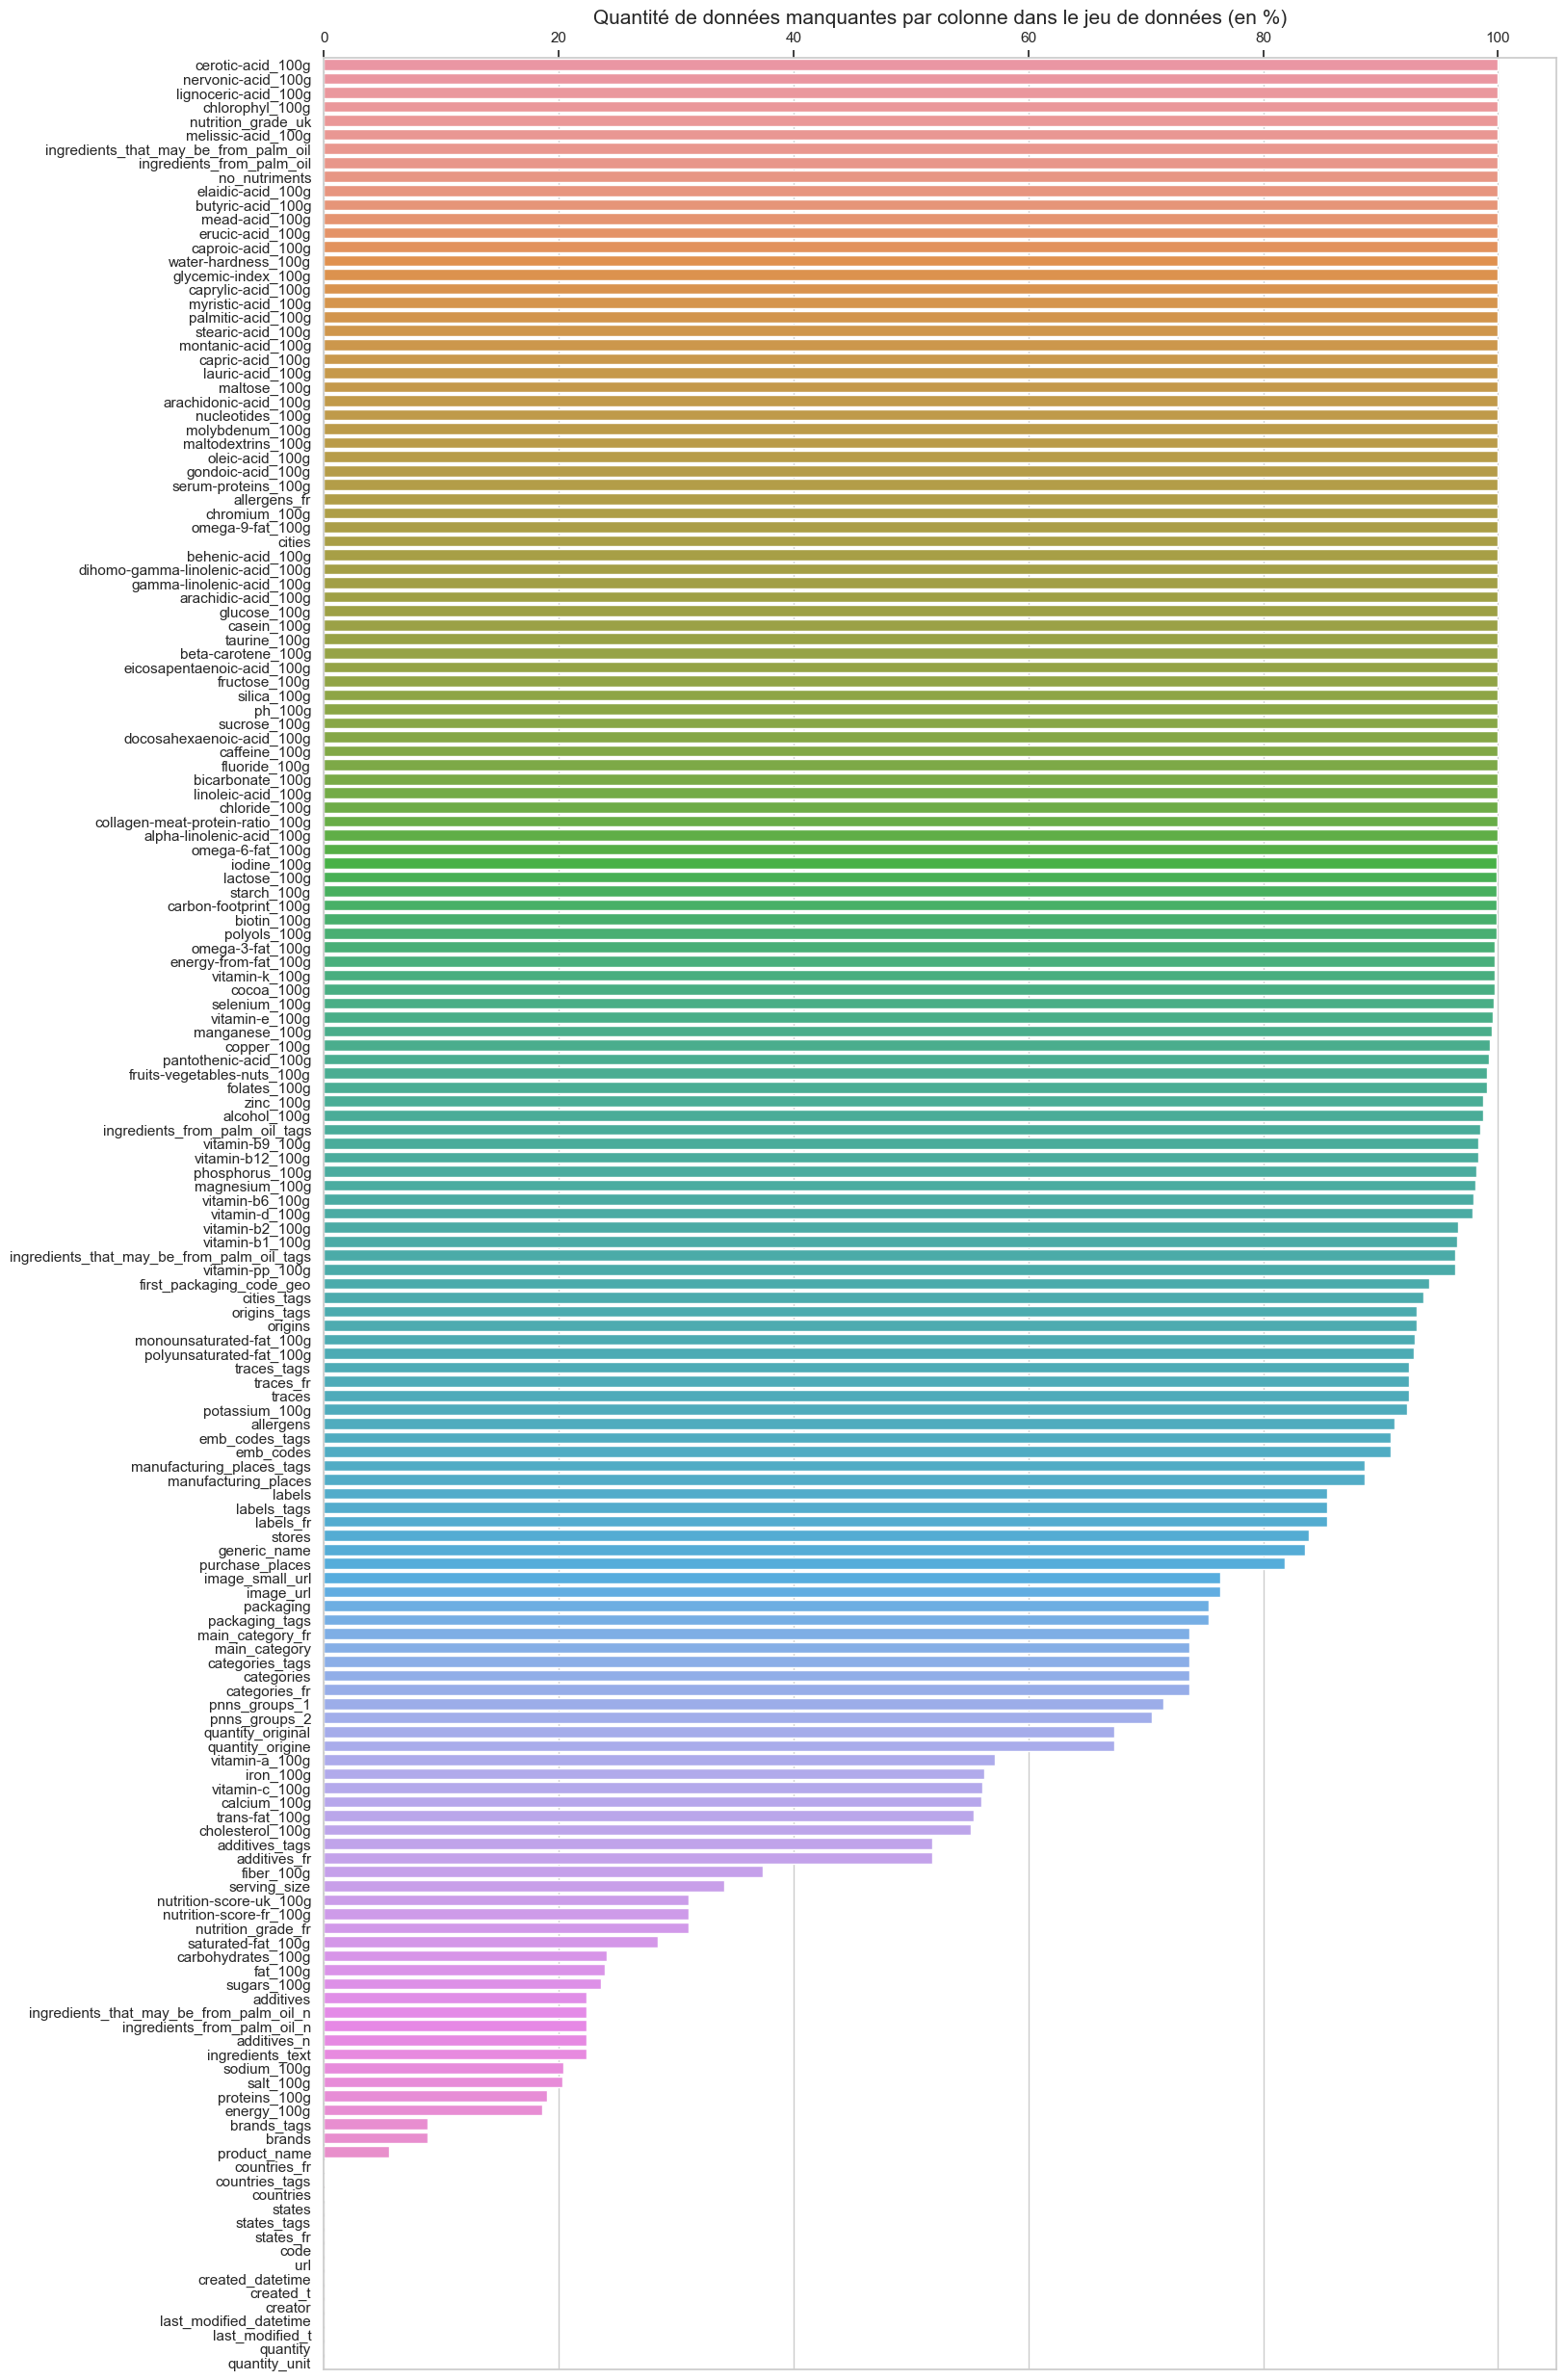

In [65]:
# Création d'une série contenant la proportion de NaN pour chaque colonne
proportion_nan = data.isna().sum().divide(data.shape[0]/100).sort_values(ascending=False)

# Configuration du style de la figure et définition de la taille
sns.set(style="whitegrid")
plt.figure(figsize=(16, 30))

# Création d'un graphique en barre avec la série précédente
ax = sns.barplot(y = proportion_nan.index, x=proportion_nan.values)

# Positionnement des étiquettes des axes des abscisses en haut de la figure
ax.xaxis.set_ticks_position('top')

# Définition du titre du graphique
plt.title('Quantité de données manquantes par colonne dans le jeu de données (en %)', size=15)

# Affichage du graphique
#plt.show()
#save_figure('Quantité de données manquantes par colonne dans le jeu de données (en %)')
save_figure_opt('Quantité de données manquantes par colonne dans le jeu de données (en %)', library='matplotlib')

Affiche la répartition des proportions de NaN dans un jeu de données. 
Création d'un histogramme avec les proportions de NaN en abscisse et la densité en ordonnée

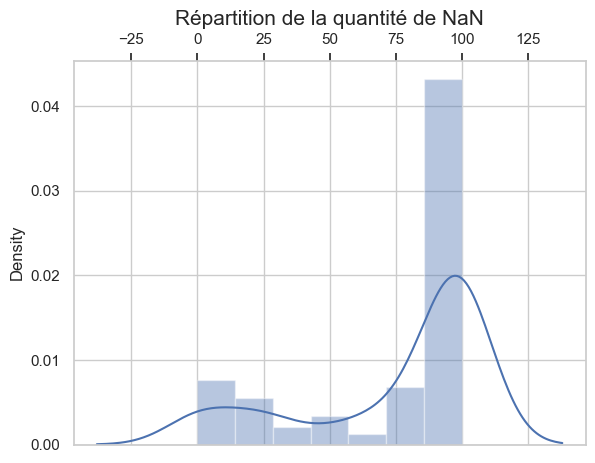

In [66]:
# Configuration du style du graphique avec Seaborn
sns.set(style="whitegrid")

# Création d'un histogramme avec la distribution des proportions de NaN
ax = sns.distplot(proportion_nan.values)

# Positionnement des étiquettes des axes des abscisses en haut de la figure
ax.xaxis.set_ticks_position('top')

# Définition du titre du graphique
plt.title('Répartition de la quantité de NaN', size=15)

# Affichage du graphique 
#plt.show()
#save_figure('Répartition de la quantité de NaN')
save_figure_opt('Répartition de la quantité de NaN', library='matplotlib')

In [67]:
df_sh = df.shape
df_sh
# Description générale du dataframe
desc = data.describe(include='all')

# Types et contenu des colonnes
desc_type = pd.DataFrame(data.dtypes, columns=['type']).T
nb_null = (df_sh[0]-desc.loc["count"].T)
pct_null = (df_sh[0]-desc.loc["count"].T)*100/df_sh[0]
desc_null = pd.DataFrame([nb_null, pct_null], index=['nb null','pct null'])

# Concaténation des statistiques générales, des types et des valeurs manquantes
desc = pd.concat([desc_type, desc_null, desc])
desc


code  \
type      object          
nb null   23.0            
pct null  0.00717         
count     320749          
unique    320749          
top       0000000003087   
freq      1               
mean      NaN             
std       NaN             
min       NaN             
25%       NaN             
50%       NaN             
75%       NaN             
max       NaN             

                                                                                                 url  \
type      object                                                                                       
nb null   23.0                                                                                         
pct null  0.00717                                                                                      
count     320749                                                                                       
unique    320749                                                                                       
top       http://world-fr.openfoodfacts.org/produit/0000000003087/farine-de-ble-noir-ferme-t-y-r-nao   
freq      1                                                                                            
mean      NaN                                                                                          
std       NaN                                                                                          
min       NaN                                                                                          
25%       NaN                                                                                          
50%       NaN                                                                                          
75%       NaN                                                                                          
max       NaN                                                                                          

                  creator   created_t      created_datetime last_modified_t  \
type      category         object      object                object           
nb null   2.0              3.0         9.0                   0.0              
pct null  0.000623         0.000935    0.002806              0.0              
count     320770           320769      320763                320772           
unique    3535             189567      189568                180495           
top       usda-ndb-import  1489077120  2017-03-09T10:37:09Z  1439141742       
freq      169868           20          20                    33               
mean      NaN              NaN         NaN                   NaN              
std       NaN              NaN         NaN                   NaN              
min       NaN              NaN         NaN                   NaN              
25%       NaN              NaN         NaN                   NaN              
50%       NaN              NaN         NaN                   NaN              
75%       NaN              NaN         NaN                   NaN              
max       NaN              NaN         NaN                   NaN              

         last_modified_datetime product_name  \
type      object                 object        
nb null   0.0                    17762.0       
pct null  0.0                    5.537266      
count     320772                 303010        
unique    180495                 221347        
top       2015-08-09T17:35:42Z   Ice Cream     
freq      33                     410           
mean      NaN                    NaN           
std       NaN                    NaN           
min       NaN                    NaN           
25%       NaN                    NaN           
50%       NaN                    NaN           
75%       NaN                    NaN           
max       NaN                    NaN           

                                                 generic_name  \
type      category                                              
nb null   26797

In [68]:
# Checking columns in df

for i, c in enumerate(data.columns):
    print('\n'+c if i % 6 == 0 else c, end=' | ')
total_columns = len(data.columns)
print(total_columns)   


code | url | creator | created_t | created_datetime | last_modified_t | 
last_modified_datetime | product_name | generic_name | quantity_original | packaging | packaging_tags | 
brands | brands_tags | categories | categories_tags | categories_fr | origins | 
origins_tags | manufacturing_places | manufacturing_places_tags | labels | labels_tags | labels_fr | 
emb_codes | emb_codes_tags | first_packaging_code_geo | cities | cities_tags | purchase_places | 
stores | countries | countries_tags | countries_fr | ingredients_text | allergens | 
allergens_fr | traces | traces_tags | traces_fr | serving_size | no_nutriments | 
additives_n | additives | additives_tags | additives_fr | ingredients_from_palm_oil_n | ingredients_from_palm_oil | 
ingredients_from_palm_oil_tags | ingredients_that_may_be_from_palm_oil_n | ingredients_that_may_be_from_palm_oil | ingredients_that_may_be_from_palm_oil_tags | nutrition_grade_uk | nutrition_grade_fr | 
pnns_groups_1 | pnns_groups_2 | states | states_tags 

In [69]:
print_null_pct(data)

nb of null:  39824542 
pct of null:  75.2


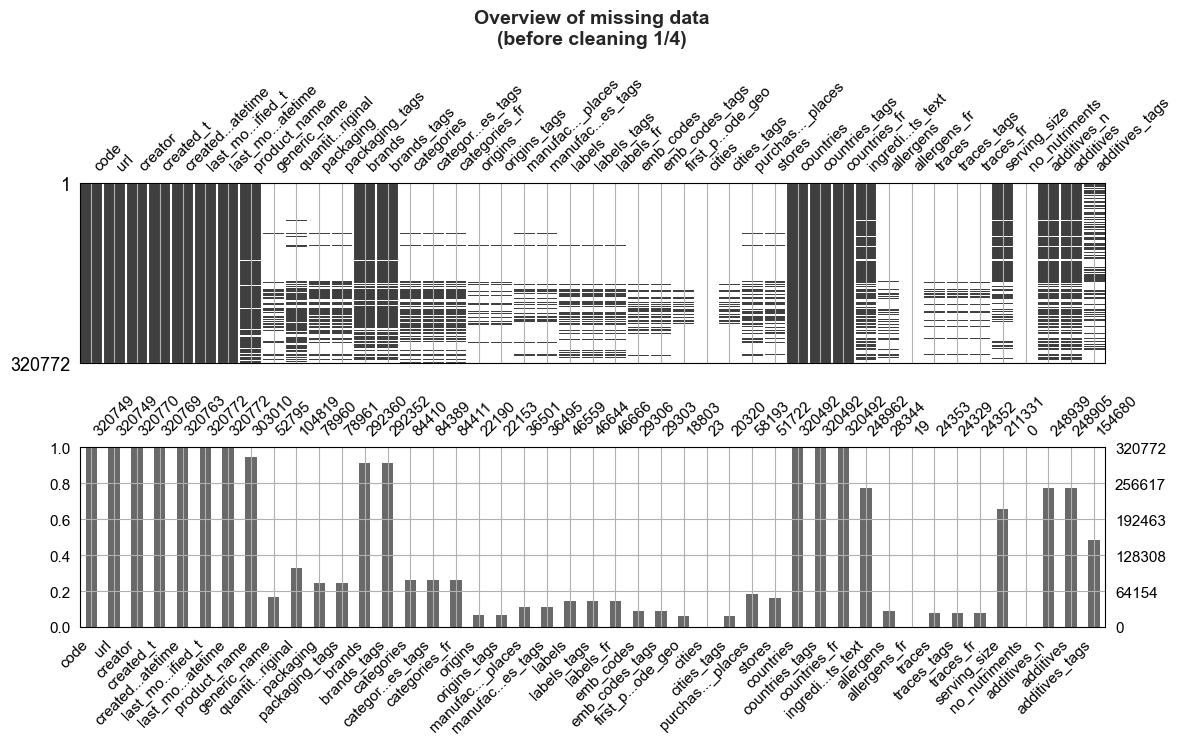

In [70]:
plot_export_missing(data, data.columns[0:45], 'C_0_3_missing_vals_1.png',
                    'Overview of missing data\n(before cleaning 1/4)',
                    shorten_label=True)

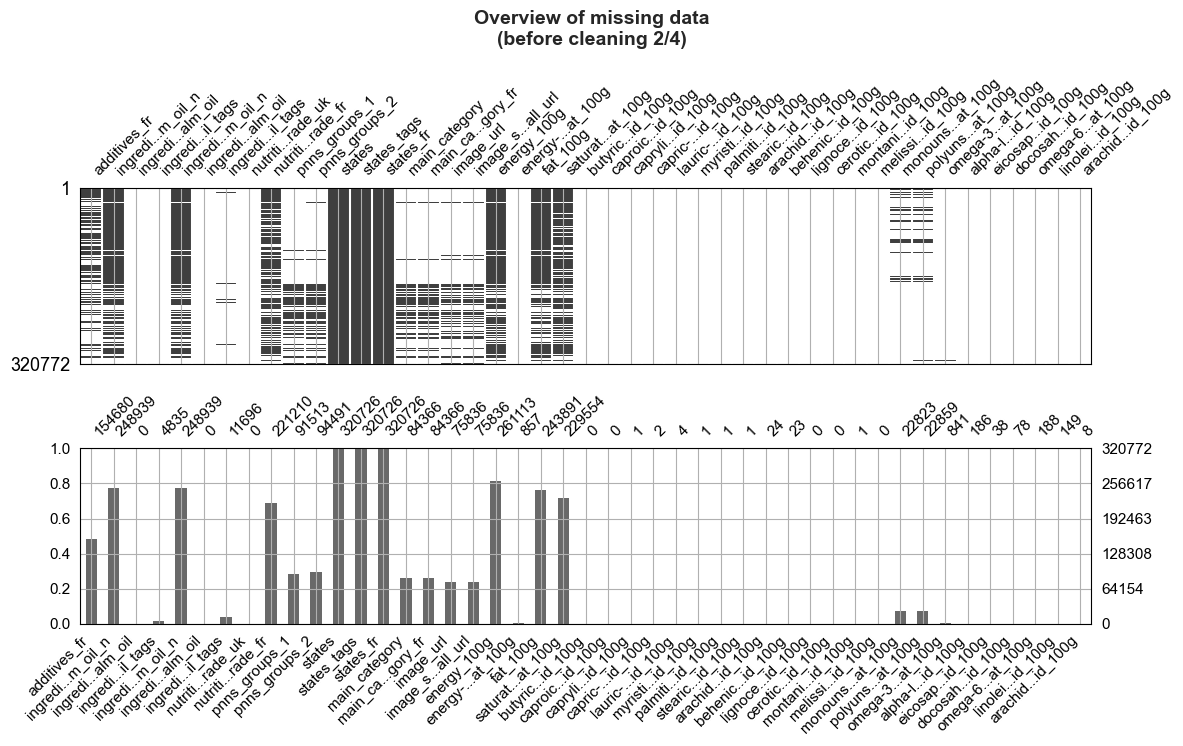

In [71]:
plot_export_missing(data, data.columns[45:90], 'C_0_3_missing_vals_2.png',
                    'Overview of missing data\n(before cleaning 2/4)',
                    shorten_label=True)

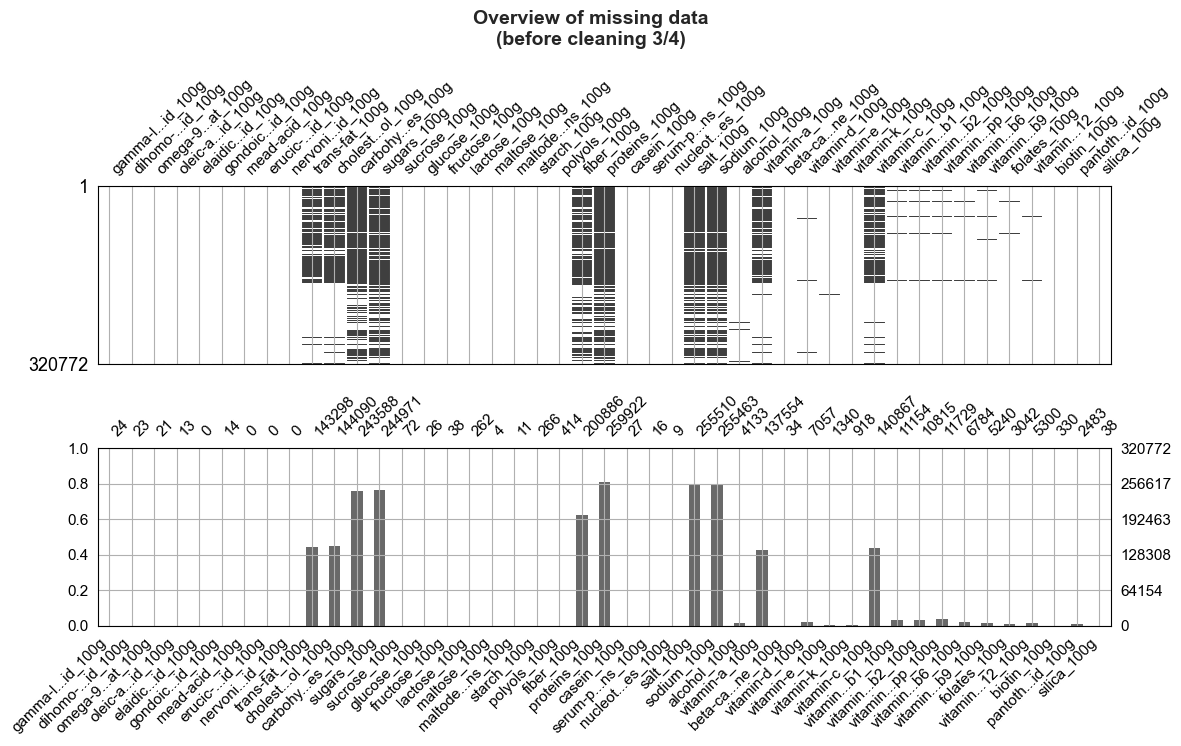

In [72]:
plot_export_missing(data, data.columns[90:135], 'C_0_3_missing_vals_3.png',
                    'Overview of missing data\n(before cleaning 3/4)',
                    shorten_label=True)

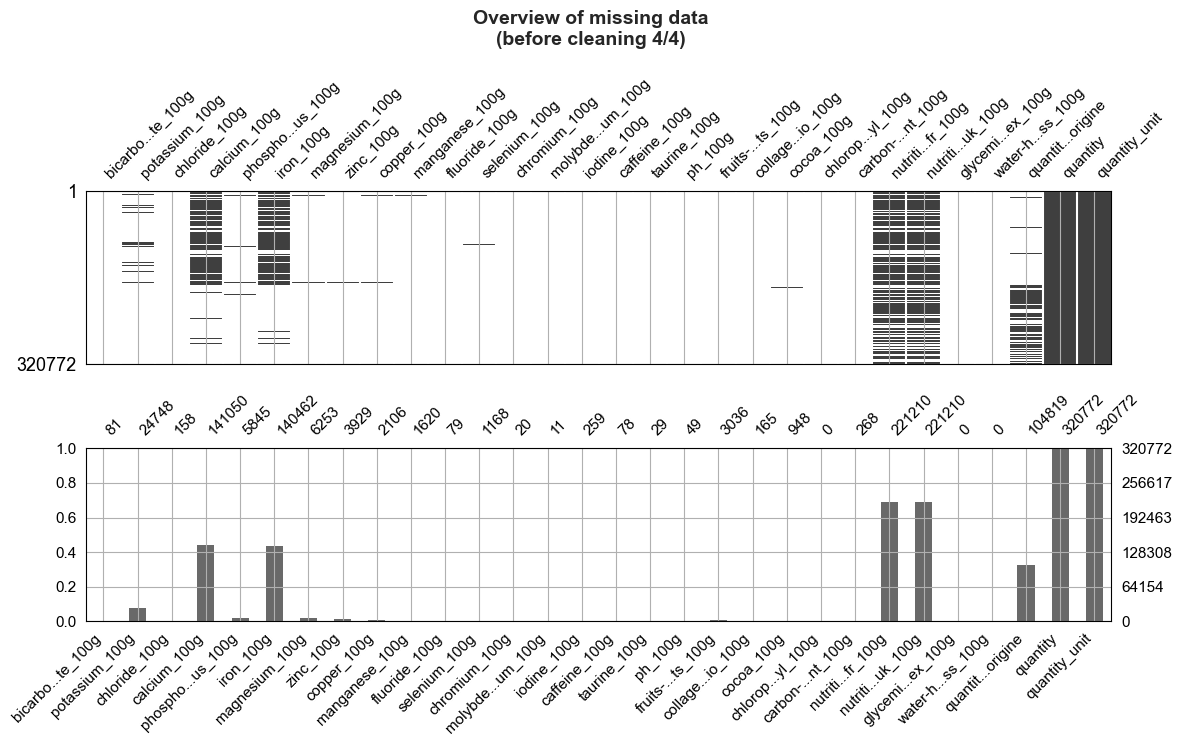

In [73]:
plot_export_missing(data, data.columns[135:181],'C_0_3_missing_vals_4.png',
                    'Overview of missing data\n(before cleaning 4/4)',
                    shorten_label=True)

### <a name="C261">2.6.1 - Conclusion</a>

- categorical and quantitative columns
- 165 columns, 320772 rows
- large number of missing data (75.2% of null, nombre de null:  39824542 )
- colonnes catégorielles et quantitatives
- 165 colonnes, 320772 lignes
- grand nombre de données manquantes (75.2% de null, nombre de null : 39824542 )

In [77]:
count_values = data["nutrition_grade_fr"].value_counts()
print(count_values)

d    62763
c    45538
e    43030
a    35634
b    34245
Name: nutrition_grade_fr, dtype: int64


## <a name="C27">2.7 - Traitement des outliers</a>

### Intuitions

Essayons 2 méthodes de traitement des outliers sur une feature de notre jeu de données:

In [78]:
def delete_outliers_std(dataframe):
    '''Suppression des outliers trop éloignés de la moyenne'''
    
    # Parcours des colonnes numériques de la dataframe
    for column in dataframe.select_dtypes(include = ['int8', 'float32','int32','float64']).columns.tolist() :
        
        # Remplacement des valeurs en dehors de 2 écart-types de la moyenne par NaN
        dataframe.loc[dataframe[column] > dataframe[column].mean() + 2 * dataframe[column].std()] = np.nan
        dataframe.loc[dataframe[column] < dataframe[column].mean() - 2 * dataframe[column].std()] = np.nan
        
        # Remplacement des valeurs négatives par NaN
        dataframe.loc[dataframe[column] < 0] = np.nan
        
    # Retourne la dataframe modifiée
    return dataframe
    
def delete_outliers_percentiles(dataframe):
    '''Suppression des outliers du centile extrême'''
    
    # Parcours des colonnes numériques de la dataframe
    for column in dataframe.select_dtypes(include = ['int8', 'float32','int32','float64']).columns.tolist() :
        
        # Remplacement des valeurs en dehors du 0.5% et 99.5% percentiles par NaN
        dataframe.loc[dataframe[column] > dataframe[column].quantile(0.95)] = np.nan
        dataframe.loc[dataframe[column] < dataframe[column].quantile(0.05)] = np.nan
        
        # Remplacement des valeurs négatives par NaN
        dataframe.loc[dataframe[column] < 0] = np.nan
    # Retourne la dataframe modifiée
    return dataframe

def delete_outliers_interquartile(dataframe):
    '''Suppression des outliers avec la méthode de l'intervalle interquartile'''
    
    # Parcours des colonnes numériques de la dataframe
    for column in dataframe.select_dtypes(include = ['int8', 'float32','int32','float64']).columns.tolist() :
        
        # Calcul des quartiles
        q1 = dataframe[column].quantile(0.05)
        q3 = dataframe[column].quantile(0.95)
        
        # Calcul de l'écart interquartile
        iqr = q3 - q1
        
        # Calcul des bornes de l'intervalle interquartile
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Remplacement des valeurs en dehors de l'intervalle par NaN
        dataframe.loc[dataframe[column] < lower_bound, column] = np.nan
        dataframe.loc[dataframe[column] > upper_bound, column] = np.nan
        
        # Remplacement des valeurs négatives par 0
        dataframe.loc[dataframe[column] < 0, column] = 0
        
        # Remplacement des valeurs supérieures à 100 par 100
        dataframe.loc[dataframe[column] > 100, column] = 100
        
    # Retourne la dataframe modifiée
    return dataframe


Création d'une copie du dataframe original et sélectionne uniquement les colonnes 'energy_100g' et 'salt_100g'. 
Ensuite, suppression des outliers des données de la colonne 'salt_100g' 
et stocke les résultats dans les variables 'salt_std' et 'salt_percentiles'.

In [79]:
#salt_std = delete_outliers_std(data.copy()[['energy_100g','salt_100g']])['salt_100g']
#salt_percentiles = delete_outliers_percentiles(data.copy()[['energy_100g','salt_100g']])['salt_100g']

# Copie du dataframe original et sélection des colonnes energy_100g et salt_100g
subset_data = data.copy()[['energy_100g','salt_100g']]

# Suppression des outliers avec la fonction delete_outliers_std pour la colonne salt_100g
# et récupération de cette colonne dans la variable salt_std
salt_std = delete_outliers_std(subset_data)['salt_100g']
# print('(subset_data) salt_std : ', salt_std )
# Suppression des outliers avec la fonction delete_outliers_percentiles pour la colonne salt_100g
# et récupération de cette colonne dans la variable salt_percentiles
salt_percentiles = delete_outliers_percentiles(subset_data)['salt_100g']
# print('(subset_data) salt_percentiles : ', salt_percentiles )
# Suppression des outliers avec la fonction delete_outliers_percentiles pour la colonne salt_100g
# et récupération de cette colonne dans la variable salt_percentiles
salt_quartiles = delete_outliers_interquartile(subset_data)['salt_100g']
# print('(subset_data) salt_quarcentiles : ', salt_quarcentiles )


In [80]:
print('(data)Moyenne de salt_100g : ',data['salt_100g'].mean())
print('(data)Ecart type de salt_100g : ',data['salt_100g'].std())
print('(subset_data) Moyenne de salt_100g : ',subset_data['salt_100g'].mean())
print('(subset_data)Ecart type de salt_100g : ',subset_data['salt_100g'].std())

(data)Moyenne de salt_100g :  2.028550148010254
(data)Ecart type de salt_100g :  128.26443481445312
(subset_data) Moyenne de salt_100g :  0.7743130326271057
(subset_data)Ecart type de salt_100g :  0.8159403204917908


Text(0.5, 1.0, 'Méthode par quartiles')

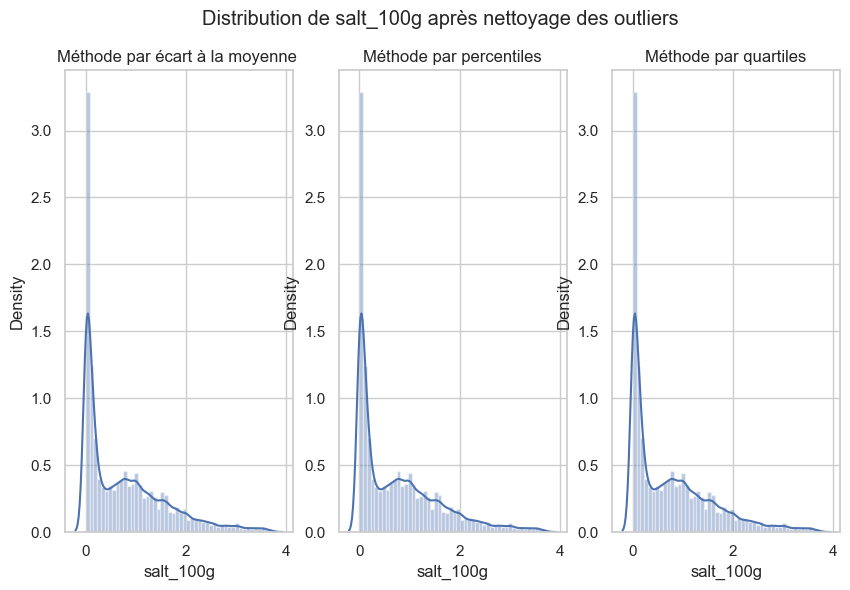

In [81]:
# création d'une figure contenant 2 sous-graphes côte-à-côte
f, axes = plt.subplots(1,3, figsize=(10,6))

# titre de la figure
f.suptitle("Distribution de salt_100g après nettoyage des outliers")

# création du premier sous-graphique représentant la distribution de salt_100g après nettoyage des outliers par la méthode de suppression par écart à la moyenne
ax1 = sns.distplot(salt_std.dropna(), ax=axes[0])
ax1.set_title("Méthode par écart à la moyenne ")

# création du deuxième sous-graphique représentant la distribution de salt_100g après nettoyage des outliers par la méthode de suppression par percentiles
ax2 = sns.distplot(salt_percentiles.dropna(), ax=axes[1])
ax2.set_title("Méthode par percentiles")

# création du deuxième sous-graphique représentant la distribution de salt_100g après nettoyage des outliers par la méthode de suppression par quartiles
ax3 = sns.distplot(salt_quartiles.dropna(), ax=axes[2])
ax3.set_title("Méthode par quartiles")


In [82]:
# Concaténation des valeurs de la standard deviation et de la colonne "salt_100g" dans une seule série
# et suppression des doublons pour obtenir une série des outliers identifiés par la méthode des écarts types
outliers_std = pd.concat([salt_std, data['salt_100g']]).drop_duplicates(keep=False)

# Concaténation des valeurs des percentiles et de la colonne "salt_100g" dans une seule série
# et suppression des doublons pour obtenir une série des outliers identifiés par la méthode des percentiles
outliers_percentiles = pd.concat([salt_percentiles, data['salt_100g']]).drop_duplicates(keep=False)

# Concaténation des valeurs des percentiles et de la colonne "salt_100g" dans une seule série
# et suppression des doublons pour obtenir une série des outliers identifiés par la méthode des quantiles
outliers_quantiles = pd.concat([salt_quartiles, data['salt_100g']]).drop_duplicates(keep=False)


In [83]:
print(outliers_std.shape)
print(outliers_percentiles.shape)
print(outliers_quantiles.shape)

(1181,)
(1181,)
(1181,)


La fonction présenté ci-après propose de supprimer le centile extrême, les valeurs supérieures à 100 g (pour les distributions en base 100 g), ainsi que les données trop éloignées de leurs voisins (distance de Minkowski)

### Fonction

Cette fonction supprime les outliers (valeurs extrêmes) du dataframe en excluant le centile le plus extrême, en supprimant les données négatives et les valeurs supérieures à 100 g pour les indices ramenés à 100 g.

In [84]:
# Importation de la fonction KDTree de la bibliothèque sklearn.neighbors
from sklearn.neighbors import KDTree

# Fonction pour supprimer les valeurs extrêmes du dataset
def delete_univariate_outliers(dataframe):
    '''
    Suppression des valeurs extrêmes du dataset - on exclut le centile le plus extrême
    Suppression des données négatives et des valeurs supérieures à 100 g pour les indices ramenés à 100 g
    '''

    # Boucle sur les colonnes de type 'int32' et 'float64'
    for column in dataframe.select_dtypes(include = ['int8', 'float32','int32','float64']).columns.tolist() :
        # Initialisation de deux listes pour stocker les index des valeurs extrêmes et des valeurs nulles
        index_nan = []
        index_nan_flat = []
        
        # Récupération des index des valeurs extrêmes en utilisant la méthode des quantiles
        index_nan.append(dataframe.loc[dataframe[column] > dataframe[column].quantile(0.995)].index.tolist())
        index_nan.append(dataframe.loc[dataframe[column] < dataframe[column].quantile(0.005)].index.tolist())
        # Récupération des index des valeurs négatives
        index_nan.append(dataframe.loc[dataframe[column] < 0].index.tolist())
        # Pour les colonnes qui représentent des quantités en grammes, récupération des index des valeurs supérieures à 100 g
        if (column[-5:] == '_100g') & (column != 'energy_100g'):
            index_nan.append(dataframe.loc[dataframe[column] > 100].index.tolist())
            
        # Parcours des listes des index des valeurs extrêmes et des valeurs nulles pour les stocker dans une seule liste
        for sublist in index_nan:
            for item in sublist:
                index_nan_flat.append(item)
                
        # Suppression des doublons dans la liste des index
        index_nan_flat = list(dict.fromkeys(index_nan_flat))
        # Remplacement des valeurs extrêmes par NaN
        dataframe[column].loc[index_nan_flat] = np.nan
            
    # Affichage du nombre de valeurs NaN dans le dataset
    print("(fonction delete_univariate_outliers) Affichage du nombre de valeurs NaN dans le dataset : ")
    print_control_shape_nan(dataframe)
            
    return dataframe



Cette fonction supprime les outliers multivariés d'un dataset en utilisant la distance de Minkowski des 3 plus proches voisins de chaque observation.

In [85]:
# Fonction pour supprimer les outliers multivariés
def delete_multivariate_outliers(dataframe):
    '''Suppression des outliers éloignés de leurs plus proches voisins (discrimination du centile 
    le plus éloigné par la distance de minkowski de chaque observation à ses 3 plus proches voisins)'''

    # Sélection des colonnes numériques et suppression des NaN
    # Copie des données numériques du dataset et suppression des lignes qui contiennent des valeurs nulles
    numeric_data = dataframe.select_dtypes(['int8', 'float32','int32', 'float64']).copy().dropna(axis=0).dropna(axis=1)
    
    # Contrôle de la forme initiale du dataset
    print_control_shape_nan(dataframe)
    
    try:
        # Calcul des distances de Minkowski des 3 plus proches voisins pour chaque observation
        # Création d'un arbre de recherche KDTree pour les données numériques
        kdt = KDTree(numeric_data, leaf_size = 40, metric='minkowski')
        dist, ind = kdt.query(numeric_data, k=3, return_distance=True)
    
        # Ajout d'une colonne pour stocker la somme des distances de chaque observation à ses 3 plus proches voisins
        # Calcul de la distance de Minkowski pour chaque observation et stockage dans une nouvelle colonne
        numeric_data['3N_distance'] = np.sum(dist, axis=1) 
        
        # Suppression des observations dont la somme des distances est supérieure au 99ème centile
        numeric_data = numeric_data[numeric_data['3N_distance'] < numeric_data['3N_distance'].quantile(0.99)]
        
        # Récupération des indices des observations à supprimer dans le dataset initial
        index_to_drop = numeric_data.index.tolist()
        
        # Suppression des observations correspondantes dans le dataset initial
        dataframe = dataframe.drop(index_to_drop, axis=0)
    except ValueError:
        print('.........oops : trop de NaN dans le jeu de données, calcul de distance impossible')

    # Contrôle de la forme du dataset après suppression des outliers multivariés
    print("(fonction delete_multivariate_outliers) Affichage du nombre de valeurs NaN dans le dataset : ")
    print_control_shape_nan(dataframe)
    
    return dataframe


In [86]:
from sklearn.covariance import EllipticEnvelope
import pandas as pd

def delete_multivariate_outliers_elliptic(dataframe):
    '''
    Supprime les outliers multivariés d'un DataFrame en utilisant la méthode de l'enveloppe elliptique.
    L'enveloppe elliptique est une méthode statistique de détection des valeurs aberrantes dans un ensemble 
    de données multivariées. Elle consiste à estimer la matrice de covariance de l'ensemble de données et à calculer 
    les ellipses correspondantes aux niveaux de confiance choisis. Les observations qui se trouvent en dehors 
    de ces ellipses sont considérées comme des valeurs aberrantes et peuvent être éliminées ou traitées en conséquence.
    Args:
        dataframe (DataFrame): le DataFrame à nettoyer
    
    Returns:
        DataFrame: la DataFrame nettoyée
    '''
    # Suppression des colonnes non numériques
    num_cols = dataframe.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns
    dataframe = dataframe[num_cols]
    
    # Création d'un modèle d'enveloppe elliptique
    model = EllipticEnvelope()
    
    # Entraînement du modèle
    model.fit(dataframe)
    
    # Identification des outliers
    outliers = model.predict(dataframe) == -1
    
    # Remplacement des outliers par NaN
    dataframe[outliers] = np.nan
    
    return dataframe


In [87]:
def delete_outliers(dataframe):
    # Affichage de l'étape en cours
    print('........Suppression des outliers univariés')
    # Suppression des outliers univariés
    dataframe = delete_univariate_outliers(dataframe)
    # Affichage de l'étape en cours
    print('........Suppression des outliers multivariés')
    # Suppression des outliers multivariés
    dataframe = delete_multivariate_outliers(dataframe)
#     print('........Suppression des outliers multivariés (delete_multivariate_outliers_elliptic)')
    # Suppression des outliers multivariés
#     dataframe = delete_multivariate_outliers_elliptic(dataframe)    
    # Retour du dataframe nettoyé
    return dataframe


In [88]:
def delete_outliers_simple(dataframe):
#     dataframe = delete_outliers_std(dataframe)

#     dataframe = delete_outliers_percentiles(dataframe)
    print('........Suppression des outliers simple (delete_outliers_simple)')
    dataframe = delete_outliers_interquartile(dataframe)

    return dataframe

In [89]:
a = clean_nan(data.head(10000).copy(), taux_nan_max = 0.80)

Nombre de colonnes supprimées : 121


In [90]:
delete_multivariate_outliers(a)

........Proportion de NaN : 8.0 %, Taille du jeu de données : (10000, 44)

(fonction delete_multivariate_outliers) Affichage du nombre de valeurs NaN dans le dataset : 
........Proportion de NaN : 25.0 %, Taille du jeu de données : (2890, 44)



code  \
0     0000000003087   
3     0000000016087   
4     0000000016094   
5     0000000016100   
6     0000000016117   
...             ...   
9984  0011822552561   
9985  0011822552578   
9989  0011822555418   
9990  0011822555425   
9991  0011822562560   

                                                                                                                              url  \
0     http://world-fr.openfoodfacts.org/produit/0000000003087/farine-de-ble-noir-ferme-t-y-r-nao                                    
3     http://world-fr.openfoodfacts.org/produit/0000000016087/organic-salted-nut-mix-grizzlies                                      
4     http://world-fr.openfoodfacts.org/produit/0000000016094/organic-polenta-bob-s-red-mill                                        
5     http://world-fr.openfoodfacts.org/produit/0000000016100/breadshop-honey-gone-nuts-granola-unfi                                
6     http://world-fr.openfoodfacts.org/produit/0000000016117/organic-long-grain-white-rice-lundberg                                
...                                                                                              ...                                
9984  http://world-fr.openfoodfacts.org/produit/0011822552561/flavored-seltzer-lemon-lime-big-win                                   
9985  http://world-fr.openfoodfacts.org/produit/0011822552578/sparkling-seltzer-original-big-win                                    
9989  http://world-fr.openfoodfacts.org/produit/0011822555418/refreshing-lemonade-made-with-real-fruit-juice-rite-aid-corporation   
9990  http://world-fr.openfoodfacts.org/produit/0011822555425/lemonade-strawberry-big-win                                           
9991  http://world-fr.openfoodfacts.org/produit/0011822562560/rite-aid-seltzer-water-lemon-lime-rite-aid-corporation                

                         creator   created_t      created_datetime  \
0     openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
3     usda-ndb-import             1489055731  2017-03-09T10:35:31Z   
4     usda-ndb-import             1489055653  2017-03-09T10:34:13Z   
5     usda-ndb-import             1489055651  2017-03-09T10:34:11Z   
6     usda-ndb-import             1489055730  2017-03-09T10:35:30Z   
...               ...                    ...                   ...   
9984  usda-ndb-import             1489071875  2017-03-09T15:04:35Z   
9985  usda-ndb-import             1489073143  2017-03-09T15:25:43Z   
9989  usda-ndb-import             1489073143  2017-03-09T15:25:43Z   
9990  usda-ndb-import             1489074431  2017-03-09T15:47:11Z   
9991  usda-ndb-import             1489075847  2017-03-09T16:10:47Z   

     last_modified_t last_modified_datetime  \
0     1474103893      2016-09-17T09:18:13Z    
3     1489055731      2017-03-09T10:35:31Z    
4     1489055653      2017-03-09T10:34:13Z    
5     1489055651      2017-03-09T10:34:11Z    
6     1489055730      2017-03-09T10:35:30Z    
...          ...                       ...    
9984  1489071875      2017-03-09T15:04:35Z    
9985  1489073143      2017-03-09T15:25:43Z    
9989  1489073144      2017-03-09T15:25:44Z    
9990  1489074431      2017-03-09T15:47:11Z    
9991  1489075847      2017-03-09T16:10:47Z    

                                        product_name  \
0     Farine de blé noir                               
3     Organic Salted Nut Mix                           
4     Organic Polenta                                  
5     Breadshop Honey Gone Nuts Granola                
6     Organic Long Grain White Rice                    
...                             ...                    
9984  Flavored Seltzer, Lemon Lime                     
9985  Sparkling Seltzer Original                       
9989  Refreshing Lemonade Made With Real Fruit Juice   
9990  Lemonade, Strawberry                             
9991  Rite Aid, Seltzer Water, Lemon & Lime            

                              brands                   brands_

## <a name="C28">2.8 - Imputation des NaN par méthodes des kNN</a>

### Intuition et test (voir fonction au chapitre suivant)

In [91]:
# Sélectionne les 10000 premières lignes de la copie du dataframe original "data"
# Supprime toutes les colonnes contenant plus de 80% de valeurs manquantes
data_test = clean_nan(data.copy().head(10000), 0.80)


Nombre de colonnes supprimées : 121


In [92]:
(data_test.head(100))

code  \
0   0000000003087   
1   0000000004530   
2   0000000004559   
3   0000000016087   
4   0000000016094   
5   0000000016100   
6   0000000016117   
7   0000000016124   
8   0000000016193   
9   0000000016513   
10  0000000016612   
11  0000000016650   
12  0000000016872   
13  0000000016933   
14  0000000017497   
15  0000000018012   
16  0000000018050   
17  0000000018173   
18  0000000018197   
19  0000000018227   
20  0000000018265   
21  0000000018289   
22  0000000018319   
23  0000000018340   
24  0000000018357   
25  0000000018371   
26  0000000018388   
27  0000000018395   
28  0000000018401   
29  0000000018418   
30  0000000018449   
31  0000000018456   
32  0000000018500   
33  0000000018517   
34  0000000018524   
35  0000000018555   
36  0000000018562   
37  0000000018579   
38  0000000018630   
39  0000000018708   
40  0000000018753   
41  0000000018760   
42  0000000018869   
43  0000000018883   
44  0000000018937   
45  0000000018944   
46  0000000024600   
47  0000000027083   
48  0000000027205   
49  0000000030038   
50  0000000030540   
51  0000000030557   
52  0000000030564   
53  0000000030571   
54  0000000030595   
55  0000000030625   
56  0000000030649   
57  0000000030717   
58  0000000030724   
59  0000000031097   
60  0000000031141   
61  0000000031172   
62  0000000031233   
63  0000000031288   
64  0000000032070   
65  0000000032117   
66  0000000032384   
67  0000000032858   
68  0000000032896   
69  0000000033015   
70  0000000033060   
71  0000000033084   
72  0000000033268   
73  0000000033503   
74  0000000033572   
75  0000000033589   
76  0000000033626   
77  0000000033640   
78  0000000033657   
79  0000000033664   
80  0000000033688   
81  0000000034135   
82  0000000034142   
83  0000000034241   
84  0000000034265   
85  0000000034425   
86  0000000034432   
87  0000000034449   
88  0000000034456   
89  0000000034470   
90  0000000034548   
91  0000000034562   
92  0000000034623   
93  0000000034715   
94  0000000034784   
95  0000000034791   
96  0000000035071   
97  0000000035170   
98  0000000035279   
99  0000000035286   

                                                                                                                         url  \
0   http://world-fr.openfoodfacts.org/produit/0000000003087/farine-de-ble-noir-ferme-t-y-r-nao                                 
1   http://world-fr.openfoodfacts.org/produit/0000000004530/banana-chips-sweetened-whole                                       
2   http://world-fr.openfoodfacts.org/produit/0000000004559/peanuts-torn-glasser                                               
3   http://world-fr.openfoodfacts.org/produit/0000000016087/organic-salted-nut-mix-grizzlies                                   
4   http://world-fr.openfoodfacts.org/produit/0000000016094/organic-polenta-bob-s-red-mill                                     
5   http://world-fr.openfoodfacts.org/produit/0000000016100/breadshop-honey-gone-nuts-granola-unfi                             
6   http://world-fr.openfoodfacts.org/produit/0000000016117/organic-long-grain-white-rice-lundberg                             
7   http://world-fr.openfoodfacts.org/produit/0000000016124/organic-muesli-daddy-s-muesli                                      
8   http://world-fr.openfoodfacts.org/produit/0000000016193/organic-dark-chocolate-minis-equal-exchange                        
9   http://world-fr.openfoodfacts.org/produit/0000000016513/organic-sunflower-oil-napa-valley-naturals                         
10  http://world-fr.openfoodfacts.org/produit/0000000016612/organic-adzuki-beans-unfi                                          
11  http://world-fr.openfoodfacts.org/produit/0000000016650/organic-penne-pasta-gardentime                                     
12  http://world-fr.openfoodfacts.org/produit/0000000016872/zen-party-mix-sunridge                                             
13  http://world-fr.openfoodfacts.org/produit/0000000016933/organic-golden-flax-seeds-unfi         

In [93]:
# Sélectionne les colonnes numériques du DataFrame data_test
# Extraction des colonnes numériques du jeu de données `data_test`
numeric_columns = data_test.select_dtypes(['int32', 'float64','int8', 'float32']).columns

# Affiche les noms des colonnes numériques
numeric_columns


Index(['additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'calcium_100g', 'iron_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'quantity'],
      dtype='object')

In [94]:
# Extraction des données numériques du jeu de données `data_test` pour les colonnes numériques
data_test[numeric_columns]


additives_n  ingredients_from_palm_oil_n  \
0    NaN          NaN                            
1     0.0          0.0                           
2     0.0          0.0                           
3     0.0          0.0                           
4     0.0          0.0                           
...   ...          ...                           
9995  3.0          0.0                           
9996  2.0          0.0                           
9997  5.0          0.0                           
9998  3.0          0.0                           
9999  3.0          0.0                           

      ingredients_that_may_be_from_palm_oil_n  energy_100g   fat_100g  \
0    NaN                                      NaN          NaN          
1     0.0                                      2243.0       28.570000   
2     0.0                                      1941.0       17.860001   
3     0.0                                      2540.0       57.139999   
4     0.0                                      1552.0       1.430000    
...   ...                                         ...            ...    
9995  0.0                                      937.0        11.940000   
9996  0.0                                      937.0        11.940000   
9997  1.0                                      937.0        14.930000   
9998  0.0                                      849.0        10.140000   
9999  0.0                                      937.0        11.940000   

      saturated-fat_100g  trans-fat_100g  cholesterol_100g  \
0    NaN                 NaN             NaN                 
1     28.57               0.00            0.018              
2     0.00                0.00            0.000              
3     5.36               NaN             NaN                 
4    NaN                 NaN             NaN                 
...   ..                  ..              ..                 
9995  8.96                0.00            0.037              
9996  7.46                0.75            0.037              
9997  7.46                0.00            0.037              
9998  7.25                0.00            0.036              
9999  7.46                0.00            0.037              

      carbohydrates_100g  sugars_100g  fiber_100g  proteins_100g  salt_100g  \
0    NaN                 NaN          NaN         NaN            NaN          
1     64.290001           14.290000    3.6         3.570000       0.00000     
2     60.709999           17.860001    7.1         17.860001      0.63500     
3     17.860001           3.570000     7.1         17.860001      1.22428     
4     77.139999          NaN           5.7         8.570000      NaN          
...         ...           ..           ...              ...       ..          
9995  23.879999           19.400000    0.0         4.480000       0.24638     
9996  25.370001           20.900000    0.0         4.480000       0.32258     
9997  20.900000           17.910000    0.0         4.480000       0.22860     
9998  24.639999           21.740000    0.0         2.900000       0.22098     
9999  25.370001           22.389999    0.0         4.480000       0.22860     

      sodium_100g  vitamin-a_100g  vitamin-c_100g  calcium_100g  iron_100g  \
0    NaN          NaN             NaN             NaN           NaN          
1     0.000        0.000000        0.0214          0.000         0.00129     
2     0.250        0.000000        0.0000          0.071         0.00129     
3     0.482       NaN             NaN              0.143         0.00514     
4    NaN          NaN             NaN             NaN           NaN          
...   ..           ..              ..              ..            ..          
9995  0.097        0.000090        0.0000          0.149         0.00000     
9996  0.127        0.000090        0.0000          0.149         0.00000     
9997  0.090        0.000134        0.0000          0.149         0.00000     
9998  0.087        0.000131        0.0000          0.1

In [95]:
# Suppression de toutes les lignes qui contiennent des valeurs manquantes (NaN)
# dans le jeu de données "data_test"
data_test.dropna(axis=0)
#dropna() permet de supprimer les lignes ou les colonnes contenant des valeurs manquantes (NaN). 
#L'argument axis=0 spécifie que les lignes contenant des NaN seront supprimées, 
#alors que axis=1 permet de supprimer les colonnes contenant des NaN.

code  \
80    0000000033688   
147   0000000045292   
150   0000000045421   
151   0000000045483   
180   0000001938067   
...             ...   
9995  0011822583220   
9996  0011822583237   
9997  0011822583244   
9998  0011822583251   
9999  0011822583268   

                                                                                                              url  \
80    http://world-fr.openfoodfacts.org/produit/0000000033688/peanuts-mixed-nuts-northgate-market                   
147   http://world-fr.openfoodfacts.org/produit/0000000045292/turkish-apricots-northgate                            
150   http://world-fr.openfoodfacts.org/produit/0000000045421/chili-mango-torn-glasses                              
151   http://world-fr.openfoodfacts.org/produit/0000000045483/milk-chocolate-pretzels-torn-glasser                  
180   http://world-fr.openfoodfacts.org/produit/0000001938067/chaussons-tresses-aux-pommes-kirkland-signature       
...                                                                                                       ...       
9995  http://world-fr.openfoodfacts.org/produit/0011822583220/thrifty-ice-cream-mint-n-chip-rite-aid-corporation    
9996  http://world-fr.openfoodfacts.org/produit/0011822583237/thrifty-ice-cream-rite-aid-corporation                
9997  http://world-fr.openfoodfacts.org/produit/0011822583244/thrifty-ice-cream-butter-pecan-rite-aid-corporation   
9998  http://world-fr.openfoodfacts.org/produit/0011822583251/thrifty-ice-cream-vanilla-rite-aid-corporation        
9999  http://world-fr.openfoodfacts.org/produit/0011822583268/thirfty-ice-cream-vanilla-rite-aid-corporation        

              creator   created_t      created_datetime last_modified_t  \
80    usda-ndb-import  1489050424  2017-03-09T09:07:04Z  1489050424       
147   usda-ndb-import  1489069958  2017-03-09T14:32:38Z  1489069958       
150   usda-ndb-import  1489069957  2017-03-09T14:32:37Z  1489069957       
151   usda-ndb-import  1489050424  2017-03-09T09:07:04Z  1489050424       
180   b7               1484501528  2017-01-15T17:32:08Z  1484504972       
...   ..                      ...                   ...         ...       
9995  usda-ndb-import  1489090347  2017-03-09T20:12:27Z  1489090347       
9996  usda-ndb-import  1489090348  2017-03-09T20:12:28Z  1489090348       
9997  usda-ndb-import  1489090348  2017-03-09T20:12:28Z  1489090348       
9998  usda-ndb-import  1489090348  2017-03-09T20:12:28Z  1489090349       
9999  usda-ndb-import  1489090349  2017-03-09T20:12:29Z  1489090349       

     last_modified_datetime                      product_name  \
80    2017-03-09T09:07:04Z   Peanuts, Mixed Nuts                
147   2017-03-09T14:32:38Z   Turkish Apricots                   
150   2017-03-09T14:32:37Z   Chili Mango                        
151   2017-03-09T09:07:04Z   Milk Chocolate Pretzels            
180   2017-01-15T18:29:32Z   Chaussons tressés aux pommes       
...                    ...                            ...       
9995  2017-03-09T20:12:27Z   Thrifty, Ice Cream, Mint N' Chip   
9996  2017-03-09T20:12:28Z   Thrifty, Ice Cream                 
9997  2017-03-09T20:12:28Z   Thrifty, Ice Cream, Butter Pecan   
9998  2017-03-09T20:12:29Z   Thrifty, Ice Cream, Vanilla        
9999  2017-03-09T20:12:29Z   Thirfty, Ice Cream, Vanilla        

                    brands           brands_tags countries    countries_tags  \
80    Northgate Market      northgate-market      US        en:united-states   
147   Northgate             northgate             US        en:united-states   
150   Torn & Glasses        torn-glasses          US        en:united-states   
151   Torn & Glasser        torn-glasser          US        en:united-states   
180   Kirkland Signature    kirkland-signature    Canada    en:canada          
...                  ...                   ...       ...          ...          
9995  Rite Aid Corporation  rite-aid-corporation  US        en:united-states   
9996  Rite 

In [96]:
#data_test[data_test['calcium_100g'].isna()].index
# Obtention des index des lignes qui ont des valeurs manquantes dans la colonne 'calcium_100g'
# en utilisant la méthode isna() de pandas pour vérifier si la valeur est manquante ou non
# et en sélectionnant seulement les index de ces lignes avec l'attribut index de pandas
index_missing_calcium = data_test[data_test['calcium_100g'].isna()].index
print(index_missing_calcium)

Int64Index([   0,    4,    9,   11,   14,   15,   17,   18,   25,   30,
            ...
            9967, 9968, 9971, 9975, 9976, 9984, 9985, 9989, 9990, 9991],
           dtype='int64', length=2280)


In [97]:
# Calcul du nombre de valeurs manquantes dans la colonne 'calcium_100g'
# Retourne le nombre total de valeurs manquantes dans la colonne 'calcium_100g'
data_test['calcium_100g'].isna().sum() 


2280

In [98]:
# Récupération des index des lignes où la colonne 'calcium_100g' est manquante
index_to_fill = data_test[data_test['calcium_100g'].isna()].index
print(index_to_fill)

Int64Index([   0,    4,    9,   11,   14,   15,   17,   18,   25,   30,
            ...
            9967, 9968, 9971, 9975, 9976, 9984, 9985, 9989, 9990, 9991],
           dtype='int64', length=2280)


In [99]:
#data_test[numeric_columns].iloc[index_to_fill[0],:]
# Cette ligne de code permet de sélectionner les colonnes numériques de la DataFrame data_test.
#numeric_columns = data_test.select_dtypes(['int32','float64']).columns

# Cette ligne de code permet de sélectionner toutes les lignes de la DataFrame data_test et de supprimer celles qui contiennent des valeurs manquantes.
#data_test.dropna(axis=0)

# Cette ligne de code permet de sélectionner toutes les lignes de la DataFrame data_test qui ont une valeur manquante pour la colonne 'calcium_100g', et de récupérer les index correspondants.
#index_to_fill = data_test[data_test['calcium_100g'].isna()].index

# Cette ligne de code permet de sélectionner les valeurs de la première ligne correspondant aux colonnes numériques de la DataFrame data_test.
data_test[numeric_columns].iloc[index_to_fill[1],:]


additives_n                                0.000000   
ingredients_from_palm_oil_n                0.000000   
ingredients_that_may_be_from_palm_oil_n    0.000000   
energy_100g                                1552.000000
fat_100g                                   1.430000   
saturated-fat_100g                        NaN         
trans-fat_100g                            NaN         
cholesterol_100g                          NaN         
carbohydrates_100g                         77.139999  
sugars_100g                               NaN         
fiber_100g                                 5.700000   
proteins_100g                              8.570000   
salt_100g                                 NaN         
sodium_100g                               NaN         
vitamin-a_100g                            NaN         
vitamin-c_100g                            NaN         
calcium_100g                              NaN         
iron_100g                                 NaN         
nutrition-

In [100]:
data_test[numeric_columns]

additives_n  ingredients_from_palm_oil_n  \
0    NaN          NaN                            
1     0.0          0.0                           
2     0.0          0.0                           
3     0.0          0.0                           
4     0.0          0.0                           
...   ...          ...                           
9995  3.0          0.0                           
9996  2.0          0.0                           
9997  5.0          0.0                           
9998  3.0          0.0                           
9999  3.0          0.0                           

      ingredients_that_may_be_from_palm_oil_n  energy_100g   fat_100g  \
0    NaN                                      NaN          NaN          
1     0.0                                      2243.0       28.570000   
2     0.0                                      1941.0       17.860001   
3     0.0                                      2540.0       57.139999   
4     0.0                                      1552.0       1.430000    
...   ...                                         ...            ...    
9995  0.0                                      937.0        11.940000   
9996  0.0                                      937.0        11.940000   
9997  1.0                                      937.0        14.930000   
9998  0.0                                      849.0        10.140000   
9999  0.0                                      937.0        11.940000   

      saturated-fat_100g  trans-fat_100g  cholesterol_100g  \
0    NaN                 NaN             NaN                 
1     28.57               0.00            0.018              
2     0.00                0.00            0.000              
3     5.36               NaN             NaN                 
4    NaN                 NaN             NaN                 
...   ..                  ..              ..                 
9995  8.96                0.00            0.037              
9996  7.46                0.75            0.037              
9997  7.46                0.00            0.037              
9998  7.25                0.00            0.036              
9999  7.46                0.00            0.037              

      carbohydrates_100g  sugars_100g  fiber_100g  proteins_100g  salt_100g  \
0    NaN                 NaN          NaN         NaN            NaN          
1     64.290001           14.290000    3.6         3.570000       0.00000     
2     60.709999           17.860001    7.1         17.860001      0.63500     
3     17.860001           3.570000     7.1         17.860001      1.22428     
4     77.139999          NaN           5.7         8.570000      NaN          
...         ...           ..           ...              ...       ..          
9995  23.879999           19.400000    0.0         4.480000       0.24638     
9996  25.370001           20.900000    0.0         4.480000       0.32258     
9997  20.900000           17.910000    0.0         4.480000       0.22860     
9998  24.639999           21.740000    0.0         2.900000       0.22098     
9999  25.370001           22.389999    0.0         4.480000       0.22860     

      sodium_100g  vitamin-a_100g  vitamin-c_100g  calcium_100g  iron_100g  \
0    NaN          NaN             NaN             NaN           NaN          
1     0.000        0.000000        0.0214          0.000         0.00129     
2     0.250        0.000000        0.0000          0.071         0.00129     
3     0.482       NaN             NaN              0.143         0.00514     
4    NaN          NaN             NaN             NaN           NaN          
...   ..           ..              ..              ..            ..          
9995  0.097        0.000090        0.0000          0.149         0.00000     
9996  0.127        0.000090        0.0000          0.149         0.00000     
9997  0.090        0.000134        0.0000          0.149         0.00000     
9998  0.087        0.000131        0.0000          0.1

In [101]:
# On récupère la première ligne de data_test dont la valeur de calcium_100g est manquante
# et on sélectionne seulement les colonnes numériques
# On supprime toutes les valeurs nulles de la ligne sélectionnée
data_test[numeric_columns].iloc[index_to_fill[1],:].dropna()

additives_n                                0.000000   
ingredients_from_palm_oil_n                0.000000   
ingredients_that_may_be_from_palm_oil_n    0.000000   
energy_100g                                1552.000000
fat_100g                                   1.430000   
carbohydrates_100g                         77.139999  
fiber_100g                                 5.700000   
proteins_100g                              8.570000   
quantity                                   0.000000   
Name: 4, dtype: float64

In [102]:
# Selection des colonnes numeriques dans la ligne index_to_fill[1]
# Suppression des valeurs manquantes de ces colonnes et transformation en liste 
columns_to_calculate = data_test[numeric_columns].iloc[index_to_fill[1],:].dropna().index.tolist()


In [103]:
# Supprime les lignes contenant des valeurs manquantes 
# Sélectionne les lignes de la DataFrame qui ne contiennent pas de valeurs manquantes pour les colonnes 
# sélectionnées dans la variable columns_to_calculate
indices_tree = data_test[columns_to_calculate].dropna(axis=0).dropna(axis=1).index

In [104]:
# Sélectionne les colonnes numériques dans data_test
#numeric_columns = data_test.select_dtypes(['int32','float64']).columns

# Crée une nouvelle DataFrame contenant uniquement les colonnes numériques
#numeric_data = data_test[numeric_columns]

# Supprime les lignes contenant des valeurs manquantes dans numeric_data
#cleaned_data = numeric_data.dropna(axis=0)

# Stocke l'index des lignes ayant des valeurs manquantes pour la colonne "calcium_100g"
#index_to_fill = data_test[data_test['calcium_100g'].isna()].index

# Sélectionne la première ligne ayant des valeurs manquantes dans la colonne "calcium_100g"
# et supprime les valeurs manquantes de cette ligne
#row_to_fill = numeric_data.iloc[index_to_fill[1],:].dropna()

# Sélectionne les colonnes numériques pour lesquelles les valeurs manquantes vont être remplies
#columns_to_calculate = numeric_data.iloc[index_to_fill[1],:].dropna().index.tolist()

# Sélectionne les lignes de la DataFrame qui ne contiennent pas de valeurs manquantes pour les colonnes 
# sélectionnées dans la variable columns_to_calculate
#indices_tree = cleaned_data[columns_to_calculate].dropna(axis=0).index


In [105]:
# Importation de la classe KDTree de la bibliothèque sklearn.neighbors
from sklearn.neighbors import KDTree

# Création d'un objet KDTree avec les données de data_test contenant les colonnes à calculer et sans NaN, 
# et une feuille de taille 2
tree = KDTree(data_test[columns_to_calculate].dropna(axis=0).dropna(axis=1), leaf_size=2)

In [106]:
# Recherche des 10 points les plus proches pour chaque ligne avec des valeurs manquantes
dist, ind = tree.query(data_test[columns_to_calculate].dropna(axis=0).dropna(axis=1), k=10) 

La fonction tree.query() recherche les k=10 points les plus proches pour chaque ligne avec des valeurs manquantes.
Les données d'entrée pour la fonction sont les données numériques sans les valeurs manquantes, qui sont obtenues en supprimant toutes les lignes et colonnes ayant des valeurs manquantes (data_test[columns_to_calculate].dropna(axis=0).dropna(axis=1)).
La fonction renvoie deux tableaux numpy: dist pour les distances et ind pour les indices des points les plus proches.

In [107]:
print(len(index_to_fill))
print(len(ind))
print(len(indices_tree))

2280
7749
7749


In [108]:
# Récupération de la valeur maximale de la première ligne de ind
max_value = max(ind[0,:])

In [109]:
# Trouver la valeur maximale de l'index de la variable indices_tree
max(indices_tree)

9999

In [110]:
ind

array([[1317,  119,    0, ..., 2399, 7067, 7065],
       [ 123,    1, 4821, ...,    4, 5162, 4977],
       [   2, 1269, 1376, ..., 4321,  892,  891],
       ...,
       [7746, 7742, 5210, ..., 5640, 4683, 5638],
       [7747, 1242, 5214, ..., 4725, 7224, 1905],
       [7748, 7745, 7744, ..., 4684, 1152, 1897]], dtype=int64)

In [111]:
# Obtenir l'index de la colonne "calcium_100g" dans le dataframe "data_test"
data_test.columns.get_loc("calcium_100g") 

38

In [112]:
# Sélectionne la 3ème ligne de l'array 'ind' retourné par la méthode 'query' de l'objet 'tree'
ind[2,:]

array([   2, 1269, 1376,   70,  899,  897,  894, 4321,  892,  891],
      dtype=int64)

In [113]:
# Accéder aux lignes correspondant à l'indice de la troisième valeur renvoyée par ind, pour la colonne de "calcium_100g"
data_test.iloc[ind[2,:], data_test.columns.get_loc("calcium_100g")]


2       0.071
1269   NaN   
1376    0.035
70      0.259
899     0.000
897    NaN   
894    NaN   
4321    0.061
892    NaN   
891     0.000
Name: calcium_100g, dtype: float32

In [114]:
data_test.iloc[ind[2,:], data_test.columns.get_loc("calcium_100g")].mean()

0.07100000232458115

In [115]:
for i, x in enumerate(indices_tree):
    print(i, x)
    if i > 10:
        break

0 1
1 2
2 3
3 4
4 5
5 7
6 8
7 10
8 11
9 12
10 13
11 14


In [116]:
for i, x in enumerate(index_to_fill):
    mean = data_test.iloc[ind[i,:], data_test.columns.get_loc("calcium_100g")].mean()
    data_test.iloc[x,data_test.columns.get_loc("calcium_100g")] = mean

In [117]:
data_test[data_test.index.isin(index_to_fill)]

code  \
0     0000000003087   
4     0000000016094   
9     0000000016513   
11    0000000016650   
14    0000000017497   
...             ...   
9984  0011822552561   
9985  0011822552578   
9989  0011822555418   
9990  0011822555425   
9991  0011822562560   

                                                                                                                              url  \
0     http://world-fr.openfoodfacts.org/produit/0000000003087/farine-de-ble-noir-ferme-t-y-r-nao                                    
4     http://world-fr.openfoodfacts.org/produit/0000000016094/organic-polenta-bob-s-red-mill                                        
9     http://world-fr.openfoodfacts.org/produit/0000000016513/organic-sunflower-oil-napa-valley-naturals                            
11    http://world-fr.openfoodfacts.org/produit/0000000016650/organic-penne-pasta-gardentime                                        
14    http://world-fr.openfoodfacts.org/produit/0000000017497/organic-spicy-punks-eden                                              
...                                                                                ...                                              
9984  http://world-fr.openfoodfacts.org/produit/0011822552561/flavored-seltzer-lemon-lime-big-win                                   
9985  http://world-fr.openfoodfacts.org/produit/0011822552578/sparkling-seltzer-original-big-win                                    
9989  http://world-fr.openfoodfacts.org/produit/0011822555418/refreshing-lemonade-made-with-real-fruit-juice-rite-aid-corporation   
9990  http://world-fr.openfoodfacts.org/produit/0011822555425/lemonade-strawberry-big-win                                           
9991  http://world-fr.openfoodfacts.org/produit/0011822562560/rite-aid-seltzer-water-lemon-lime-rite-aid-corporation                

                         creator   created_t      created_datetime  \
0     openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
4     usda-ndb-import             1489055653  2017-03-09T10:34:13Z   
9     usda-ndb-import             1489055654  2017-03-09T10:34:14Z   
11    usda-ndb-import             1489055668  2017-03-09T10:34:28Z   
14    usda-ndb-import             1489055678  2017-03-09T10:34:38Z   
...               ...                    ...                   ...   
9984  usda-ndb-import             1489071875  2017-03-09T15:04:35Z   
9985  usda-ndb-import             1489073143  2017-03-09T15:25:43Z   
9989  usda-ndb-import             1489073143  2017-03-09T15:25:43Z   
9990  usda-ndb-import             1489074431  2017-03-09T15:47:11Z   
9991  usda-ndb-import             1489075847  2017-03-09T16:10:47Z   

     last_modified_t last_modified_datetime  \
0     1474103893      2016-09-17T09:18:13Z    
4     1489055653      2017-03-09T10:34:13Z    
9     1489055654      2017-03-09T10:34:14Z    
11    1489055668      2017-03-09T10:34:28Z    
14    1489055678      2017-03-09T10:34:38Z    
...          ...                       ...    
9984  1489071875      2017-03-09T15:04:35Z    
9985  1489073143      2017-03-09T15:25:43Z    
9989  1489073144      2017-03-09T15:25:44Z    
9990  1489074431      2017-03-09T15:47:11Z    
9991  1489075847      2017-03-09T16:10:47Z    

                                        product_name  \
0     Farine de blé noir                               
4     Organic Polenta                                  
9     Organic Sunflower Oil                            
11    Organic Penne Pasta                              
14    Organic Spicy Punks                              
...                   ...                              
9984  Flavored Seltzer, Lemon Lime                     
9985  Sparkling Seltzer Original                       
9989  Refreshing Lemonade Made With Real Fruit Juice   
9990  Lemonade, Strawberry                             
9991  Rite Aid, Seltzer Water, Lemon & Lime            

                              brands                   brands_

In [118]:
data_test['calcium_100g'].isna().sum()

0

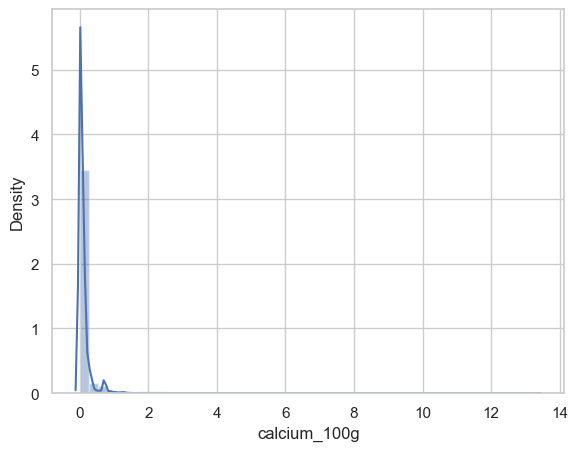

<Axes: xlabel='calcium_100g', ylabel='Density'>

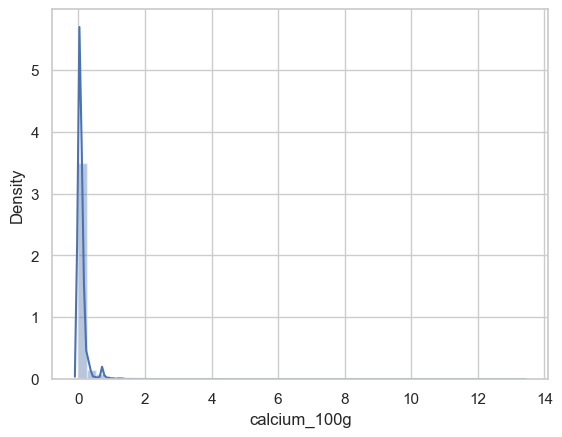

In [119]:
sns.distplot(data['calcium_100g'].head(10000).dropna())
# plt.show()
save_figure_opt('calcium_100g', library='matplotlib')
sns.distplot(data_test['calcium_100g'])

In [120]:
# dt = clean_nan(data.head(10000),0.80)
# print('***************** : dt ' , dt)
#     # on sélectionne les colonnes qui contiennent des valeurs manquantes
# #imputable_columns = dt.select_dtypes(['int32', 'float64','category'])
# #print('********************* shape imputable columns : ', imputable_columns.shape)
# #print('*********************  imputable columns : ', imputable_columns)
# # on sélectionne les colonnes qui contiennent des valeurs manquantes
# imputable_columns = dt.select_dtypes(['int8','float32','int32', 'float64','category'])
# print('********************* shape imputable columns : ', imputable_columns.shape)

# # pour chaque colonne contenant des valeurs manquantes
# for column in imputable_columns:
#     print('\n...imputation colonne ', column)

#     # on identifie les indices des données manquantes pour la colonne du tour de boucle
#     index_to_fill = dt[dt[column].isna()].index
#     print('*********************index_to_fill : ' , index_to_fill)
# print('***************** index_to_fill ; ' , index_to_fill )
# columns_to_calculate = dt[numeric_columns].iloc[index_to_fill[1],:].dropna().index.tolist() 
# print(' ***************** columns_to_calculate :', columns_to_calculate)
# dtree = dt[columns_to_calculate].copy().dropna(axis=0).dropna(axis=1)
# print('*********************** dtree : ' , dtree)
# #on calcule le KDTree sur la base des données des autres colonnes, après suppression de TOUS les NaN
# tree = KDTree(dtree, leaf_size=2)
# print('...arbre calculé')
# #on détermine les distances/indices aux 10 plus proches voisins de tous les points du jeu de donnée
# dist, ind = tree.query(dt[columns_to_calculate].copy().dropna(axis=0).dropna(axis=1), k=10)
# print(data['categories'].unique())
# #data['categories'] = data['categories'].round()

### <a name="C281">2.8.1 - Fonction avec méthodes des kNN(impute_knn(dataframe))</a>

### Fonction

In [121]:
# Définition d'une fonction pour imputer les valeurs manquantes des variables numériques par la méthode des K plus proches voisins
def impute_knn(dataframe):
    '''Imputation des NaN de variables numériques par la méthodes des K plus proches voisins'''

    # on sélectionne les colonnes numériques
    numeric_columns = dataframe.select_dtypes(['int32','float64','int8','float32']).columns
    print('*********************  numeric_columns : ', numeric_columns)
    print('********************* shape numeric_columns : ', numeric_columns.shape)

    # on sélectionne les colonnes qui contiennent des valeurs manquantes
    imputable_columns = dataframe.select_dtypes(['int8','float32','int32', 'float64','category'])
    print('********************* shape imputable columns : ', imputable_columns.shape)

    # pour chaque colonne contenant des valeurs manquantes
    for column in imputable_columns:
        print('\n...imputation colonne ', column)

        # on identifie les indices des données manquantes pour la colonne du tour de boucle
        index_to_fill = dataframe[dataframe[column].isna()].index
        print('*********************index_to_fill : ' , index_to_fill)

        # on stocke le nombre de NaN pour comparer leur nombre avant et après le traitement
        nb_nan = dataframe[column].isna().sum()

        # si la colonne contient des valeurs manquantes
        if nb_nan != 0 :

            # on détermine les colonnes pour lesquelles on va calculer les distances
            columns_to_calculate = dataframe[numeric_columns].iloc[index_to_fill[0],:].index.tolist() 
            print('********************columns_to_calculate ', columns_to_calculate)

            # on calcule le KDTree sur la base des données des autres colonnes, après suppression de TOUS les NaN
            dtree = dataframe[columns_to_calculate].copy().dropna(axis=0).dropna(axis=1)
            tree = KDTree(dtree)
            print('...arbre calculé')

            # on détermine les distances/indices aux 10 plus proches voisins de tous les points du jeu de donnée
            dist, ind = tree.query(dataframe[columns_to_calculate].copy().dropna(axis=0).dropna(axis=1), k=10)
            print('...dimensions {}/indice {}calculés : '.format(dist.shape, ind.shape))
            print('index to fill : ', index_to_fill)

            # pour chaque point où on a des données manquantes, on impute la moyenne des 10 plus proches voisins 
            for i, x in enumerate(index_to_fill):

                # pour les donnnées catégorielles, on attribue selon la valeur la plus fréquente
                if pd.api.types.is_categorical_dtype(dataframe[column]):
                    vote = dataframe.iloc[ind[i,:], dataframe.columns.get_loc(column)].value_counts().reset_index().iloc[0,0]
                    dataframe.iloc[x,dataframe.columns.get_loc(column)] = vote
                    
                # pour les données numériques, on attribue selon la moyenne des valeurs les plus proches
                elif pd.api.types.is_numeric_dtype(dataframe[column]):
                    mean = dataframe.iloc[ind[i,:], dataframe.columns.get_loc(column)].mean()
                    dataframe.iloc[x,dataframe.columns.get_loc(column)] = mean
                else:
                    print('Type inconnu {}, colonne {} non traitée'.format(dataframe[column].dtype, column))

        print('Colonne {} traitée, {} NaN initialement, {} NaN après imputation'.format(column, nb_nan, dataframe[column].isna().sum()))
#     try:
#         dataframe['nova_group'] = dataframe['nova_group'].round()
#     except:
#         print('colonne nova_group absente')
    return dataframe

### <a name="C282">2.8.2 - Observation de l'application de la fonction d'imputation sur une partie du jeu de données</a>

In [122]:
data_test = impute_knn(clean_nan(data.head(10000),0.80))

Nombre de colonnes supprimées : 121
*********************  numeric_columns :  Index(['additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'calcium_100g', 'iron_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'quantity'],
      dtype='object')
********************* shape numeric_columns :  (21,)
********************* shape imputable columns :  (10000, 34)

...imputation colonne  creator
*********************index_to_fill :  Int64Index([], dtype='int64')
Colonne creator traitée, 0 NaN initialement, 0 NaN après imputation

...imputation colonne  brands
*********************index_to_fill :  Int64Index([   1,   46,   47,   48,  125,  136,  153,  154,  176,  178,
            ...
        

Colonne additives_tags traitée, 3017 NaN initialement, 0 NaN après imputation

...imputation colonne  additives_fr
*********************index_to_fill :  Int64Index([   0,    1,    2,    3,    4,    5,    6,    8,    9,   10,
            ...
            9957, 9958, 9970, 9974, 9977, 9979, 9983, 9984, 9985, 9991],
           dtype='int64', length=3017)
********************columns_to_calculate  ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'quantity']
...arbre calculé
...dimensions (7182, 10)/indice (7182, 10)calculés : 
index to fill :  Int64Index([   0,    1,    2,    3,    4,    5,    6,    8,    9,   10,
            ...
            9957, 9958, 9

...dimensions (7192, 10)/indice (7192, 10)calculés : 
index to fill :  Int64Index([   0,    3,    4,    5,    6,    7,    8,    9,   10,   11,
            ...
            9954, 9960, 9967, 9968, 9971, 9984, 9985, 9989, 9990, 9991],
           dtype='int64', length=2143)
Colonne trans-fat_100g traitée, 2143 NaN initialement, 0 NaN après imputation

...imputation colonne  cholesterol_100g
*********************index_to_fill :  Int64Index([   0,    3,    4,    5,    6,    7,    8,    9,   10,   11,
            ...
            9954, 9960, 9967, 9968, 9971, 9984, 9985, 9989, 9990, 9991],
           dtype='int64', length=2050)
********************columns_to_calculate  ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron

...dimensions (7286, 10)/indice (7286, 10)calculés : 
index to fill :  Int64Index([   0,    3,    4,    5,    6,    7,    8,    9,   10,   11,
            ...
            9967, 9968, 9971, 9975, 9976, 9984, 9985, 9989, 9990, 9991],
           dtype='int64', length=2425)
Colonne vitamin-a_100g traitée, 2425 NaN initialement, 0 NaN après imputation

...imputation colonne  vitamin-c_100g
*********************index_to_fill :  Int64Index([   0,    3,    4,    5,    7,    8,    9,   10,   12,   13,
            ...
            9954, 9960, 9967, 9968, 9971, 9984, 9985, 9989, 9990, 9991],
           dtype='int64', length=2298)
********************columns_to_calculate  ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_1

In [123]:
data_test1 = clean_nan(data, 0.80)


Nombre de colonnes supprimées : 108


In [125]:
# data_test = impute_knn(data_test1)

In [126]:
data_test

code  \
0     0000000003087   
1     0000000004530   
2     0000000004559   
3     0000000016087   
4     0000000016094   
...             ...   
9995  0011822583220   
9996  0011822583237   
9997  0011822583244   
9998  0011822583251   
9999  0011822583268   

                                                                                                              url  \
0     http://world-fr.openfoodfacts.org/produit/0000000003087/farine-de-ble-noir-ferme-t-y-r-nao                    
1     http://world-fr.openfoodfacts.org/produit/0000000004530/banana-chips-sweetened-whole                          
2     http://world-fr.openfoodfacts.org/produit/0000000004559/peanuts-torn-glasser                                  
3     http://world-fr.openfoodfacts.org/produit/0000000016087/organic-salted-nut-mix-grizzlies                      
4     http://world-fr.openfoodfacts.org/produit/0000000016094/organic-polenta-bob-s-red-mill                        
...                                                                                      ...                        
9995  http://world-fr.openfoodfacts.org/produit/0011822583220/thrifty-ice-cream-mint-n-chip-rite-aid-corporation    
9996  http://world-fr.openfoodfacts.org/produit/0011822583237/thrifty-ice-cream-rite-aid-corporation                
9997  http://world-fr.openfoodfacts.org/produit/0011822583244/thrifty-ice-cream-butter-pecan-rite-aid-corporation   
9998  http://world-fr.openfoodfacts.org/produit/0011822583251/thrifty-ice-cream-vanilla-rite-aid-corporation        
9999  http://world-fr.openfoodfacts.org/produit/0011822583268/thirfty-ice-cream-vanilla-rite-aid-corporation        

                         creator   created_t      created_datetime  \
0     openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1     usda-ndb-import             1489069957  2017-03-09T14:32:37Z   
2     usda-ndb-import             1489069957  2017-03-09T14:32:37Z   
3     usda-ndb-import             1489055731  2017-03-09T10:35:31Z   
4     usda-ndb-import             1489055653  2017-03-09T10:34:13Z   
...               ...                    ...                   ...   
9995  usda-ndb-import             1489090347  2017-03-09T20:12:27Z   
9996  usda-ndb-import             1489090348  2017-03-09T20:12:28Z   
9997  usda-ndb-import             1489090348  2017-03-09T20:12:28Z   
9998  usda-ndb-import             1489090348  2017-03-09T20:12:28Z   
9999  usda-ndb-import             1489090349  2017-03-09T20:12:29Z   

     last_modified_t last_modified_datetime                      product_name  \
0     1474103893      2016-09-17T09:18:13Z   Farine de blé noir                 
1     1489069957      2017-03-09T14:32:37Z   Banana Chips Sweetened (Whole)     
2     1489069957      2017-03-09T14:32:37Z   Peanuts                            
3     1489055731      2017-03-09T10:35:31Z   Organic Salted Nut Mix             
4     1489055653      2017-03-09T10:34:13Z   Organic Polenta                    
...          ...                       ...               ...                    
9995  1489090347      2017-03-09T20:12:27Z   Thrifty, Ice Cream, Mint N' Chip   
9996  1489090348      2017-03-09T20:12:28Z   Thrifty, Ice Cream                 
9997  1489090348      2017-03-09T20:12:28Z   Thrifty, Ice Cream, Butter Pecan   
9998  1489090349      2017-03-09T20:12:29Z   Thrifty, Ice Cream, Vanilla        
9999  1489090349      2017-03-09T20:12:29Z   Thirfty, Ice Cream, Vanilla        

                    brands           brands_tags countries    countries_tags  \
0     Ferme t'y R'nao       ferme-t-y-r-nao       en:FR     en:france          
1     Fred Meyer            fred-meyer            US        en:united-states   
2     Torn & Glasser        torn-glasser          US        en:united-states   
3     Grizzlies             grizzlies             US        en:united-states   
4     Bob's Red Mill        bob-s-red-mill        US        en:united-states   
...              ...                   

In [127]:
data

code  \
0       0000000003087   
1       0000000004530   
2       0000000004559   
3       0000000016087   
4       0000000016094   
...               ...   
320767  9948282780603   
320768  99567453        
320769  9970229501521   
320770  9980282863788   
320771  999990026839    

                                                                                                                                               url  \
0       http://world-fr.openfoodfacts.org/produit/0000000003087/farine-de-ble-noir-ferme-t-y-r-nao                                                   
1       http://world-fr.openfoodfacts.org/produit/0000000004530/banana-chips-sweetened-whole                                                         
2       http://world-fr.openfoodfacts.org/produit/0000000004559/peanuts-torn-glasser                                                                 
3       http://world-fr.openfoodfacts.org/produit/0000000016087/organic-salted-nut-mix-grizzlies                                                     
4       http://world-fr.openfoodfacts.org/produit/0000000016094/organic-polenta-bob-s-red-mill                                                       
...                                                                                        ...                                                       
320767  http://world-fr.openfoodfacts.org/produit/9948282780603/tomato-ricotta-panzani                                                               
320768  http://world-fr.openfoodfacts.org/produit/99567453/mint-melange-tea-a-blend-of-peppermint-lemon-grass-and-spearmint-trader-joe-s             
320769  http://world-fr.openfoodfacts.org/produit/9970229501521/%E4%B9%90%E5%90%A7%E6%B3%A1%E8%8F%9C%E5%91%B3%E8%96%AF%E7%89%87-%E4%B9%90%E5%90%A7   
320770  http://world-fr.openfoodfacts.org/produit/9980282863788/tomates-aux-vermicelles-knorr                                                        
320771  http://world-fr.openfoodfacts.org/produit/999990026839/sugar-free-drink-mix-peach-tea-market-pantry                                          

                           creator   created_t      created_datetime  \
0       openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1       usda-ndb-import             1489069957  2017-03-09T14:32:37Z   
2       usda-ndb-import             1489069957  2017-03-09T14:32:37Z   
3       usda-ndb-import             1489055731  2017-03-09T10:35:31Z   
4       usda-ndb-import             1489055653  2017-03-09T10:34:13Z   
...                 ...                    ...                   ...   
320767  openfoodfacts-contributors  1490631299  2017-03-27T16:14:59Z   
320768  usda-ndb-import             1489059076  2017-03-09T11:31:16Z   
320769  tomato                      1422099377  2015-01-24T11:36:17Z   
320770  openfoodfacts-contributors  1492340089  2017-04-16T10:54:49Z   
320771  usda-ndb-import             1489072709  2017-03-09T15:18:29Z   

       last_modified_t last_modified_datetime  \
0       1474103893      2016-09-17T09:18:13Z    
1       1489069957      2017-03-09T14:32:37Z    
2       1489069957      2017-03-09T14:32:37Z    
3       1489055731      2017-03-09T10:35:31Z    
4       1489055653      2017-03-09T10:34:13Z    
...            ...                       ...    
320767  1491244498      2017-04-03T18:34:58Z    
320768  1491244499      2017-04-03T18:34:59Z    
320769  1491244499      2017-04-03T18:34:59Z    
320770  1492340089      2017-04-16T10:54:49Z    
320771  1491244499      2017-04-03T18:34:59Z    

                                                             product_name  \
0       Farine de blé noir                                                  
1       Banana Chips Sweetened (Whole)                                      
2       Peanuts                                                             
3       Organic Salted Nut Mix                                              
4       Organic Polenta                                                     

In [128]:
# Accéder aux lignes correspondant à l'indice de la troisième valeur renvoyée par ind, pour la colonne de "calcium_100g"
data_test.iloc[ind[2,:], data_test.columns.get_loc("calcium_100g")].sum()

0.7335449

In [129]:
# type_counts = data.dtypes.value_counts()
# print(type_counts)
type_counts = data.dtypes.astype(str).value_counts()
category_count = type_counts.get('category', 0)
type_counts = type_counts.drop('category', errors='ignore')
type_counts = type_counts.append(pd.Series(category_count, index=['category']))
print(type_counts)
int_columns = data.select_dtypes(include='float64').columns.tolist()
print(int_columns)
#data.head()
data_optimized = optimize_dataframe(data)
type_counts = data_optimized.dtypes.astype(str).value_counts()
category_count = type_counts.get('category', 0)
type_counts = type_counts.drop('category', errors='ignore')
type_counts = type_counts.append(pd.Series(category_count, index=['category']))
print(type_counts)
int_columns = data_optimized.select_dtypes(include='float64').columns.tolist()
print(int_columns)


float32     102
object      10 
float64     4  
int32       1  
category    48 
dtype: int64
['no_nutriments', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil', 'nutrition_grade_uk']
float32     102
object      9  
float64     4  
int32       1  
category    49 
dtype: int64
['no_nutriments', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil', 'nutrition_grade_uk']


In [130]:
# sélectionne les colonnes de types int32, float64 et category et calcule la somme des valeurs manquantes
data_test.select_dtypes(['int8','float32','int32','float64', 'category']).isna().sum().sum()

0

### <a name="C29">2.9 - Traitement sur plusieurs variables numériques du jeu de données</a>
Regardons un exemple d'application du traitement sur plusieurs variables numériques du jeu de données :

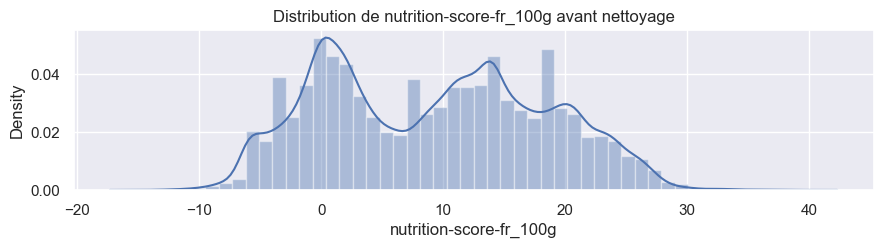

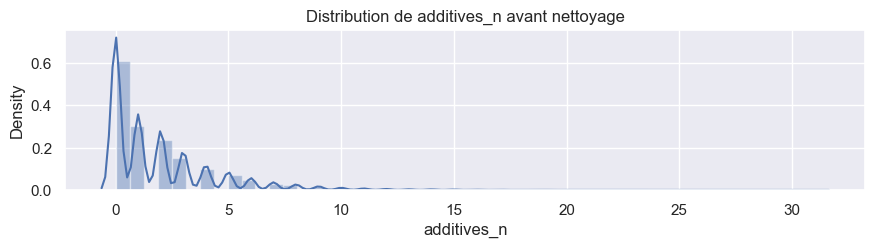

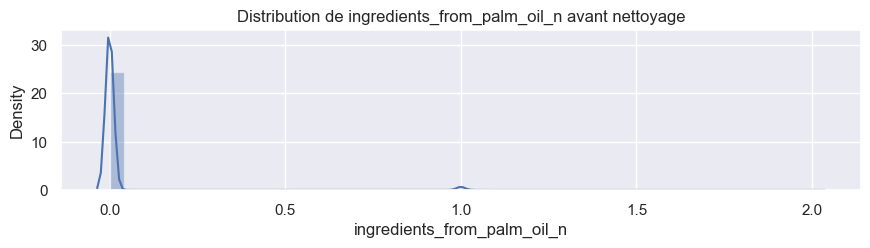

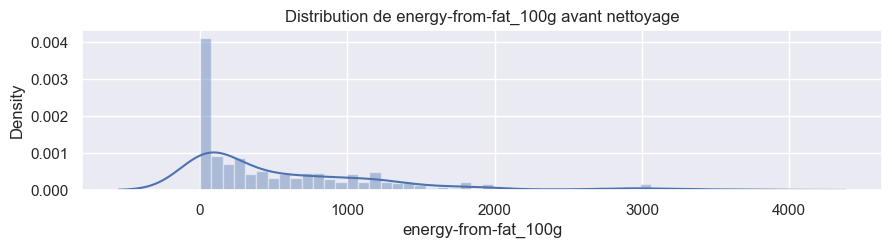

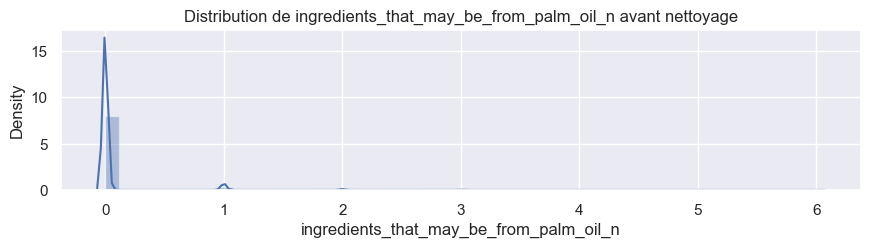

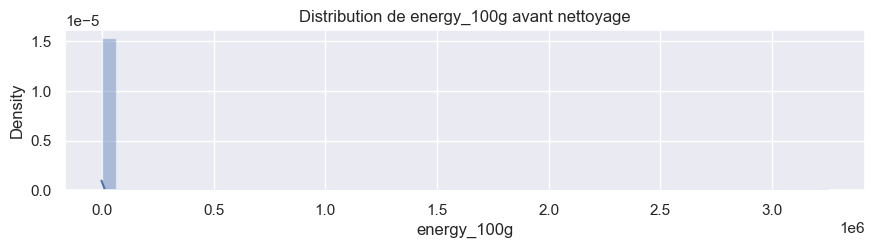

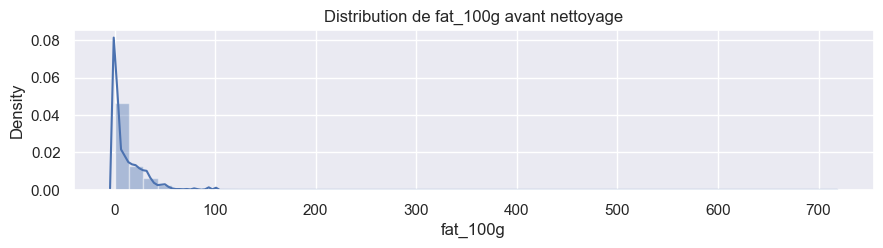

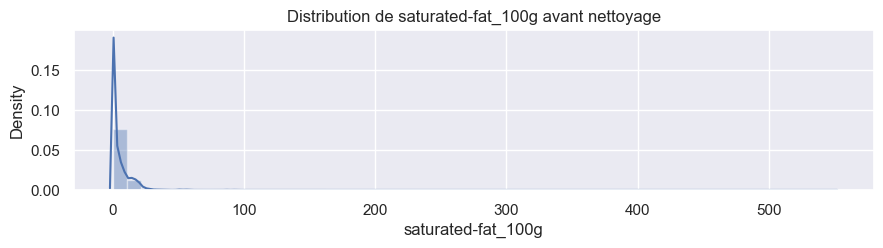

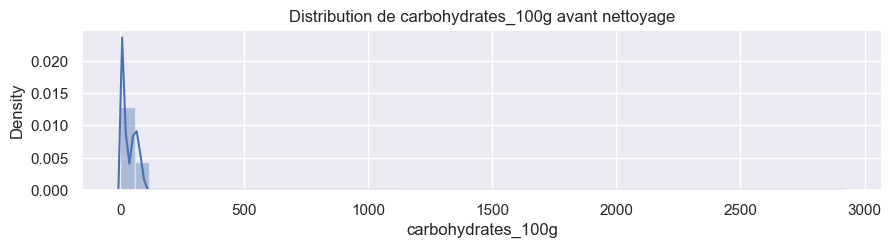

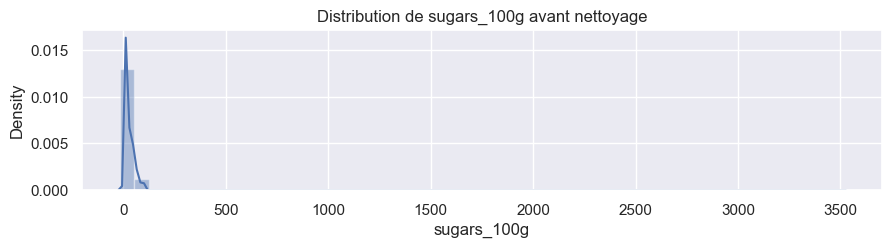

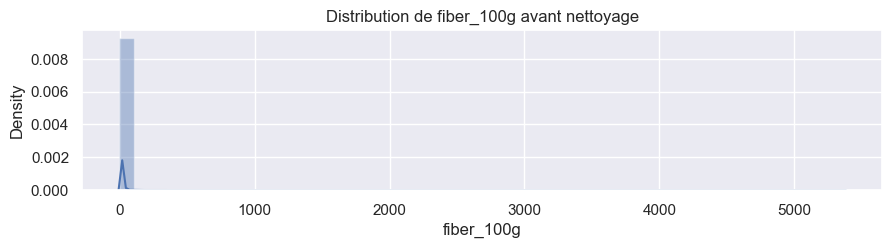

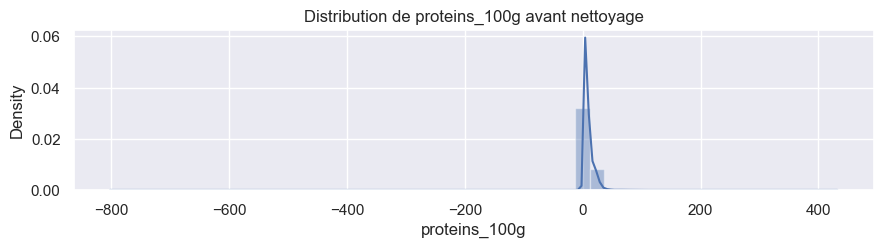

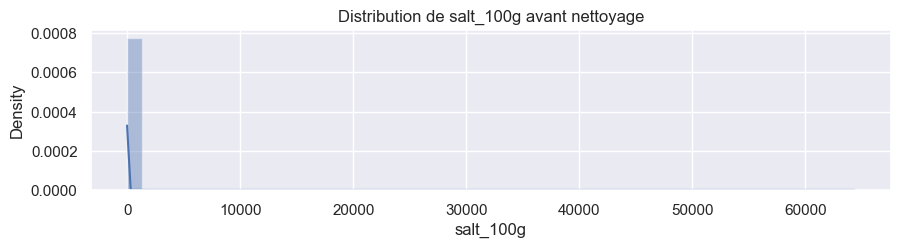

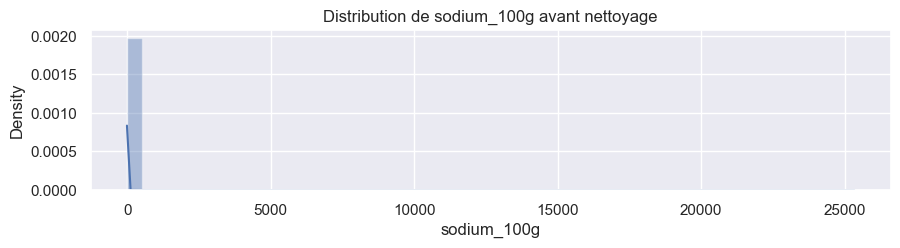

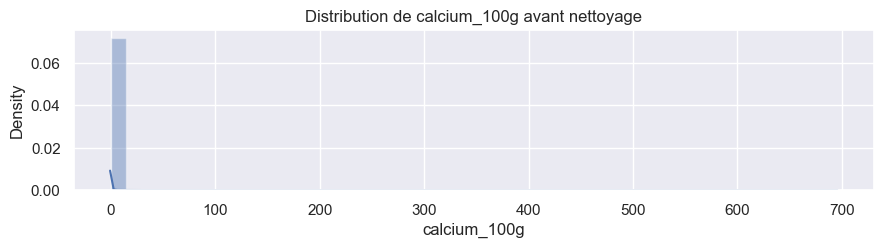

In [131]:
numeric_columns = ['nutrition-score-fr_100g', 'additives_n', 'ingredients_from_palm_oil_n', 'energy-from-fat_100g',
       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g','calcium_100g']


for column in numeric_columns:
    plt.figure(figsize = (10,2))
    sns.set(font_scale=1)
    if column in ['energy_100g', 'quantity']:
        sns.distplot(data[column].dropna(), bins=50)
    else:
        sns.distplot(data[column], bins=50)
    chaine = 'Distribution de ' + column + ' avant nettoyage'
    plt.title(chaine)
    plt.xlabel(column)
#     if column not in ['energy_100g', 'quantity']:
#         x_max = min(100, data[column].max() * 1.1)
#         plt.xlim(0, x_max)
    save_figure_opt(chaine,"Aanalyse_univariée_Distribution_par_variable_avant_nettoyage", library='matplotlib')



## <a name="C210">2.10 - Distribution des variables avant et après imputation des NaN</a>

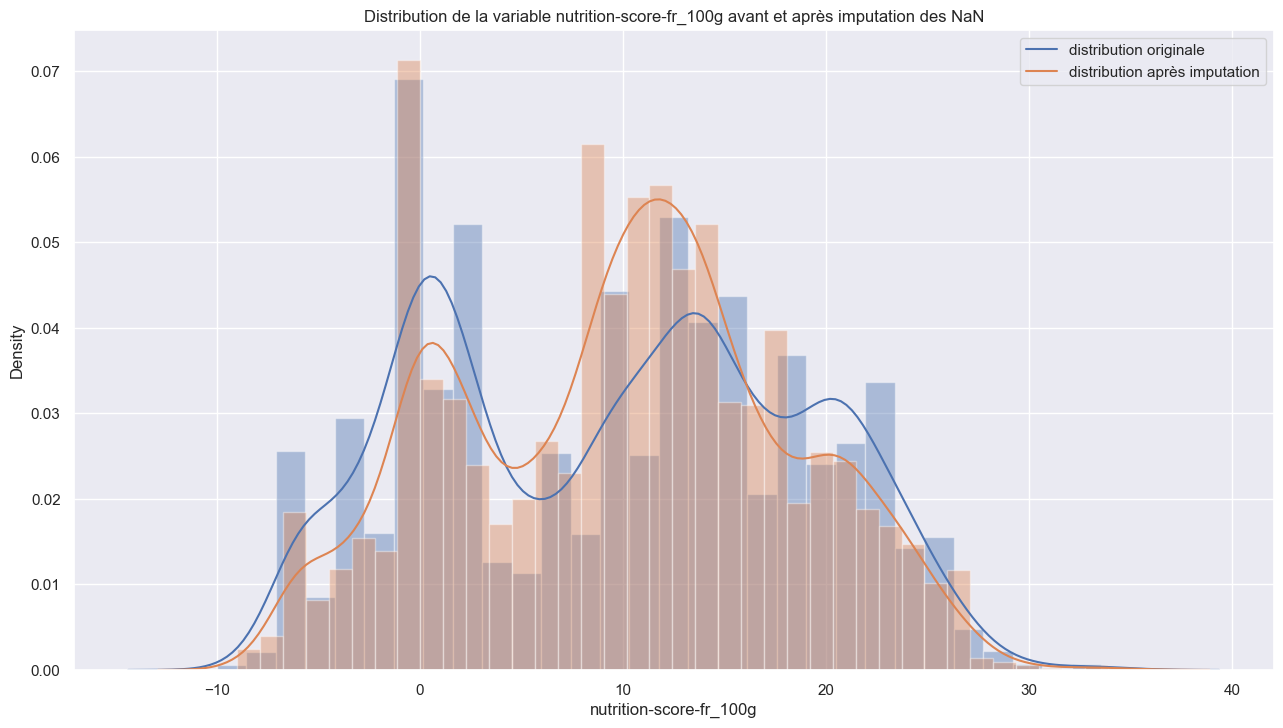


Traitement de la variable  nutrition-score-fr_100g
Moyenne (Avant / Après) :  9.583700180053711  /  9.919580459594727
Ecart-Type (Avant / Après) :  9.161760330200195  /  8.175725936889648


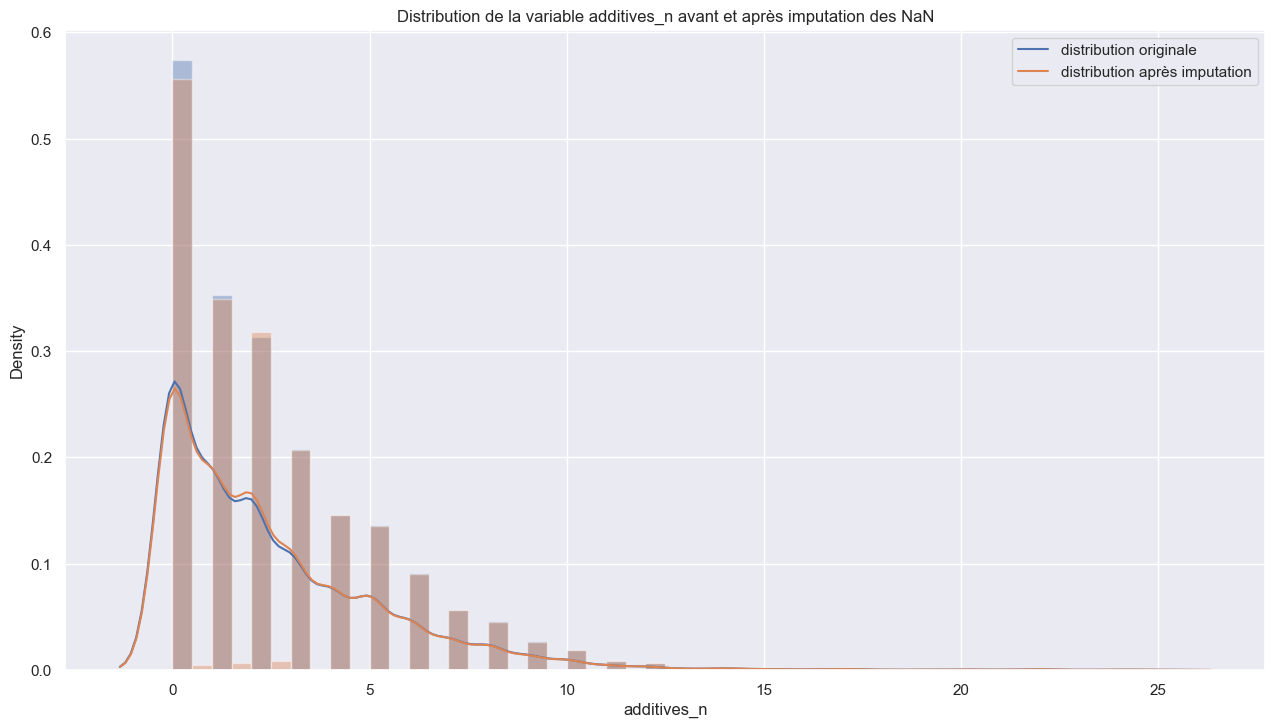


Traitement de la variable  additives_n
Moyenne (Avant / Après) :  2.5116000175476074  /  2.5251986980438232
Ecart-Type (Avant / Après) :  2.8105766773223877  /  2.7948827743530273


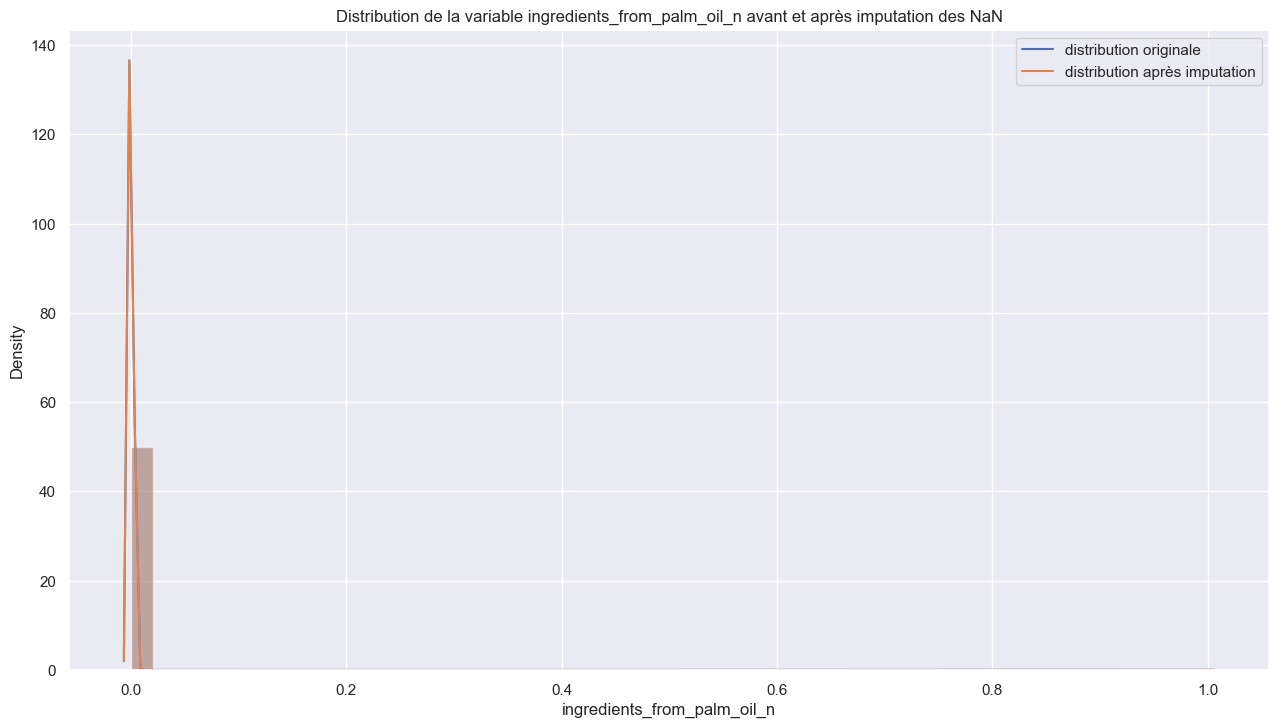


Traitement de la variable  ingredients_from_palm_oil_n
Moyenne (Avant / Après) :  0.00019999999494757503  /  0.00019999999494757503
Ecart-Type (Avant / Après) :  0.014140231534838676  /  0.014140265062451363


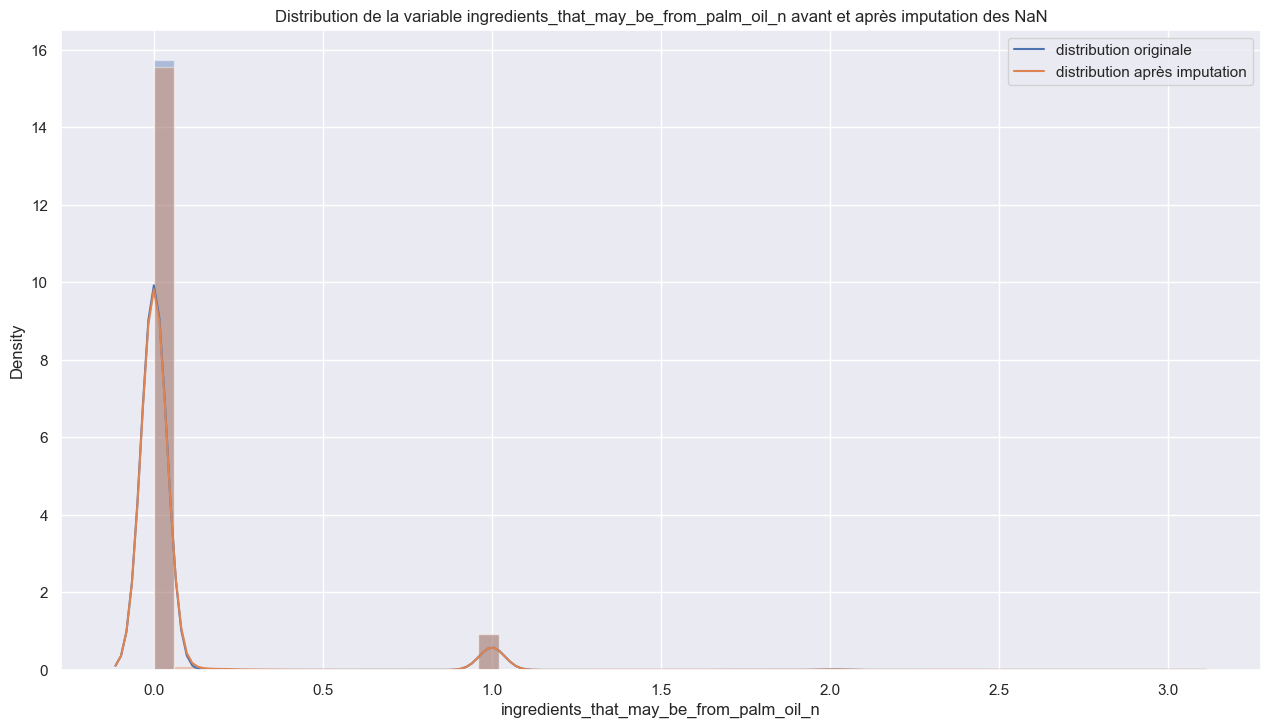


Traitement de la variable  ingredients_that_may_be_from_palm_oil_n
Moyenne (Avant / Après) :  0.05779999867081642  /  0.059288639575242996
Ecart-Type (Avant / Après) :  0.23929305374622345  /  0.23939476907253265


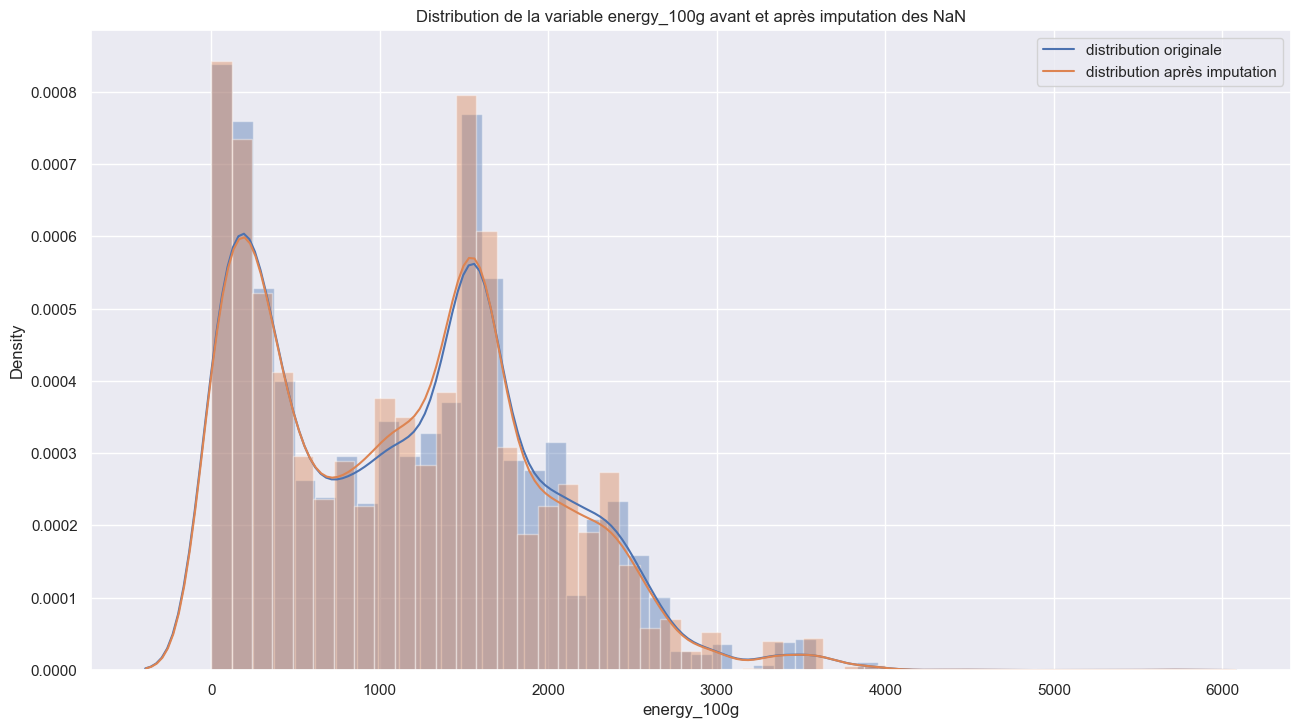


Traitement de la variable  energy_100g
Moyenne (Avant / Après) :  1145.0687255859375  /  1138.03759765625
Ecart-Type (Avant / Après) :  822.9912109375  /  813.5582275390625


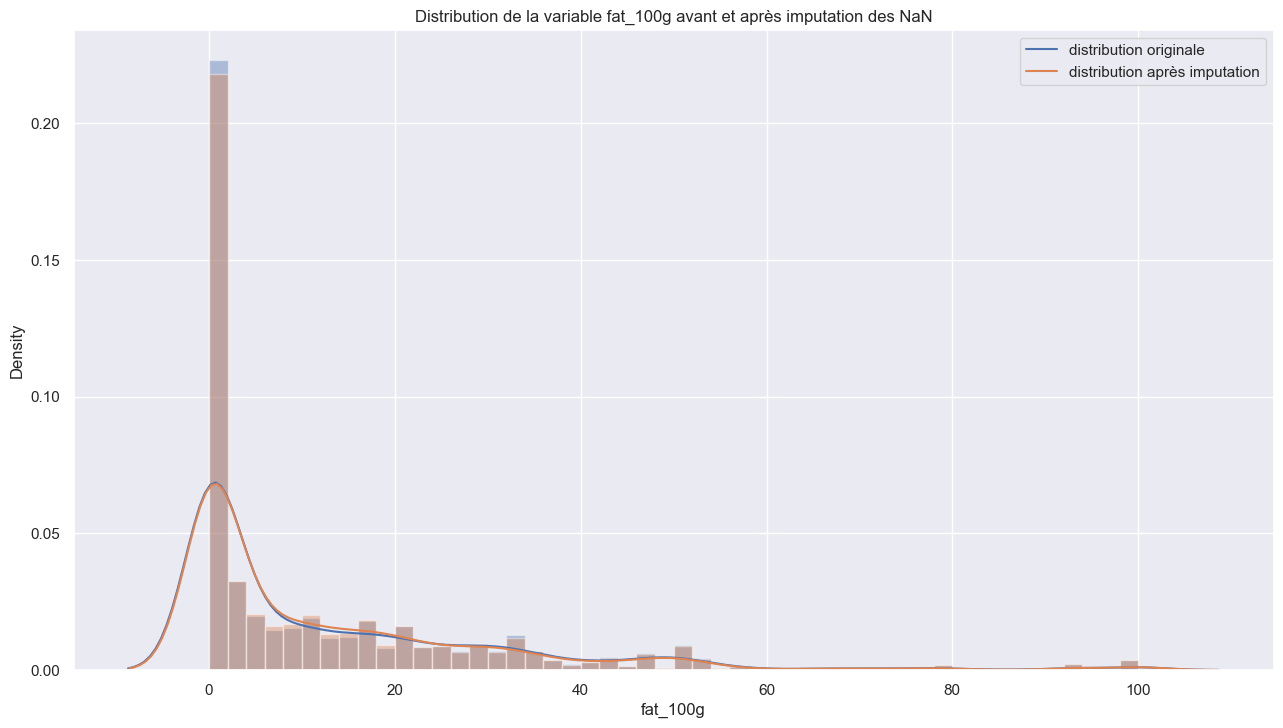


Traitement de la variable  fat_100g
Moyenne (Avant / Après) :  12.664216041564941  /  12.517922401428223
Ecart-Type (Avant / Après) :  18.290266036987305  /  18.013362884521484


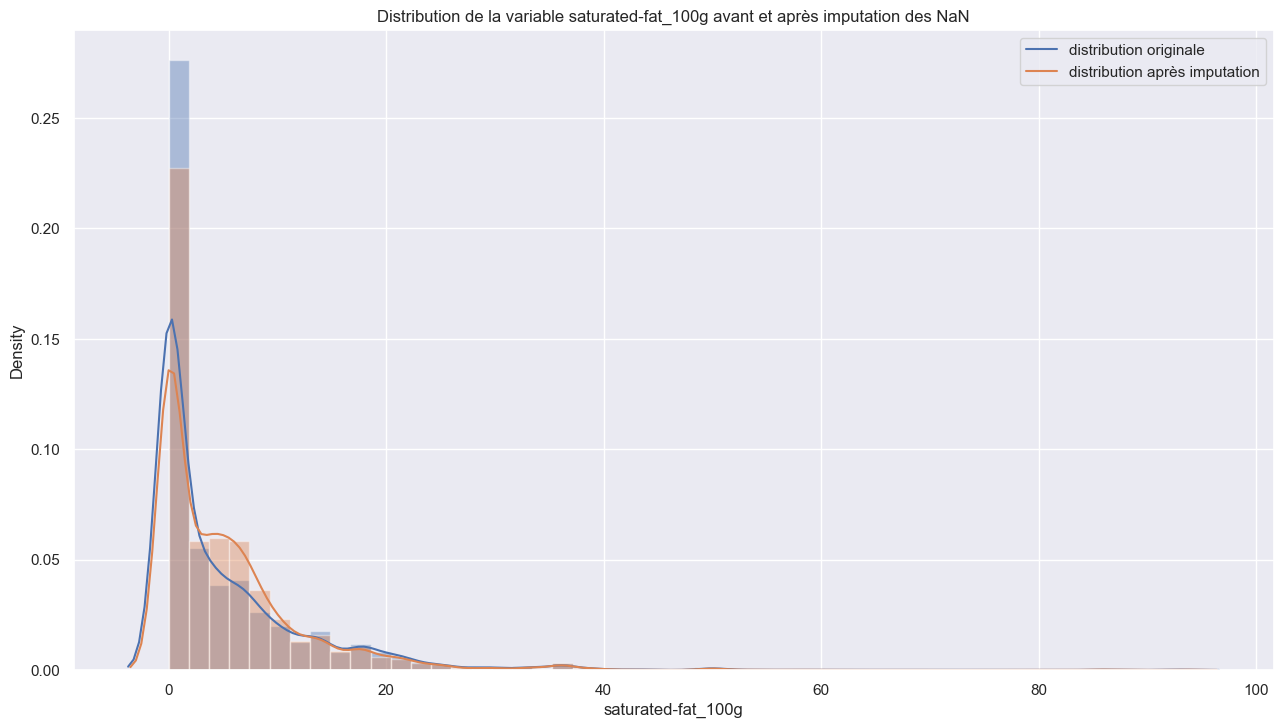


Traitement de la variable  saturated-fat_100g
Moyenne (Avant / Après) :  5.031558513641357  /  5.363915920257568
Ecart-Type (Avant / Après) :  7.806247711181641  /  7.367430210113525


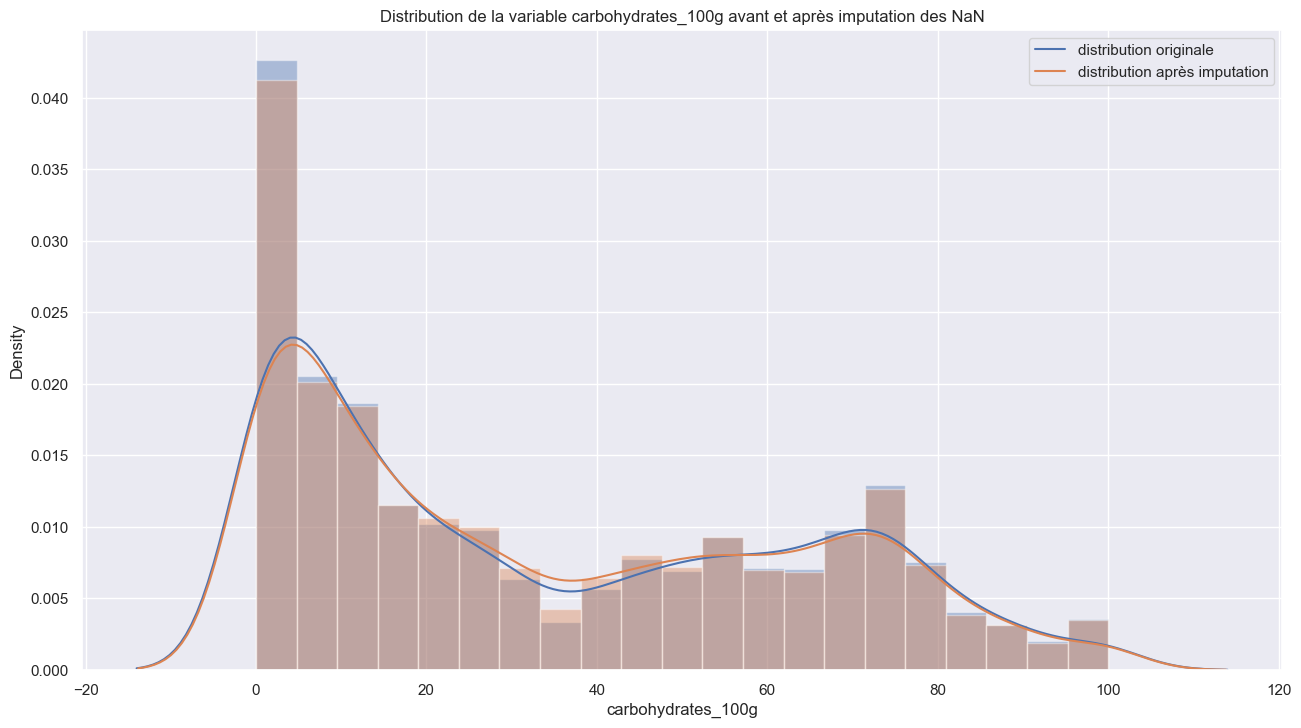


Traitement de la variable  carbohydrates_100g
Moyenne (Avant / Après) :  33.838626861572266  /  33.84014129638672
Ecart-Type (Avant / Après) :  29.458656311035156  /  29.083263397216797


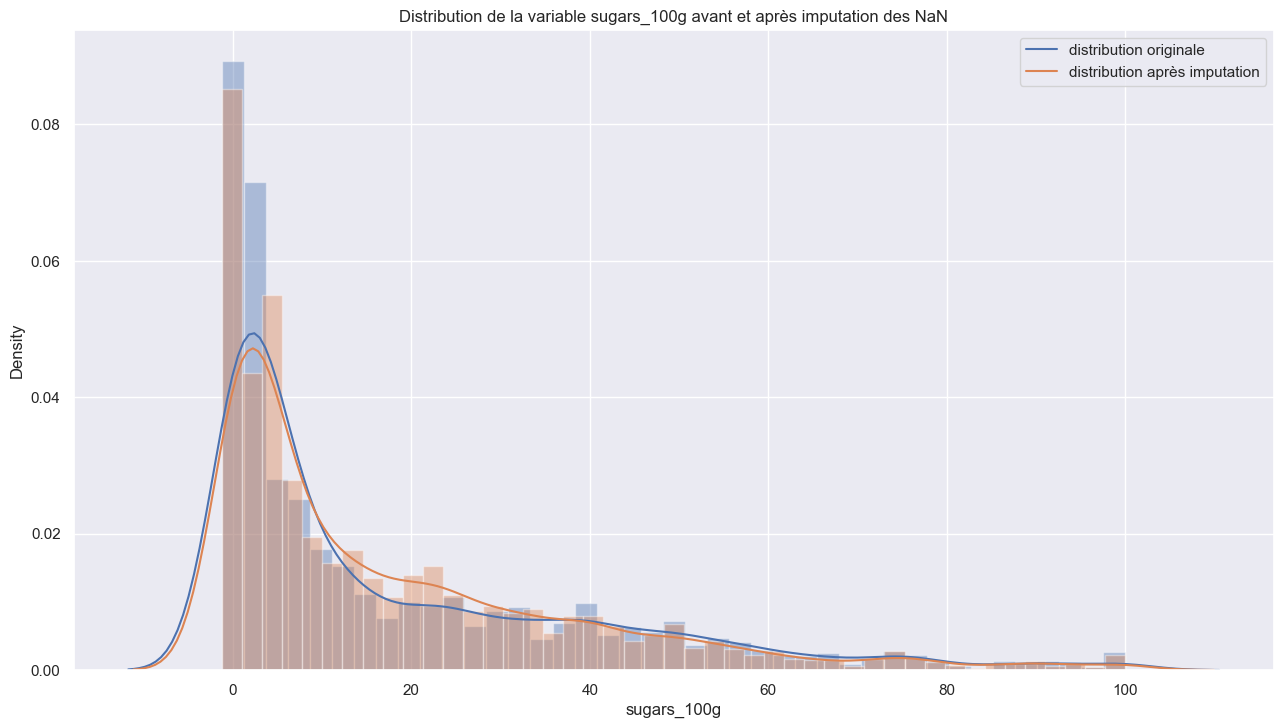


Traitement de la variable  sugars_100g
Moyenne (Avant / Après) :  17.872880935668945  /  17.703777313232422
Ecart-Type (Avant / Après) :  22.097362518310547  /  20.883031845092773


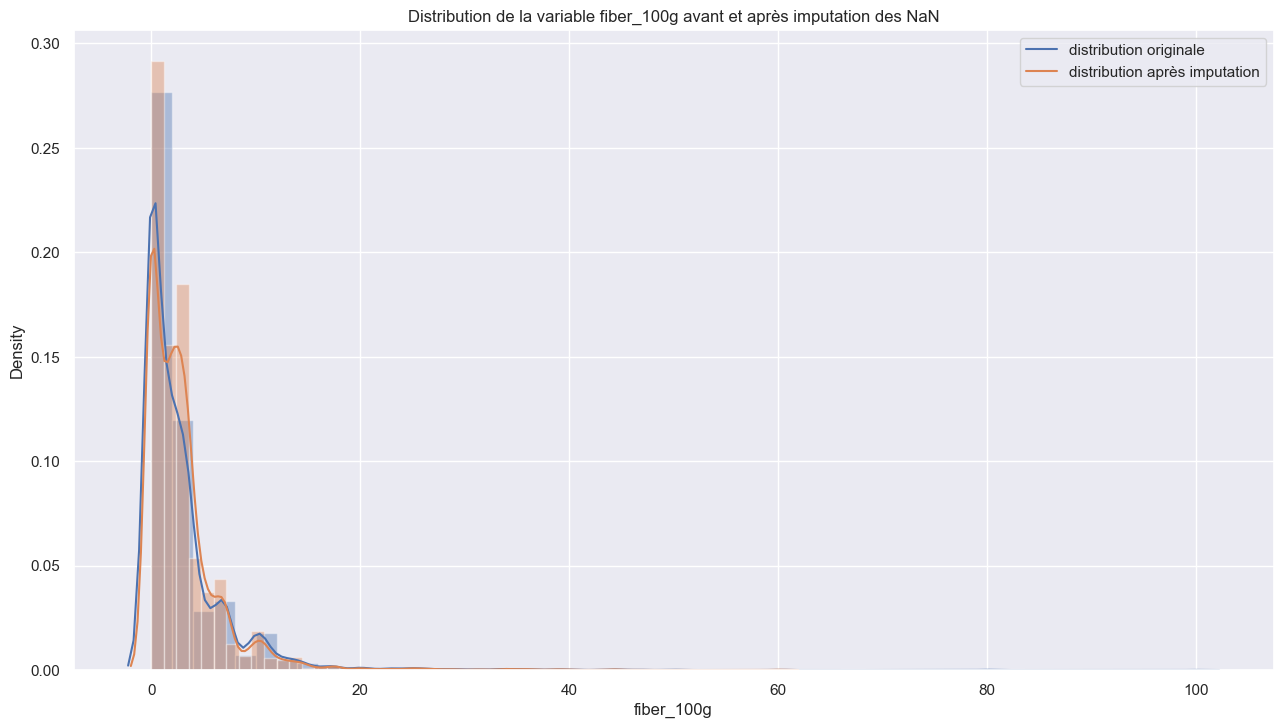


Traitement de la variable  fiber_100g
Moyenne (Avant / Après) :  2.8757987022399902  /  2.959156036376953
Ecart-Type (Avant / Après) :  4.63459587097168  /  4.089027404785156


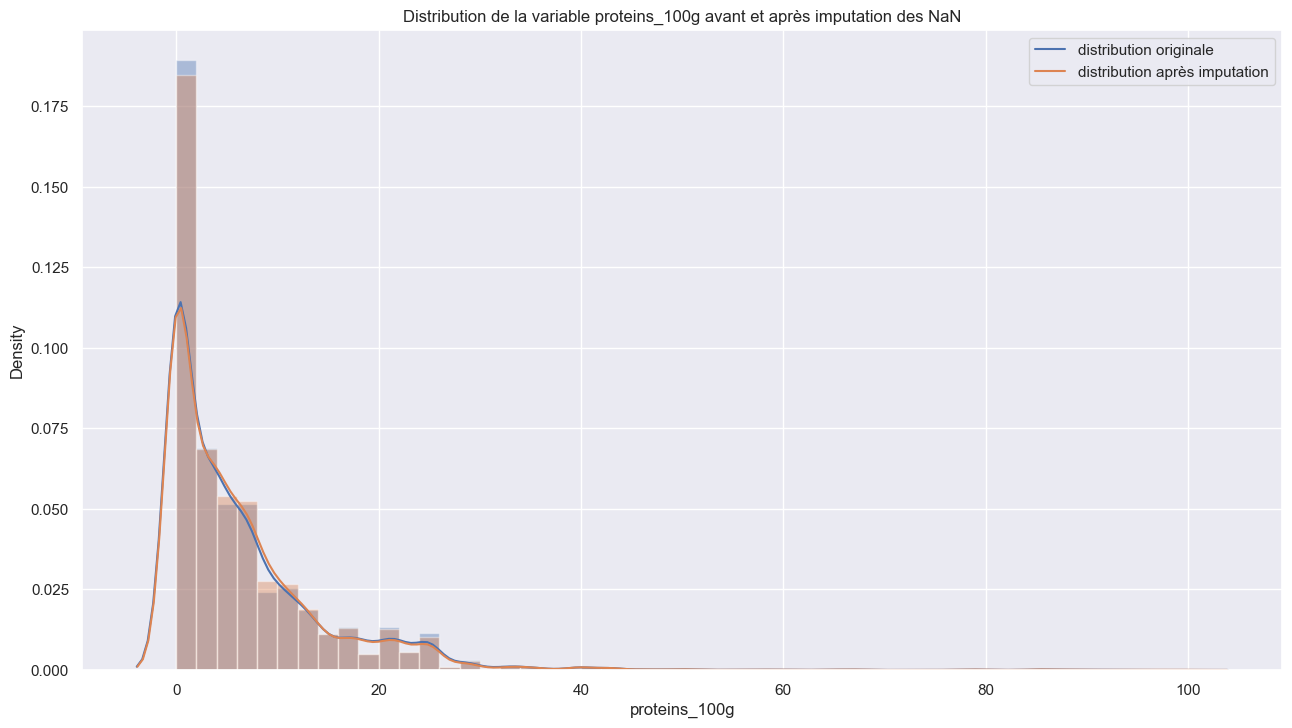


Traitement de la variable  proteins_100g
Moyenne (Avant / Après) :  6.350895881652832  /  6.3325581550598145
Ecart-Type (Avant / Après) :  8.184730529785156  /  8.05256462097168


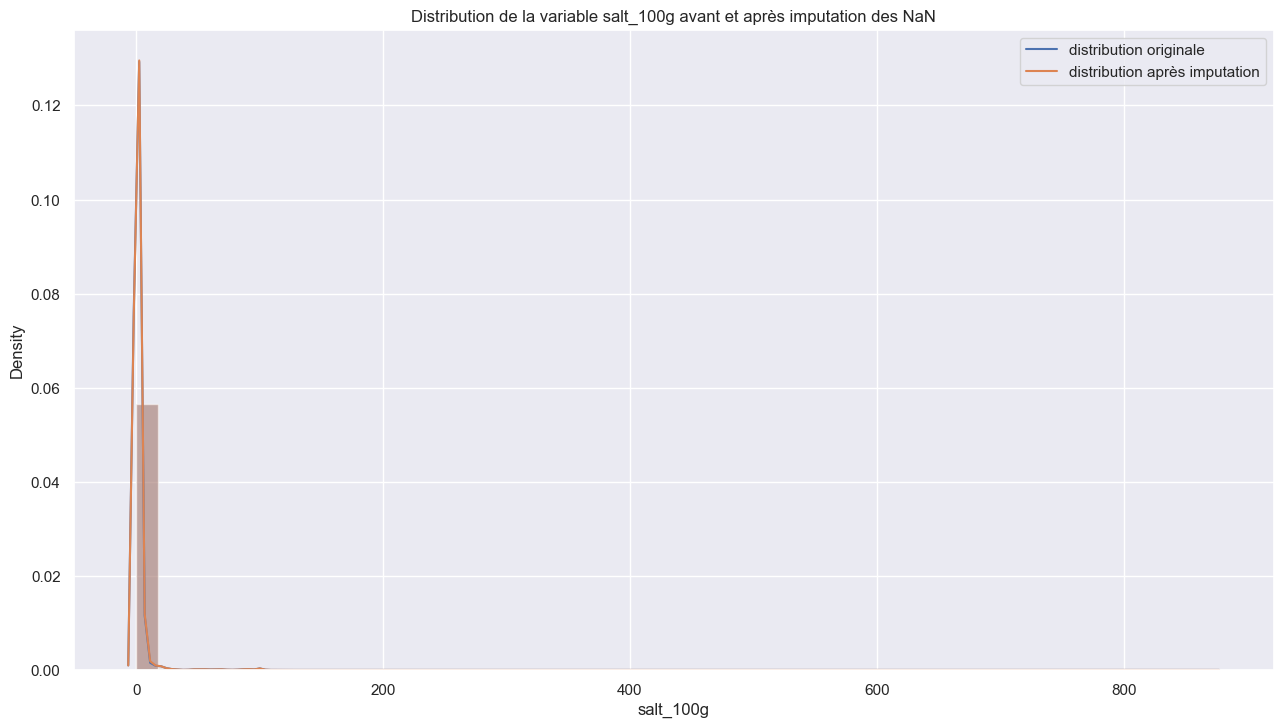


Traitement de la variable  salt_100g
Moyenne (Avant / Après) :  1.9739316701889038  /  2.0128655433654785
Ecart-Type (Avant / Après) :  13.73022747039795  /  13.723044395446777


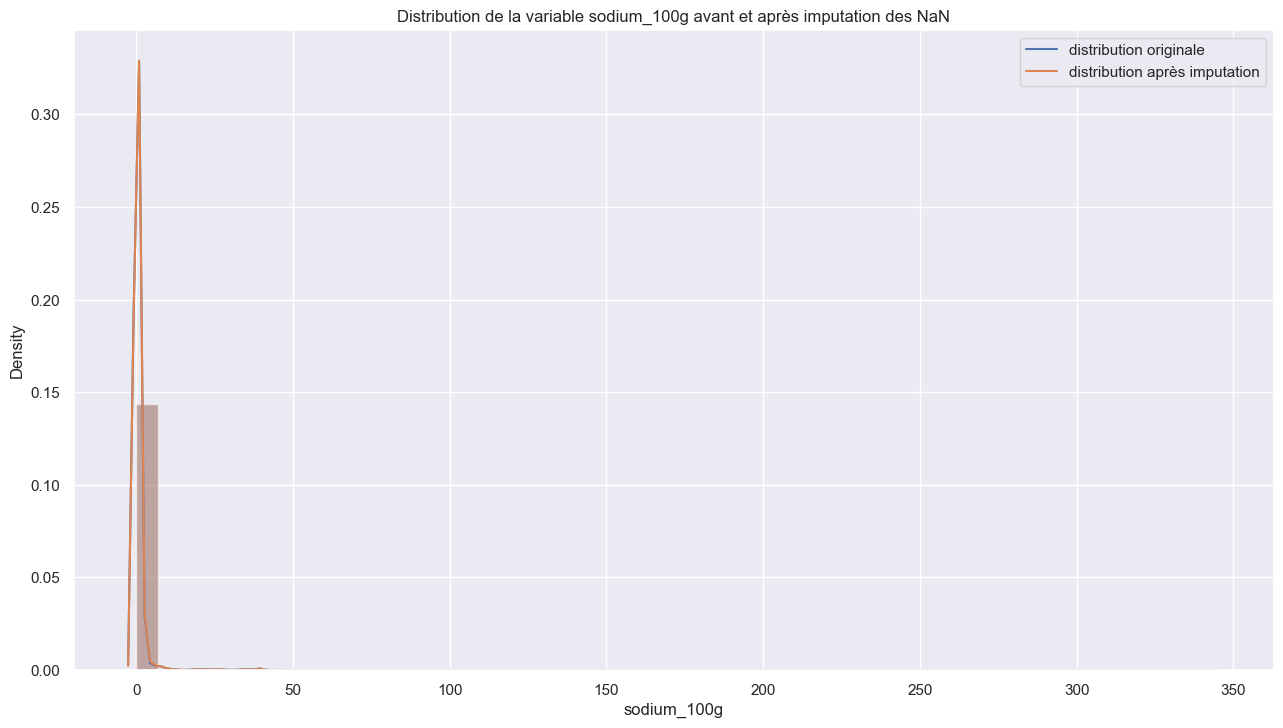


Traitement de la variable  sodium_100g
Moyenne (Avant / Après) :  0.7771387696266174  /  0.7924660444259644
Ecart-Type (Avant / Après) :  5.4056596755981445  /  5.402773380279541


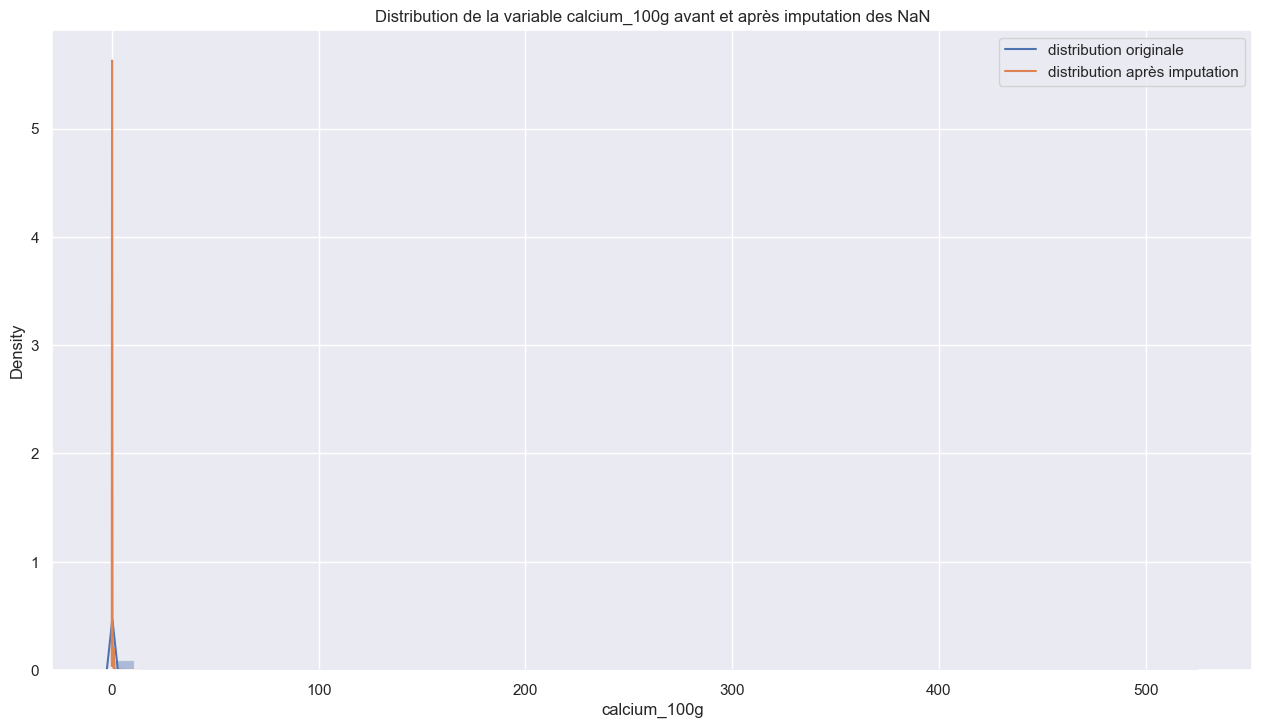


Traitement de la variable  calcium_100g
Moyenne (Avant / Après) :  0.14663942158222198  /  0.09435751289129257
Ecart-Type (Avant / Après) :  5.231873035430908  /  0.2245902568101883


In [132]:
# sns.set(font_scale=1.5)
# for column in ['energy_100g', 'fiber_100g', 'calcium_100g', 'iron_100g']:
#     plt.figure(figsize=(15,8))
#     chaine = 'Distribution de la variable ' + column + ' avant et après imputation des NaN'
#     plt.title(chaine)
    
#     sns.distplot(data[column].dropna().head(10000))
#     sns.distplot(data_test[column].dropna())
#     plt.legend(['distribution originale', 'distribution après imputation'])
#     print('\nTraitement de la variable ',column)
#     print('Moyenne (Avant / Après) : ', data[column].dropna().head(10000).mean(), ' / ', data_test[column].mean())
#     print('Ecart-Type (Avant / Après) : ', data[column].dropna().head(10000).std(), ' / ', data_test[column].std())
# sns.set(font_scale=1)

# Importation de la bibliothèque seaborn pour la visualisation des distributions

# Vérifier si seaborn est déjà chargé
if importlib.util.find_spec('seaborn') is None:
    # Si seaborn n'est pas chargé, le charger
    !pip install seaborn
    
# Vérifier si seaborn est déjà importé
if 'seaborn' not in sys.modules:
    import seaborn as sns

# Pour chaque variable numérique à imputer, on crée un graphique montrant la distribution avant et après l'imputation
# for column in ['energy_100g', 'fiber_100g', 'calcium_100g', 'iron_100g','fat_100g']:
    
for column in ['nutrition-score-fr_100g', 'additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g','calcium_100g']:

    
    # On crée une figure de taille 15x8
    plt.figure(figsize=(15,8))
    
    # On crée un titre pour le graphique
    chaine = 'Distribution de la variable ' + column + ' avant et après imputation des NaN'    
    Repertoire = 'Distribution_des_variable_avant_et_après_imputation_des_NaNs'
    plt.title(chaine)
    
    # On trace la distribution originale de la variable (avant imputation)
    sns.distplot(data[column].dropna().head(10000))
    
    # On trace la distribution de la variable après imputation
    sns.distplot(data_test[column].dropna())
    
    # On ajoute une légende
    plt.legend(['distribution originale', 'distribution après imputation'])
#     save_figure_opt(chaine, library='matplotlib')  
    save_figure_opt(chaine,Repertoire, library='matplotlib')
    # On affiche les statistiques avant et après imputation pour chaque variable
    print('\nTraitement de la variable ',column)
    print('Moyenne (Avant / Après) : ', data[column].dropna().head(10000).mean(), ' / ', data_test[column].mean())
    print('Ecart-Type (Avant / Après) : ', data[column].dropna().head(10000).std(), ' / ', data_test[column].std())

# On réduit la taille de la police utilisée dans les graphiques
sns.set(font_scale=1)


### <a name="C2101">2.10.1 - Conclusions</a>

Les graphes sont difficiles à lire sans suppression des outliers mais pour ceux qui sont lisibles, l'allure des distributions est très proches.
Lorsqu'on regarde l'impact de l'imputation sur la moyenne et l'écart type, on constate de forte disparités selon les features : 

**Moyenne**
* pour energy, calcium, fiber et iron : la moyenne varie assez peu (de l'ordre de 1 à 10%)

**Ecart Type**
* pour energy et iron, l'écart type est assez stable après application du traitement
* pour calcium et fiber, on peut constater d'importantes variations d'écart type : 
    * pour fiber : de l'ordre de 11.82 % de diminution,
    * pour calcium : l'écart type est réduit d'un facteur 25 (!)  observons de plus près cette variable

Recalculons l'écart type en retirant sommairement les outliers au delà du dernier centile

In [133]:
# Charger le fichier CSV
#data = pd.read_csv("data/fr.openfoodfacts.org.products.csv", sep='\t')
print('dernier centile : ',data['calcium_100g'].dropna().head(10000).quantile(0.99))
print('écart type avant imputation :', data['calcium_100g'].dropna().head(10000)[data[column] < 0.861].std())
print('écart type après imputation :', data_test['calcium_100g'][data_test['calcium_100g'] < 0.861].std())

dernier centile :  0.857039993405343
écart type avant imputation : 0.14010843634605408
écart type après imputation : 0.12354563921689987


les résultats suggèrent que la variable "calcium_100g" a une distribution assez dispersée avec des valeurs aberrantes ou des erreurs de saisie. Cependant, l'imputation a permis de réduire considérablement la dispersion des données et de remplacer les valeurs manquantes ou aberrantes par des valeurs plus représentatives de la distribution. Il est important de vérifier si l'imputation a été réalisée correctement et si les valeurs aberrantes ont été correctement identifiées et traitées.

## <a name="C211">2.11 - Distribution des variables de calcium_100g avant et après imputation des NaN</a>

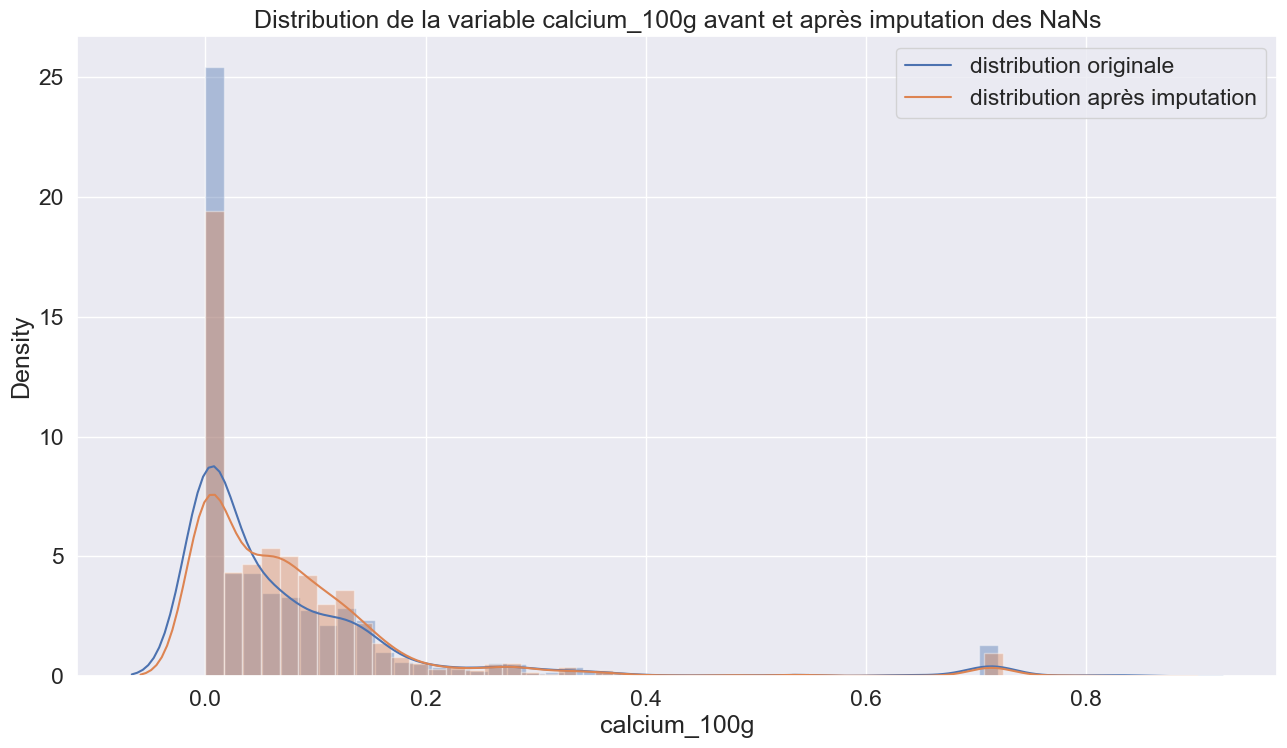

In [134]:
# sns.set(font_scale=1.5)
# for column in ['calcium_100g']:
#     plt.figure(figsize=(15,8))
#     chaine = 'Distribution de la variable ' + column + ' avant et après imputation des NaN'
#     plt.title(chaine)
    
#     sns.distplot(data[column].dropna().head(10000)[data[column] < 0.861])
#     sns.distplot(data_test[column][data_test[column] < 0.861])
#     plt.legend(['distribution originale', 'distribution après imputation'])
# sns.set(font_scale=1) 
# Importer la bibliothèque seaborn et régler la taille de police
import seaborn as sns
sns.set(font_scale=1.5)

# Parcourir la liste des colonnes et afficher les distributions des valeurs avant et après imputation des NaN
for column in ['calcium_100g']:
    # Créer une figure avec une taille de 15x8 pouces
    plt.figure(figsize=(15,8))
    # Créer une chaîne de caractères contenant le nom de la variable pour le titre de la figure
    chaine = 'Distribution de la variable ' + column + ' avant et après imputation des NaNs'
    # Titre de la figure
    plt.title(chaine)
    
    # Tracer la distribution des valeurs avant imputation des NaN pour les valeurs inférieures à 0,861
    sns.distplot(data[column].dropna().head(10000)[data[column] < 0.861])
    # Tracer la distribution des valeurs après imputation des NaN pour les valeurs inférieures à 0,861
    sns.distplot(data_test[column][data_test[column] < 0.861])
    
    # Légende des deux distributions
    plt.legend(['distribution originale', 'distribution après imputation'])
    save_figure_opt(chaine, library='matplotlib')
# Réinitialiser la taille de police
sns.set(font_scale=1)


En observant la distribution de calcium_100g de plus près, on voit l'impact de l'imputation:
* la distribution semble avoir été lissée : le pic d'occurence de valeur autour de 0 est réduit de 25 % tandis que les autres valeurs voient leur part augmenter dans la distribution. De même le pic d'occurence de valeur autour de 0.7 a été réduit en proportion après application de l'imputation
* dans ce cas, le KNN semble avantager les valeurs intermédiaires au détriment des valeurs plus extrêmes.

## <a name="C212">2.12 - Observons l'impact sur une donnée catégorielle</a>

In [135]:
# Sélectionner les colonnes de type 'category'
cat_columns = data.select_dtypes(include='category').columns.tolist()

# Afficher les noms des colonnes sélectionnées
print(cat_columns)

['creator', 'generic_name', 'quantity_original', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_fr', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'serving_size', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2', 'states', 'states_tags', 'states_fr', 'main_category', 'main_category_fr', 'image_url', 'image_small_url', 'quantity_origine']


In [136]:
#data_test['nova_group'].value_counts()#

In [137]:
#clean_nan(data.head(10000),0.80)['nova_group'].value_counts()

In [138]:
data_test['nutrition_grade_fr'].value_counts()

d    3123
c    2038
e    2029
b    1443
a    1367
Name: nutrition_grade_fr, dtype: int64

In [139]:
clean_nan(data.head(10000),0.80)['nutrition_grade_fr'].value_counts()

Nombre de colonnes supprimées : 121


d    2220
e    1593
c    1544
b    1241
a    1132
Name: nutrition_grade_fr, dtype: int64

Note : la fonction n'a pas pu être appliquée à tout le jeu de données (problème de performance)

In [140]:
#f, (ax1, ax2) = plt.subplots(1, 2)

#ax1.pie(clean_nan(data.head(10000),0.80)['nova_group'].value_counts(), 
#              labels = clean_nan(data.head(10000),0.80)['nova_group'].value_counts().index)
#ax1.set_title('Nova Group column\nBefore imputation')

#ax2.pie(data_test['nova_group'].round().value_counts(), 
#              labels = data_test['nova_group'].round().value_counts().index)
#ax2.set_title('Nova Group column\nAfter imputation')

Nombre de colonnes supprimées : 121
Nombre de colonnes supprimées : 121


Text(0.5, 1.0, 'nutrition_grade_fr column\nAfter imputation')

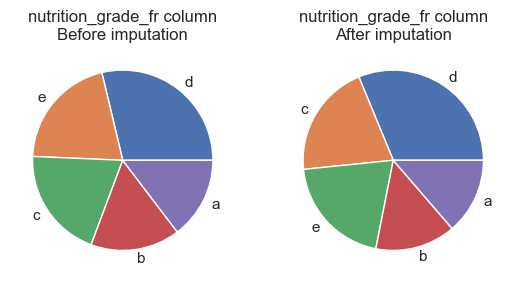

In [141]:
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.pie(clean_nan(data.head(10000),0.80)['nutrition_grade_fr'].value_counts(), 
              labels = clean_nan(data.head(10000),0.80)['nutrition_grade_fr'].value_counts().index)
ax1.set_title('nutrition_grade_fr column\nBefore imputation')

ax2.pie(data_test['nutrition_grade_fr'].value_counts(), 
              labels = data_test['nutrition_grade_fr'].value_counts().index)
ax2.set_title('nutrition_grade_fr column\nAfter imputation')

On observe que le vote de la catégorie la plus présente "localement retient la catégorie majoritaire à l'échelle du jeu de donnée

## <a name="C213">2.13 - Suppression des colonnes contenant de l'information en doublon</a>

In [142]:
#data[['countries_en', 'countries']]
data.head(1)

code  \
0  0000000003087   

                                                                                          url  \
0  http://world-fr.openfoodfacts.org/produit/0000000003087/farine-de-ble-noir-ferme-t-y-r-nao   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   

  last_modified_t last_modified_datetime        product_name generic_name  \
0  1474103893      2016-09-17T09:18:13Z   Farine de blé noir  NaN           

  quantity_original packaging packaging_tags           brands  \
0  1kg               NaN       NaN            Ferme t'y R'nao   

       brands_tags categories categories_tags categories_fr origins  \
0  ferme-t-y-r-nao  NaN        NaN             NaN           NaN      

  origins_tags manufacturing_places manufacturing_places_tags labels  \
0  NaN          NaN                  NaN                       NaN     

  labels_tags labels_fr emb_codes emb_codes_tags first_packaging_code_geo  \
0  NaN         NaN       NaN       NaN            NaN                       

  cities cities_tags purchase_places stores countries countries_tags  \
0  NaN    NaN         NaN             NaN    en:FR     en:france       

  countries_fr ingredients_text allergens allergens_fr traces traces_tags  \
0  France       NaN              NaN       NaN          NaN    NaN          

  traces_fr serving_size  no_nutriments  additives_n additives additives_tags  \
0  NaN       NaN         NaN            NaN           NaN       NaN             

  additives_fr  ingredients_from_palm_oil_n  ingredients_from_palm_oil  \
0  NaN         NaN                          NaN                          

  ingredients_from_palm_oil_tags  ingredients_that_may_be_from_palm_oil_n  \
0  NaN                           NaN                                        

   ingredients_that_may_be_from_palm_oil  \
0 NaN                                      

  ingredients_that_may_be_from_palm_oil_tags  nutrition_grade_uk  \
0  NaN                                       NaN                   

  nutrition_grade_fr pnns_groups_1 pnns_groups_2  \
0  NaN                NaN           NaN            

                                                                                                                                                                                                                                                                                                                                              states  \
0  en:to-be-completed, en:nutrition-facts-to-be-completed, en:ingredients-to-be-completed, en:expiration-date-to-be-completed, en:characteristics-to-be-completed, en:categories-to-be-completed, en:brands-completed, en:packaging-to-be-completed, en:quantity-completed, en:product-name-completed, en:photos-to-be-validated, en:photos-uploaded   

                                                                                                                                                                                                                                                                                                                              states_tags  \
0  en:to-be-completed,en:nutrition-facts-to-be-completed,en:ingredients-to-be-completed,en:expiration-date-to-be-completed,en:characteristics-to-be-completed,en:categories-to-be-completed,en:brands-completed,en:packaging-to-be-completed,en:quantity-completed,en:product-name-completed,en:photos-to-be-validated,en:photos-uploaded   

                                                                                                                                                                                                                                                                       states_fr  \
0  A compléter,Informations nutritionnelles à compléter,Ingrédients à compléter,Date limite à compléter,Caractéristiques à compléter,Catégories à compléter,Marques complétées,Emballa

On peut supprimer la colonne countries qui n'apporte pas d'information et présente des formats hétérogènes

In [143]:
columns_to_delete = ['countries']

In [144]:
# data_echantillon[['last_modified_datetime', 'last_modified_t']]

In [145]:
#data_echantillon[['created_datetime', 'created_t']]

En observant un échantillon de dates traitées, on voit que :
* last_modified_datetime et last_modified_t ont exactement les mêmes dates et aucune donnée manquante.
* created_datetime et created_t  ont exactement les mêmes dates et aucune donnée manquante.
Dans les deux cas, on peut conserver l'un des deux et supprimer l'autre

In [146]:
#data.dtypes

In [147]:
def remove_columns(dataframe) :
    colonnes = dataframe.columns.tolist()
    columns_to_delete = [ 'countries',
             'brands_tags', 'categories_tags', 'origins_tags', 
             'manufacturing_places_tags', 'labels_tags', 'labels_en',
             'emb_codes_tags','countries_tags', 'traces', 'traces_en', 
             'categories', 'main_category','countries', 'countries_tags', 'last_modified_datetime', 
             'main_category','brands_tags','labels',
             'labels_en', 'categories_tags', 'categories_en', 
            'serving_size', 'additives_en', 'traces', 'states','states_en', 'countries_en','carbon_footprint_100g',
            'carbon_footprint_from_meat_or_fish_100g',
            'ingredients_from_palm_oil_tags', 'origins',
            'ingredients_that_may_be_from_palm_oil_tags',
            'manufacturing_places', 'stores','cities_tags',
            'generic_name','collagen_meat_protein_ratio_100g',
            'first_packaging_code_geo','purchase_places', 'emb_codes','monounsaturated_fat_100g','polyunsaturated_fat_100g', 
            'omega_3_fat_100g',
            '_alpha_linolenic_acid_100g', 'omega_6_fat_100g', 
            'trans_fat_100g', 'cholesterol_100g',
            'caffeine_100g', 'cocoa_100g','_lactose_100g', 'starch_100g',
            '_soluble_fiber_100g', '_insoluble_fiber_100g',
            'vitamin_a_100g', 'vitamin_d_100g', 'vitamin_e_100g',
            'vitamin_k_100g', 'vitamin_c_100g', 'vitamin_b1_100g',
            'vitamin_b2_100g', 'vitamin_pp_100g', 'vitamin_b6_100g',
            'vitamin_b9_100g', 'folates_100g', 'vitamin_b12_100g',
            'biotin_100g', 'pantothenic_acid_100g', 'bicarbonate_100g',
            'potassium_100g', 'chloride_100g', 'calcium_100g',
            'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g',
            'copper_100g', 'manganese_100g', 'selenium_100g', 'iodine_100g',
            'phylloquinone_100g' ]
    for column in columns_to_delete:
        try:
            colonnes.remove(column)
        except:
            print('........colonne non présente : ', column)
    print('\n')
    return dataframe[colonnes]

## <a name="C214">2.14 - Nettoyage tirets dans titre des colonnes</a>

In [148]:
def clean_column_names(dataframe):
    '''Fonction pour retirer les tirets dans les noms de colonnes pour avoir 
    la même mise en forme pour chaque colonne'''
    columns = dataframe.columns
    columns_treated = []
    for column in columns:
        if column[0] == '-':
            column = column[1:]
        columns_treated.append(column)
    dataframe.columns = columns_treated
    return dataframe

In [149]:
data.columns.tolist()

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity_original',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_fr',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_fr',
 'ingredients_text',
 'allergens',
 'allergens_fr',
 'traces',
 'traces_tags',
 'traces_fr',
 'serving_size',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_fr',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_oil_tags',
 

## <a name="C215">2.15 - Application des traitements de nettoyage au dataset entier</a>

### <a name="C2151">2.15.1 - Fonction de nettoyage </a>

In [150]:
 selected_cols = ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n',
                 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
                 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g',
                 'quantity', 'product_name','nutrition_grade_fr']

data_c = data.loc[:, selected_cols]
data_c

additives_n  ingredients_from_palm_oil_n  \
0      NaN          NaN                            
1       0.0          0.0                           
2       0.0          0.0                           
3       0.0          0.0                           
4       0.0          0.0                           
...     ...          ...                           
320767 NaN          NaN                            
320768  0.0          0.0                           
320769 NaN          NaN                            
320770 NaN          NaN                            
320771  7.0          0.0                           

        ingredients_that_may_be_from_palm_oil_n  energy_100g   fat_100g  \
0      NaN                                      NaN          NaN          
1       0.0                                      2243.0       28.570000   
2       0.0                                      1941.0       17.860001   
3       0.0                                      2540.0       57.139999   
4       0.0                                      1552.0       1.430000    
...     ...                                         ...            ...    
320767 NaN                                      NaN          NaN          
320768  0.0                                      0.0          0.000000    
320769 NaN                                      NaN          NaN          
320770 NaN                                      NaN          NaN          
320771  0.0                                      2092.0       0.000000    

        saturated-fat_100g  carbohydrates_100g  sugars_100g  fiber_100g  \
0      NaN                 NaN                 NaN          NaN           
1       28.57               64.290001           14.290000    3.6          
2       0.00                60.709999           17.860001    7.1          
3       5.36                17.860001           3.570000     7.1          
4      NaN                  77.139999          NaN           5.7          
...     ..                        ...           ..           ...          
320767 NaN                 NaN                 NaN          NaN           
320768  0.00                0.000000            0.000000     0.0          
320769 NaN                 NaN                 NaN          NaN           
320770 NaN                 NaN                 NaN          NaN           
320771 NaN                  0.000000            0.000000    NaN           

        proteins_100g  salt_100g  sodium_100g  nutrition-score-fr_100g  \
0      NaN            NaN        NaN          NaN                        
1       3.570000       0.00000    0.000        14.0                      
2       17.860001      0.63500    0.250        0.0                       
3       17.860001      1.22428    0.482        12.0                      
4       8.570000      NaN        NaN          NaN                        
...          ...       ..         ..           ..                        
320767 NaN            NaN        NaN          NaN                        
320768  0.000000       0.00000    0.000        0.0                       
320769 NaN            NaN        NaN          NaN                        
320770 NaN            NaN        NaN          NaN                        
320771  0.000000       0.00000    0.000       NaN                        

        quantity  \
0       1000       
1       0          
2       0          
3       0          
4       0          
...    ..          
320767  0          
320768  0          
320769  50         
320770  67         
320771  0          

                                                             product_name  \
0       Farine de blé noir                                                  
1       Banana Chips Sweetened (Whole)                                      
2       Peanuts                                                             
3       Organic Salted Nut Mix                                              
4       Organic Polenta                                           

In [151]:
data_c = clean_nan(data_c, taux_nan_max = 0.80)
data_c

Nombre de colonnes supprimées : 0


additives_n  ingredients_from_palm_oil_n  \
0      NaN          NaN                            
1       0.0          0.0                           
2       0.0          0.0                           
3       0.0          0.0                           
4       0.0          0.0                           
...     ...          ...                           
320767 NaN          NaN                            
320768  0.0          0.0                           
320769 NaN          NaN                            
320770 NaN          NaN                            
320771  7.0          0.0                           

        ingredients_that_may_be_from_palm_oil_n  energy_100g   fat_100g  \
0      NaN                                      NaN          NaN          
1       0.0                                      2243.0       28.570000   
2       0.0                                      1941.0       17.860001   
3       0.0                                      2540.0       57.139999   
4       0.0                                      1552.0       1.430000    
...     ...                                         ...            ...    
320767 NaN                                      NaN          NaN          
320768  0.0                                      0.0          0.000000    
320769 NaN                                      NaN          NaN          
320770 NaN                                      NaN          NaN          
320771  0.0                                      2092.0       0.000000    

        saturated-fat_100g  carbohydrates_100g  sugars_100g  fiber_100g  \
0      NaN                 NaN                 NaN          NaN           
1       28.57               64.290001           14.290000    3.6          
2       0.00                60.709999           17.860001    7.1          
3       5.36                17.860001           3.570000     7.1          
4      NaN                  77.139999          NaN           5.7          
...     ..                        ...           ..           ...          
320767 NaN                 NaN                 NaN          NaN           
320768  0.00                0.000000            0.000000     0.0          
320769 NaN                 NaN                 NaN          NaN           
320770 NaN                 NaN                 NaN          NaN           
320771 NaN                  0.000000            0.000000    NaN           

        proteins_100g  salt_100g  sodium_100g  nutrition-score-fr_100g  \
0      NaN            NaN        NaN          NaN                        
1       3.570000       0.00000    0.000        14.0                      
2       17.860001      0.63500    0.250        0.0                       
3       17.860001      1.22428    0.482        12.0                      
4       8.570000      NaN        NaN          NaN                        
...          ...       ..         ..           ..                        
320767 NaN            NaN        NaN          NaN                        
320768  0.000000       0.00000    0.000        0.0                       
320769 NaN            NaN        NaN          NaN                        
320770 NaN            NaN        NaN          NaN                        
320771  0.000000       0.00000    0.000       NaN                        

        quantity  \
0       1000       
1       0          
2       0          
3       0          
4       0          
...    ..          
320767  0          
320768  0          
320769  50         
320770  67         
320771  0          

                                                             product_name  \
0       Farine de blé noir                                                  
1       Banana Chips Sweetened (Whole)                                      
2       Peanuts                                                             
3       Organic Salted Nut Mix                                              
4       Organic Polenta                                           

In [152]:
df_test_knn  =  impute_knn(data_c) #clean_dataframe_impute_knn(data)

*********************  numeric_columns :  Index(['additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g',
       'quantity'],
      dtype='object')
********************* shape numeric_columns :  (14,)
********************* shape imputable columns :  (320772, 15)

...imputation colonne  additives_n
*********************index_to_fill :  Int64Index([     0,     46,     48,    136,    138,    183,    186,    187,
               190,    191,
            ...
            320757, 320759, 320760, 320761, 320762, 320764, 320766, 320767,
            320769, 320770],
           dtype='int64', length=71833)
********************columns_to_calculate  ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g', 'saturated-fat

...arbre calculé
...dimensions (193770, 10)/indice (193770, 10)calculés : 
index to fill :  Int64Index([     0,      4,      6,      9,     10,     11,     13,     14,
                25,     40,
            ...
            320759, 320760, 320761, 320762, 320764, 320765, 320766, 320767,
            320769, 320770],
           dtype='int64', length=75801)
Colonne sugars_100g traitée, 75801 NaN initialement, 0 NaN après imputation

...imputation colonne  fiber_100g
*********************index_to_fill :  Int64Index([     0,      6,      9,     25,     36,     46,     47,     48,
                71,     72,
            ...
            320760, 320761, 320762, 320764, 320765, 320766, 320767, 320769,
            320770, 320771],
           dtype='int64', length=119886)
********************columns_to_calculate  ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100

In [153]:
df_test_knn

additives_n  ingredients_from_palm_oil_n  \
0       0.5          0.0                           
1       0.0          0.0                           
2       0.0          0.0                           
3       0.0          0.0                           
4       0.0          0.0                           
...     ...          ...                           
320767  4.9          0.0                           
320768  0.0          0.0                           
320769  3.9          0.0                           
320770  3.0          0.0                           
320771  7.0          0.0                           

        ingredients_that_may_be_from_palm_oil_n  energy_100g   fat_100g  \
0       0.0                                      636.888916   8.727778    
1       0.0                                      2243.000000  28.570000   
2       0.0                                      1941.000000  17.860001   
3       0.0                                      2540.000000  57.139999   
4       0.0                                      1552.000000  1.430000    
...     ...                                              ...       ...    
320767  0.1                                      870.200012   8.683001    
320768  0.0                                      0.000000     0.000000    
320769  0.1                                      886.099976   5.143000    
320770  0.0                                      1356.800049  2.929800    
320771  0.0                                      2092.000000  0.000000    

        saturated-fat_100g  carbohydrates_100g  sugars_100g  fiber_100g  \
0       3.313333            28.346666           9.560000     6.233333     
1       28.570000           64.290001           14.290000    3.600000     
2       0.000000            60.709999           17.860001    7.100000     
3       5.360000            17.860001           3.570000     7.100000     
4       4.980000            77.139999           16.326668    5.700000     
...          ...                  ...                 ...         ...     
320767  3.246579            46.434219           11.054155    1.971553     
320768  0.000000            0.000000            0.000000     0.000000     
320769  6.253867            33.247997           11.054155    0.640000     
320770  6.253867            54.089001           16.597000    2.010000     
320771  3.228745            0.000000            0.000000     2.010000     

        proteins_100g  salt_100g  sodium_100g  nutrition-score-fr_100g  \
0       2.367500       8.075294   3.179250     8.857142                  
1       3.570000       0.000000   0.000000     14.000000                 
2       17.860001      0.635000   0.250000     0.000000                  
3       17.860001      1.224280   0.482000     12.000000                 
4       8.570000       2.895346   1.139900     18.250000                 
...          ...            ...        ...           ...                 
320767  4.170000       1.271483   0.749884     12.267843                 
320768  0.000000       0.000000   0.000000     0.000000                  
320769  4.106000       1.154745   2.128850     9.350000                  
320770  4.026000       0.780501   0.887200     5.235994                  
320771  0.000000       0.000000   0.000000     5.235994                  

        quantity  \
0       1000       
1       0          
2       0          
3       0          
4       0          
...    ..          
320767  0          
320768  0          
320769  50         
320770  67         
320771  0          

                                                             product_name  \
0       Farine de blé noir                                                  
1       Banana Chips Sweetened (Whole)                                      
2       Peanuts                                                             
3       Organic Salted Nut Mix                                              
4       Organic Polenta                                           

In [431]:
# data = pd.read_csv("../data/fr.openfoodfacts.org.products.csv", sep='\t')

In [158]:
data = pd.DataFrame(data) 
print_null_pct(data)

nb of null:  39824542 
pct of null:  75.2


In [159]:
selected_cols = ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n',
         'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
         'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g',
         'quantity', 'product_name','nutrition_grade_fr']

dfloc = data.loc[:, selected_cols]
dfloc = pd.DataFrame(dfloc) 
print_null_pct(dfloc)
dfloc.columns
#         dataframe = dataframe[selected_cols] 

nb of null:  1124435 
pct of null:  21.9


Index(['additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g',
       'quantity', 'product_name', 'nutrition_grade_fr'],
      dtype='object')

In [160]:
selected_cols = ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n',
         'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
         'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g',
         'quantity', 'product_name','nutrition_grade_fr']

dfloc = data[selected_cols] 
dfloc = pd.DataFrame(dfloc) 
print_null_pct(dfloc)
dfloc.columns

nb of null:  1124435 
pct of null:  21.9


Index(['additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g',
       'quantity', 'product_name', 'nutrition_grade_fr'],
      dtype='object')

In [162]:
from datetime import datetime
def complete_cleaning(dataframe):
    '''Application de toutes les fonctions de nettoyage vues précédemment'''
    print(check_column_existence(dataframe, 'energy-from-fat_100g'))
 
    #controle des colonnes du dataset
    if control_columns(dataframe) is True :
  #     liste1, liste2, my_filtered_df = drop_columns_with_missing_values(df)
    
    
        #Nettoyage types de données
        print('\n', datetime.now(),' - nettoyage des types\n...')
        colonnes_pre_traitement = dataframe.columns.tolist()
        try : 
            dataframe = optimize_dataframe(dataframe)
            print(check_column_existence(dataframe, 'energy-from-fat_100g'))
        except Exception as e: 
            print(e)
            print('erreur dans le nettoyage')
        #print('colonnes supprimées : ,', (set(colonnes_pre_traitement) - set(dataframe.columns.tolist())))       
        print_control_shape_nan(dataframe)
        print(check_column_existence(dataframe, 'energy-from-fat_100g'))
        #nettoyage des colonnes avec trop de NaN
        print(datetime.now(),' - Nettoyage des colonnes contenant plus de 20 % de NaN ( clean_nan ) \n...')
        colonnes_pre_traitement = dataframe.columns.tolist()
        print_control_shape_nan(dataframe)          
        print_null_pct(dataframe)         
        #suppression des colonnes en doublon
        print(datetime.now(),' - Suppression des colonnes en doublon\n...')
#         print(check_column_existence(dataframe, 'energy-from-fat_100g'))                                           
        colonnes_pre_traitement = dataframe.columns.tolist()
#         print(check_column_existence(dataframe, 'energy-from-fat_100g'))    
                                           
        try:
#             print(check_column_existence(dataframe, 'energy-from-fat_100g'))                                              
            dataframe = remove_columns(dataframe)
#             print(check_column_existence(dataframe, 'energy-from-fat_100g'))    
                                           
        except Exception as e: 
            print(e)
            print('.........Erreur dans le nettoyage des colonnes inutiles')
        #print('nombre de colonnes : ,', len(dataframe.columns))
        #print('colonnes supprimées : ,', (set(colonnes_pre_traitement) - set(dataframe.columns.tolist())))       
        print_control_shape_nan(dataframe)
                
        #nettoyage des tirets dans les titres de colonnes:
        print('\n', datetime.now(),' - Nettoyage des titres de colonnes\n...')        
        
        try:
#             print(check_column_existence(dataframe, 'energy-from-fat_100g'))                                            
            dataframe = clean_nan(dataframe, taux_nan_max = 0.80)
#             print(check_column_existence(dataframe, 'energy-from-fat_100g'))    

        except Exception as e: 
            print(e)
            print('........Erreur dans le nettoyage des colonnes contenant trop de NaN ( clean_nan )')
        print('........Fin Fonction ( clean_nan )')  
        #format des dates
        print('\n', datetime.now(),' - Mise en conformité du format des dates\n...')
        colonnes_pre_traitement = dataframe.columns.tolist()
        try:
            dataframe = clean_datetime(dataframe)
        except Exception as e: 
            print(e)
            print('Erreur dans la mise en conformité des dates')
        #print('nombre de colonnes : ,', len(dataframe.columns))
        #print('colonnes supprimées : ,', (set(colonnes_pre_traitement) - set(dataframe.columns.tolist())))       
        print_control_shape_nan(dataframe)
        
        
        #traitement des tags
        print(datetime.now(),' - Traitement des tags\n...')
        colonnes_pre_traitement = dataframe.columns.tolist()
        try:
            dataframe = traitement_tags(dataframe)
        except Exception as e: 
            print(e)
            print('Erreur dans le traitement des tags')
        #print('nombre de colonnes : ,', len(dataframe.columns))
        #print('colonnes supprimées : ,', (set(colonnes_pre_traitement) - set(dataframe.columns.tolist())))    
        print(check_column_existence(dataframe, 'energy-from-fat_100g'))                                   
        print_control_shape_nan(dataframe)
        print(check_column_existence(dataframe, 'energy-from-fat_100g'))    
            
        #réduction du dataset à la France / suppression nutriscore UK
        print('\n', datetime.now(),' - Réduction du dataset à la France\n...')
        colonnes_pre_traitement = dataframe.columns.tolist()
        try :
            dataframe = tri_pays(dataframe)
        except Exception as e: 
            print(e)
            print('........erreur dans la réduction du dataset')
        #print('nombre de colonnes : ,', len(dataframe.columns))
        #print('colonnes supprimées : ,', (set(colonnes_pre_traitement) - set(dataframe.columns.tolist())))      
        
        print_control_shape_nan(dataframe)     
        print('\n', datetime.now(),' - Suprression des valeurs manquantes de la colonne product_name\n...')       
        try :
#             dataframe = df.dropna(subset=['product_name'])
              dataframe.dropna(subset=['product_name'], inplace=True)

        except Exception as e: 
            print(e)
            print('........erreur dans la réduction du dataset')
        print('\n', datetime.now(),' - FIN Suprression des valeurs manquantes de la colonne product_name\n...')               
        #print('nombre de colonnes : ,', len(dataframe.columns))
        #print('colonnes supprimées : ,', (set(colonnes_pre_traitement) - set(dataframe.columns.tolist())))       
 
            
        #print('nombre de colonnes : ,', len(dataframe.columns))
        #print('colonnes supprimées : ,', (set(colonnes_pre_traitement) - set(dataframe.columns.tolist())))
#         print(check_column_existence(dataframe, 'energy-from-fat_100g'))                                               
        print_control_shape_nan(dataframe)
#         print(check_column_existence(dataframe, 'energy-from-fat_100g'))    
                 
        #traitement des outliers
        print('\n', datetime.now(),' - Traitement des outliers simple\n...')
        colonnes_pre_traitement = dataframe.columns.tolist()
        try:
            dataframe = delete_outliers_simple(dataframe)
        except Exception as e: 
            print(e)
            print('.........Erreur dans le nettoyage des outliers(simple)\n')
        print('nombre de colonnes : ,', len(dataframe.columns))
        print('colonnes supprimées : ,', (set(colonnes_pre_traitement) - set(dataframe.columns.tolist())))       
        print_control_shape_nan(dataframe)

        
        #traitement des outliers
        print('\n', datetime.now(),' - Traitement des outliers\n...')
        colonnes_pre_traitement = dataframe.columns.tolist()
        try:
            dataframe = delete_outliers(dataframe)
        except Exception as e: 
            print(e)
            print('.........Erreur dans le nettoyage des outliers\n')
        print('nombre de colonnes : ,', len(dataframe.columns))
        print('colonnes supprimées : ,', (set(colonnes_pre_traitement) - set(dataframe.columns.tolist())))       
        print_control_shape_nan(dataframe)
        print('\n', datetime.now(),' - Selection des colonnes utiles pour notre objectif \n...')
        selected_cols = ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n',
                 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
                'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g',
                'product_name','nutrition_grade_fr']

#         dataframe = dataframe.loc[:, selected_cols]
        dataframe = dataframe[selected_cols] 
    
        print_control_shape_nan(dataframe)
        print_null_pct(dataframe)
        print('\n', datetime.now(),' - Affichage des colonnes \n...')
        print(dataframe.columns)
        print('\n', datetime.now(),' - Fin Selection des colonnes \n...')
        nan_count = dataframe['product_name'].isna().sum()  # Nombre de valeurs NaN
        null_count = dataframe['product_name'].isnull().sum()  # Nombre de valeurs nulles

        print("Nombre de valeurs NaN dans la colonne 'product_name' :", nan_count)
        print("Nombre de valeurs nulles dans la colonne 'product_name' :", null_count)  
        #nettoyage des colonnes avec trop de NaN
        print(datetime.now(),' - Nettoyage des colonnes contenant plus de 20 % de NaN ( clean_nan ) \n...')
        colonnes_pre_traitement = dataframe.columns.tolist()
        try:
#             print(check_column_existence(dataframe, 'energy-from-fat_100g'))                                            
            dataframe = clean_nan(dataframe, taux_nan_max = 0.80)
#             print(check_column_existence(dataframe, 'energy-from-fat_100g'))    

        except Exception as e: 
            print(e)
            print('........Erreur dans le nettoyage des colonnes contenant trop de NaN ( clean_nan )')
        print('........Fin Fonction ( clean_nan )')            
        #imputation des NaN
        print('\n', datetime.now(),' - Imputation des NaN par méthodes des kNN impute_knn \n...')
        try:
#             dataframe = impute_knn(dataframe)
            dataframe = clean_dataframe_impute_knn(dataframe)
#             print('........Traitement non appliqué par défaut (besoin en mémoire trop important. ( impute_knn ) \n.')
#             print('........Un exemple de son application est visible dans le paragraphe dédié à l\'imputation  ( impute_knn ) \n.')
#             print('........présenté dans ce notebook  ( impute_knn ) \n. ..')
        except Exception as e: 
            print(e)
            print('.........Erreur dans l\'imputation des NaN KNN  ( impute_knn )\n...')
        print('........Fin Fonction ( impute_knn )')       
        dataframe = pd.DataFrame(dataframe) 
        print(dataframe.columns)
        print_control_shape_nan(dataframe)
#         nan_count = dataframe['product_name'].isna().sum()  # Nombre de valeurs NaN
#         null_count = dataframe['product_name'].isnull().sum()  # Nombre de valeurs nulles

        print("Nombre de valeurs NaN dans la colonne 'product_name' :", nan_count)
        print("Nombre de valeurs nulles dans la colonne 'product_name' :", null_count)
        #imputation des NaN clean_dataframe_median
#         print('\n', datetime.now(),' - Imputation des NaN par méthodes des clean_dataframe_median\n...')
        print_null_pct(dataframe)  
#         try: #df_med = clean_dataframe_median(data)
#             dataframe = clean_dataframe_median(dataframe)
# #             print('........Traitement non appliqué par défaut (besoin en mémoire trop important.')
# #             print('........Un exemple de son application est visible dans le paragraphe dédié à l\'imputation ')
# #             print('........présenté dans ce notebook\n. ..')
#         except Exception as e: 
#             print(e)
#             print('.........Erreur dans l\'imputation des NaN clean_dataframe_median\n...')
  
#         nan_count = dataframe['product_name'].isna().sum()  # Nombre de valeurs NaN
#         null_count = dataframe['product_name'].isnull().sum()  # Nombre de valeurs nulles

#         print("Nombre de valeurs NaN dans la colonne 'product_name' :", nan_count)
#         print("Nombre de valeurs nulles dans la colonne 'product_name' :", null_count)    
#         dataframe = pd.DataFrame(dataframe)     
#         print_control_shape_nan(dataframe)  
#         print_null_pct(dataframe)         
#         print('\n', datetime.now(),' - Imputation des NaN par méthodes des clean_ dataframe_SimpleImputer\n...')
#         print_null_pct(dataframe)  
#         try: # df_ii = clean_dataframe_SimpleImputer(data)
#             dataframe = clean_dataframe_SimpleImputer(dataframe)
# #             print('........Traitement non appliqué par défaut (besoin en mémoire trop important.')
# #             print('........Un exemple de son application est visible dans le paragraphe dédié à l\'imputation clean_dataframe_SimpleImputer')
# #             print('........présenté dans ce notebook clean_dataframe_SimpleImputer \n. ..')
#         except Exception as e: 
#             print(e)
#             print('.........Erreur dans l\'imputation des NaN clean_dataframe_SimpleImputer \n...')
        dataframe = pd.DataFrame(dataframe)      
        print_control_shape_nan(dataframe)          
        print_null_pct(dataframe)         
#         #suppression des colonnes en doublon
#         print(datetime.now(),' - Suppression des colonnes en doublon\n...')
# #         print(check_column_existence(dataframe, 'energy-from-fat_100g'))                                           
#         colonnes_pre_traitement = dataframe.columns.tolist()
# #         print(check_column_existence(dataframe, 'energy-from-fat_100g'))    
                                           
#         try:
# #             print(check_column_existence(dataframe, 'energy-from-fat_100g'))                                              
#             dataframe = remove_columns(dataframe)
# #             print(check_column_existence(dataframe, 'energy-from-fat_100g'))    
                                           
#         except Exception as e: 
#             print(e)
#             print('.........Erreur dans le nettoyage des colonnes inutiles')
#         #print('nombre de colonnes : ,', len(dataframe.columns))
#         #print('colonnes supprimées : ,', (set(colonnes_pre_traitement) - set(dataframe.columns.tolist())))       
#         print_control_shape_nan(dataframe)
                
        #nettoyage des tirets dans les titres de colonnes:
        print('\n', datetime.now(),' - Nettoyage des titres de colonnes\n...')
        colonnes_pre_traitement = dataframe.columns.tolist()
        try :
            dataframe = clean_column_names(dataframe)
        except Exception as e: 
            print(e)
            print('.........Erreur dans le nettoyage des titres')
        print(dataframe.columns)    
        #print('nombre de colonnes : ,', len(dataframe.columns))
        #print('colonnes supprimées : ,', (set(colonnes_pre_traitement) - set(dataframe.columns.tolist())))       
        print_control_shape_nan(dataframe)
        
        print('.........nettoyage fillna')       
        
        try :
            dataframe = fillna_and_check_range (dataframe) # .fillna(0)  # Remplir les valeurs manquantes avec zéro

        except Exception as e: 
            print(e)
            print('.........Erreur fillna')       
        print('.........nettoyage dropna')        
        try :
            # Suppression des lignes avec des valeurs manquantes
            dataframe = dataframe.dropna(axis=0)
        except Exception as e: 
            print(e)
            print('.........Erreur dropna')
        #print('nombre de colonnes : ,', len(dataframe.columns))
        #print('colonnes supprimées : ,', (set(colonnes_pre_traitement) - set(dataframe.columns.tolist())))       
        print_control_shape_nan(dataframe)     

        #print('nombre de colonnes : ,', len(dataframe.columns))
        #print('colonnes supprimées : ,', (set(colonnes_pre_traitement) - set(dataframe.columns.tolist())))       
        print_control_shape_nan(dataframe)        
        print(dataframe.columns)
        
        print('\n', datetime.now(),' - Nettoyage des données effectué avec succès')

    else:
        print('\n', datetime.now(),' - Jeu de données non nettoyé')
        
    return dataframe
    

### <a name="C2152">2.15.2 - Application et Conclusions</a>

In [208]:
additives_values = data['ingredients_from_palm_oil_n'].unique()
print(additives_values)


[nan  0.  1.  2.]


In [209]:
additives_values = data['ingredients_from_palm_oil_n'].unique()
print(additives_values)


[nan  0.  1.  2.]


In [164]:
data_to_clean_cleaned = complete_cleaning(data.copy()) # lancement

Le 12/06/2023 à 11h23, La colonne 'energy-from-fat_100g' est présente dans le dataframe.

 2023-06-12 11:23:07.707403  - nettoyage des types
...
Le 12/06/2023 à 11h23, La colonne 'energy-from-fat_100g' est présente dans le dataframe.
........Proportion de NaN : 75.0 %, Taille du jeu de données : (320772, 165)

Le 12/06/2023 à 11h23, La colonne 'energy-from-fat_100g' est présente dans le dataframe.
2023-06-12 11:23:08.795492  - Nettoyage des colonnes contenant plus de 20 % de NaN ( clean_nan ) 
...
........Proportion de NaN : 75.0 %, Taille du jeu de données : (320772, 165)

nb of null:  39824542 
pct of null:  75.2
2023-06-12 11:23:09.842729  - Suppression des colonnes en doublon
...
........colonne non présente :  labels_en
........colonne non présente :  traces_en
........colonne non présente :  countries
........colonne non présente :  countries_tags
........colonne non présente :  main_category
........colonne non présente :  brands_tags
........colonne non présente :  labels_en
..

In [211]:
additives_values = data_to_clean_cleaned['ingredients_from_palm_oil_n'].unique()
print(additives_values)

[0.]


In [168]:
 selected_cols = ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n',
                 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
                 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g',
                 'quantity', 'product_name','nutrition_grade_fr']

df.loc[:, selected_cols]

additives_n  ingredients_from_palm_oil_n  \
0      NaN          NaN                            
1       0.0          0.0                           
2       0.0          0.0                           
3       0.0          0.0                           
4       0.0          0.0                           
...     ...          ...                           
320767 NaN          NaN                            
320768  0.0          0.0                           
320769 NaN          NaN                            
320770 NaN          NaN                            
320771  7.0          0.0                           

        ingredients_that_may_be_from_palm_oil_n  energy_100g   fat_100g  \
0      NaN                                      NaN          NaN          
1       0.0                                      2243.0       28.570000   
2       0.0                                      1941.0       17.860001   
3       0.0                                      2540.0       57.139999   
4       0.0                                      1552.0       1.430000    
...     ...                                         ...            ...    
320767 NaN                                      NaN          NaN          
320768  0.0                                      0.0          0.000000    
320769 NaN                                      NaN          NaN          
320770 NaN                                      NaN          NaN          
320771  0.0                                      2092.0       0.000000    

        saturated-fat_100g  carbohydrates_100g  sugars_100g  fiber_100g  \
0      NaN                 NaN                 NaN          NaN           
1       28.57               64.290001           14.290000    3.6          
2       0.00                60.709999           17.860001    7.1          
3       5.36                17.860001           3.570000     7.1          
4      NaN                  77.139999          NaN           5.7          
...     ..                        ...           ..           ...          
320767 NaN                 NaN                 NaN          NaN           
320768  0.00                0.000000            0.000000     0.0          
320769 NaN                 NaN                 NaN          NaN           
320770 NaN                 NaN                 NaN          NaN           
320771 NaN                  0.000000            0.000000    NaN           

        proteins_100g  salt_100g  sodium_100g  nutrition-score-fr_100g  \
0      NaN            NaN        NaN          NaN                        
1       3.570000       0.00000    0.000        14.0                      
2       17.860001      0.63500    0.250        0.0                       
3       17.860001      1.22428    0.482        12.0                      
4       8.570000      NaN        NaN          NaN                        
...          ...       ..         ..           ..                        
320767 NaN            NaN        NaN          NaN                        
320768  0.000000       0.00000    0.000        0.0                       
320769 NaN            NaN        NaN          NaN                        
320770 NaN            NaN        NaN          NaN                        
320771  0.000000       0.00000    0.000       NaN                        

       quantity  \
0       1kg       
1       NaN       
2       NaN       
3       NaN       
4       NaN       
...     ...       
320767  1         
320768  NaN       
320769  50 g      
320770  67g       
320771  NaN       

                                                             product_name  \
0       Farine de blé noir                                                  
1       Banana Chips Sweetened (Whole)                                      
2       Peanuts                                                             
3       Organic Salted Nut Mix                                              
4       Organic Polenta                                                     
.

In [169]:
data.head(125)

code  \
0    0000000003087   
1    0000000004530   
2    0000000004559   
3    0000000016087   
4    0000000016094   
5    0000000016100   
6    0000000016117   
7    0000000016124   
8    0000000016193   
9    0000000016513   
10   0000000016612   
11   0000000016650   
12   0000000016872   
13   0000000016933   
14   0000000017497   
15   0000000018012   
16   0000000018050   
17   0000000018173   
18   0000000018197   
19   0000000018227   
20   0000000018265   
21   0000000018289   
22   0000000018319   
23   0000000018340   
24   0000000018357   
25   0000000018371   
26   0000000018388   
27   0000000018395   
28   0000000018401   
29   0000000018418   
30   0000000018449   
31   0000000018456   
32   0000000018500   
33   0000000018517   
34   0000000018524   
35   0000000018555   
36   0000000018562   
37   0000000018579   
38   0000000018630   
39   0000000018708   
40   0000000018753   
41   0000000018760   
42   0000000018869   
43   0000000018883   
44   0000000018937   
45   0000000018944   
46   0000000024600   
47   0000000027083   
48   0000000027205   
49   0000000030038   
50   0000000030540   
51   0000000030557   
52   0000000030564   
53   0000000030571   
54   0000000030595   
55   0000000030625   
56   0000000030649   
57   0000000030717   
58   0000000030724   
59   0000000031097   
60   0000000031141   
61   0000000031172   
62   0000000031233   
63   0000000031288   
64   0000000032070   
65   0000000032117   
66   0000000032384   
67   0000000032858   
68   0000000032896   
69   0000000033015   
70   0000000033060   
71   0000000033084   
72   0000000033268   
73   0000000033503   
74   0000000033572   
75   0000000033589   
76   0000000033626   
77   0000000033640   
78   0000000033657   
79   0000000033664   
80   0000000033688   
81   0000000034135   
82   0000000034142   
83   0000000034241   
84   0000000034265   
85   0000000034425   
86   0000000034432   
87   0000000034449   
88   0000000034456   
89   0000000034470   
90   0000000034548   
91   0000000034562   
92   0000000034623   
93   0000000034715   
94   0000000034784   
95   0000000034791   
96   0000000035071   
97   0000000035170   
98   0000000035279   
99   0000000035286   
100  0000000035293   
101  0000000035323   
102  0000000035583   
103  0000000035590   
104  0000000035613   
105  0000000036153   
106  0000000036252   
107  0000000036269   
108  0000000036276   
109  0000000036986   
110  0000000038058   
111  0000000038065   
112  0000000038072   
113  0000000038096   
114  0000000038119   
115  0000000038133   
116  0000000038317   
117  0000000038324   
118  0000000038348   
119  0000000038508   
120  0000000038522   
121  0000000038539   
122  0000000038584   
123  0000000038591   
124  0000000038607   

                                                                                                                          url  \
0    http://world-fr.openfoodfacts.org/produit/0000000003087/farine-de-ble-noir-ferme-t-y-r-nao                                 
1    http://world-fr.openfoodfacts.org/produit/0000000004530/banana-chips-sweetened-whole                                       
2    http://world-fr.openfoodfacts.org/produit/0000000004559/peanuts-torn-glasser                                               
3    http://world-fr.openfoodfacts.org/produit/0000000016087/organic-salted-nut-mix-grizzlies                                   
4    http://world-fr.openfoodfacts.org/produit/0000000016094/organic-polenta-bob-s-red-mill                                     
5    http://world-fr.openfoodfacts.org/produit/0000000016100/breadshop-honey-gone-nuts-granola-unfi                             
6    http://world-fr.openfoodfacts.org/produit/0000000016117/organic-long-grain-white-rice-lundberg                             
7    http://world-fr.openfoodfacts.org/produit/0000000016124/organic-muesli-daddy-s-muesli                                      
8    http://world-fr.openfoodfacts.org/produit/0000000016193/organic-dark-chocol

In [170]:
data_to_clean_cleaned.head(120)

additives_n  ingredients_from_palm_oil_n  \
3    0.000000     0.0                           
7    0.000000     0.0                           
12   0.000000     0.0                           
15   0.000000     0.0                           
16   0.000000     0.0                           
19   1.000000     0.0                           
20   0.000000     0.0                           
21   2.000000     0.0                           
22   3.000000     0.0                           
23   0.000000     0.0                           
24   0.000000     0.0                           
26   1.000000     0.0                           
27   1.000000     0.0                           
28   0.000000     0.0                           
29   0.000000     0.0                           
32   0.000000     0.0                           
34   0.000000     0.0                           
35   0.000000     0.0                           
38   0.000000     0.0                           
42   0.000000     0.0                           
43   0.000000     0.0                           
59   3.000000     0.0                           
60   0.000000     0.0                           
61   0.000000     0.0                           
65   2.000000     0.0                           
70   1.000000     0.0                           
85   0.000000     0.0                           
86   0.000000     0.0                           
87   0.000000     0.0                           
88   0.000000     0.0                           
89   0.000000     0.0                           
92   0.000000     0.0                           
95   1.000000     0.0                           
104  2.000000     0.0                           
105  0.000000     0.0                           
106  0.000000     0.0                           
107  0.000000     0.0                           
108  0.000000     0.0                           
109  0.000000     0.0                           
118  0.000000     0.0                           
155  0.000000     0.0                           
171  3.400000     0.0                           
173  4.000000     0.0                           
174  1.200000     0.0                           
180  3.000000     0.0                           
190  0.000000     0.0                           
191  5.000000     0.0                           
195  2.000000     0.0                           
200  1.855903     0.0                           
204  0.000000     0.0                           
209  5.000000     0.0                           
210  0.000000     0.0                           
211  0.000000     0.0                           
213  0.000000     0.0                           
214  0.000000     0.0                           
218  0.000000     0.0                           
220  0.000000     0.0                           
222  0.000000     0.0                           
223  3.000000     0.0                           
226  1.000000     0.0                           
234  1.855903     0.0                           
240  0.000000     0.0                           
242  6.000000     0.0                           
256  8.000000     0.0                           
257  2.000000     0.0                           
279  0.000000     0.0                           
282  8.000000     0.0                           
283  8.000000     0.0                           
287  2.000000     0.0                           
288  0.000000     0.0                           
289  0.000000     0.0                           
290  0.000000     0.0                           
291  0.000000     0.0                           
292  0.000000     0.0                           
293  1.855903     0.0                           
299  1.855903     0.0                           
301  10.000000    0.0                           
305  1.855903     0.0                           
307  1.000000     0.0                           
334  4.000000     0.0                           
335  8.000000     0.0               

### <a name="C2153">2.15.3 - Taille du jeu final comparée à la taille du jeu initial </a>

In [171]:
# # Charger le fichier CSV
# data = pd.read_csv("data/fr.openfoodfacts.org.products.csv",dtype=new_dtypes,header=0, sep='\t', low_memory=False, encoding ='utf-8')

# # data.info(memory_usage='deep')
taille_jeux = pd.DataFrame({'Nom' : ['données initiales', 'données nettoyées'],
                           
                            'Dimensions' : [data.shape, 
                                           data_to_clean_cleaned.shape],
                           
                            'Proportion de NaN (en %)' :
                            [data.isna().sum().sum()/data.shape[0]/data.shape[1]*100,
                             data_to_clean_cleaned.isna().sum().sum()/
                             data_to_clean_cleaned.shape[0] / 
                             data_to_clean_cleaned.shape[1]*100]
                           })

In [172]:
taille_jeux

Nom     Dimensions  Proportion de NaN (en %)
0  données initiales  (320772, 165)  75.243743               
1  données nettoyées  (36906, 14)    0.000000

### <a name="C2155">2.15.5 - Export du fichier nettoyé </a>

In [173]:
data.dtypes

code                                          object  
url                                           object  
creator                                       category
created_t                                     object  
created_datetime                              object  
last_modified_t                               object  
last_modified_datetime                        object  
product_name                                  object  
generic_name                                  category
quantity_original                             category
packaging                                     category
packaging_tags                                category
brands                                        category
brands_tags                                   category
categories                                    category
categories_tags                               category
categories_fr                                 category
origins                                       category
origins_ta

In [174]:
data.head(5)

code  \
0  0000000003087   
1  0000000004530   
2  0000000004559   
3  0000000016087   
4  0000000016094   

                                                                                          url  \
0  http://world-fr.openfoodfacts.org/produit/0000000003087/farine-de-ble-noir-ferme-t-y-r-nao   
1  http://world-fr.openfoodfacts.org/produit/0000000004530/banana-chips-sweetened-whole         
2  http://world-fr.openfoodfacts.org/produit/0000000004559/peanuts-torn-glasser                 
3  http://world-fr.openfoodfacts.org/produit/0000000016087/organic-salted-nut-mix-grizzlies     
4  http://world-fr.openfoodfacts.org/produit/0000000016094/organic-polenta-bob-s-red-mill       

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1  usda-ndb-import             1489069957  2017-03-09T14:32:37Z   
2  usda-ndb-import             1489069957  2017-03-09T14:32:37Z   
3  usda-ndb-import             1489055731  2017-03-09T10:35:31Z   
4  usda-ndb-import             1489055653  2017-03-09T10:34:13Z   

  last_modified_t last_modified_datetime                    product_name  \
0  1474103893      2016-09-17T09:18:13Z   Farine de blé noir               
1  1489069957      2017-03-09T14:32:37Z   Banana Chips Sweetened (Whole)   
2  1489069957      2017-03-09T14:32:37Z   Peanuts                          
3  1489055731      2017-03-09T10:35:31Z   Organic Salted Nut Mix           
4  1489055653      2017-03-09T10:34:13Z   Organic Polenta                  

  generic_name quantity_original packaging packaging_tags           brands  \
0  NaN          1kg               NaN       NaN            Ferme t'y R'nao   
1  NaN          NaN               NaN       NaN            NaN               
2  NaN          NaN               NaN       NaN            Torn & Glasser    
3  NaN          NaN               NaN       NaN            Grizzlies         
4  NaN          NaN               NaN       NaN            Bob's Red Mill    

       brands_tags categories categories_tags categories_fr origins  \
0  ferme-t-y-r-nao  NaN        NaN             NaN           NaN      
1  NaN              NaN        NaN             NaN           NaN      
2  torn-glasser     NaN        NaN             NaN           NaN      
3  grizzlies        NaN        NaN             NaN           NaN      
4  bob-s-red-mill   NaN        NaN             NaN           NaN      

  origins_tags manufacturing_places manufacturing_places_tags labels  \
0  NaN          NaN                  NaN                       NaN     
1  NaN          NaN                  NaN                       NaN     
2  NaN          NaN                  NaN                       NaN     
3  NaN          NaN                  NaN                       NaN     
4  NaN          NaN                  NaN                       NaN     

  labels_tags labels_fr emb_codes emb_codes_tags first_packaging_code_geo  \
0  NaN         NaN       NaN       NaN            NaN                       
1  NaN         NaN       NaN       NaN            NaN                       
2  NaN         NaN       NaN       NaN            NaN                       
3  NaN         NaN       NaN       NaN            NaN                       
4  NaN         NaN       NaN       NaN            NaN                       

  cities cities_tags purchase_places stores countries    countries_tags  \
0  NaN    NaN         NaN             NaN    en:FR     en:france          
1  NaN    NaN         NaN             NaN    US        en:united-states   
2  NaN    NaN         NaN             NaN    US        en:united-states   
3  NaN    NaN         NaN             NaN    US        en:united-states   
4  NaN    NaN         NaN             NaN    US        en:united-states   

  countries_fr  \
0  France        
1  États-Unis    
2  États-Unis    
3  États-Unis    
4  États-Unis    

                                                                                                

In [175]:
data_to_clean_cleaned.to_csv('../data/fr.openfoodfacts.org.products_cleaned8.csv', index=False)

In [176]:
data_to_clean_cleaned.head(1)

additives_n  ingredients_from_palm_oil_n  \
3  0.0          0.0                           

   ingredients_that_may_be_from_palm_oil_n  energy_100g  fat_100g  \
3  0.0                                      100.0        18.27      

   saturated-fat_100g  carbohydrates_100g  sugars_100g  proteins_100g  \
3  1.92                63.459999           11.54        13.46           

   salt_100g  sodium_100g  nutrition-score-fr_100g            product_name  \
3  0.001593   0.075404     0.0                      Organic Salted Nut Mix   

  nutrition_grade_fr  
3  d

In [177]:
res = data_to_clean_cleaned.dtypes.to_frame('dtypes').reset_index()
types = res.to_csv('dtypes.csv', index=False)
print(res)

                                      index    dtypes
0   additives_n                              float32 
1   ingredients_from_palm_oil_n              float32 
2   ingredients_that_may_be_from_palm_oil_n  float32 
3   energy_100g                              float32 
4   fat_100g                                 float32 
5   saturated-fat_100g                       float32 
6   carbohydrates_100g                       float32 
7   sugars_100g                              float32 
8   proteins_100g                            float32 
9   salt_100g                                float32 
10  sodium_100g                              float32 
11  nutrition-score-fr_100g                  float32 
12  product_name                             object  
13  nutrition_grade_fr                       category


# <a name="3">3 - Complément : Réduction de dimension par ACP / PCA </a>

## <a name="C31">3.1 - Application</a>

Fonction utilisée pour la réduction de dimension (projection sur un hyperplan de dimension n en maximisant la variance)
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [178]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

La fonction StandardScaler est utilisée pour centrer et réduire les données, ce qui est une étape de prétraitement courante avant d'appliquer l'analyse en composantes principales. Cette étape permet de s'assurer que toutes les variables ont la même échelle et que leur influence respective sur l'analyse est équitable.

La fonction PCA, quant à elle, est utilisée pour réduire la dimensionnalité des données en créant de nouvelles variables qui expliquent la variance maximale des données. En combinant la fonction StandardScaler avec la fonction PCA, vous pouvez réduire la dimensionnalité de vos données tout en garantissant que les variables sont bien centrées et réduites.

En somme, on utilise ces deux fonctions ensemble pour simplifier et explorer les données, en identifiant les corrélations entre les variables et les groupes de données similaires, tout en minimisant l'impact de la variance et de l'échelle des données sur vos résultats d'analyse.

In [179]:
data_to_clean_cleaned.select_dtypes(['int8', 'float32','float64','int32']).shape

(36906, 12)

In [227]:
data_pca = data_to_clean_cleaned.select_dtypes(['int8', 'float32','float64','int32']).drop(['nutrition-score-fr_100g','ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n'], axis=1).dropna()
data_pca
#data_pca = data_to_clean_cleaned.select_dtypes(['int8', 'float32','float64','int32']).drop('nutrition-score-fr_100g', axis=1).dropna()

additives_n  energy_100g    fat_100g  saturated-fat_100g  \
3       0.000000     100.000000   18.270000   1.920000             
7       0.000000     100.000000   100.000000  7.140000             
12      0.000000     100.000000   48.480000   9.090000             
15      0.000000     100.000000   26.670000   23.330000            
16      0.000000     100.000000   2.220000    5.060000             
...          ...            ...        ...         ...             
191476  0.000000     21.000000    0.200000    0.200000             
191478  0.000000     100.000000   1.352000    4.280000             
191479  1.855903     92.659187    12.221967   4.854555             
191480  1.855903     92.659187    12.221967   4.854555             
191481  1.855903     92.659187    12.221967   4.854555             

        carbohydrates_100g  sugars_100g  proteins_100g  salt_100g  sodium_100g  
3       63.459999           11.540000    13.460000      0.001593   0.075404     
7       10.400000           23.740000    0.652000       0.002000   0.130490     
12      15.150000           29.635998    30.299999      0.576580   0.227000     
15      66.669998           16.670000    3.330000       0.005230   0.022262     
16      77.779999           2.220000     8.890000       0.010145   0.017404     
...           ...                ...          ...            ...        ...     
191476  0.500000            0.500000     0.500000       0.025400   0.010000     
191478  10.400000           4.830000     1.200000       0.422672   0.338589     
191479  29.315306           15.895791    6.071839       0.816632   0.321601     
191480  29.315306           15.895791    6.071839       0.816632   0.321601     
191481  29.315306           15.895791    6.071839       0.816632   0.321601     

[36906 rows x 9 columns]

In [228]:
colonnes_pca = data_pca.columns

In [229]:
colonnes_pca

Index(['additives_n', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g'],
      dtype='object')

In [230]:
#on ramène nos données à une moyenne nulle et une variance de 1
scaler = StandardScaler()
data_pca = scaler.fit_transform(data_pca)

In [231]:
data_pca

array([[-0.89589584,  0.3119947 ,  0.24585453, ...,  1.2214051 ,
        -0.7788826 , -0.6385398 ],
       [-0.89589584,  0.3119947 ,  4.759366  , ..., -0.83620596,
        -0.77847964, -0.49962196],
       [-0.89589584,  0.3119947 ,  1.9141914 , ...,  3.926759  ,
        -0.21021043, -0.25624225],
       ...,
       [ 0.05674279, -0.04375508, -0.08814607, ...,  0.03449364,
         0.02720462, -0.01767691],
       [ 0.05674279, -0.04375508, -0.08814607, ...,  0.03449364,
         0.02720462, -0.01767691],
       [ 0.05674279, -0.04375508, -0.08814607, ...,  0.03449364,
         0.02720462, -0.01767691]], dtype=float32)

In [232]:
pca = PCA(n_components = data_pca.shape[1])

In [233]:
pca.fit(data_pca)

PCA(n_components=9)

In [234]:
pca.explained_variance_ratio_

array([0.25886   , 0.20174459, 0.16501017, 0.10734685, 0.08870661,
       0.07719489, 0.0548716 , 0.04187966, 0.00438574], dtype=float32)

In [235]:
pca.singular_values_

array([293.2258 , 258.8634 , 234.11275, 188.82712, 171.65154, 160.12679,
       135.00304, 117.94275,  38.16728], dtype=float32)

In [237]:
# Sélection des colonnes numériques et suppression des valeurs manquantes
data_pca = data_to_clean_cleaned.select_dtypes(['int8', 'float32','float64','int32'])\
    .drop(['nutrition-score-fr_100g','ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n'], axis=1).dropna()

# Récupération des noms de colonnes
colonnes_pca = data_pca.columns

# Standardisation des données
scaler = StandardScaler()
data_pca = scaler.fit_transform(data_pca)  

# Analyse en composantes principales
pca = PCA(n_components = data_pca.shape[1])                            
pca.fit(data_pca)

# Récupération des ratios de variance expliquée et des valeurs singulières
explained_variance_ratio = pca.explained_variance_ratio_
singular_values = pca.singular_values_

# Récupération des coordonnées des deux premières composantes principales
x_pca = pca.components_[0,:]
y_pca = pca.components_[1,:]


## <a name="C32">3.2 - Interprétation </a>

In [238]:
# plt.figure(figsize=(12,5))
# plt.title('Somme cumulée de variance des composantes de l\'ACP')
# plt.xlabel('Nombre de composantes de l\'ACP')
# plt.ylabel('Variance cumulée')
# plt.plot(np.linspace(1, 11,11),
#          np.cumsum(pca.explained_variance_ratio_))


En résumé, l'ACP est une méthode qui permet de transformer un ensemble complexe de données en un ensemble de variables plus simples et compréhensibles, tout en préservant autant que possible l'information contenue dans les données initiales.

  L'ACP, a deux objectifs principaux, permet d'étudier :

la variabilité entre les individus, c'est-à-dire quelles sont les différences et les ressemblances entre individus ;

les liaisons entre les variables : y a-t-il des groupes de variables très corrélées entre elles, qui peuvent être regroupées en de nouvelles variables synthétiques ?

### <a name="C331">3.3.1 - Somme cumulée de variance des composantes de l'ACP </a>

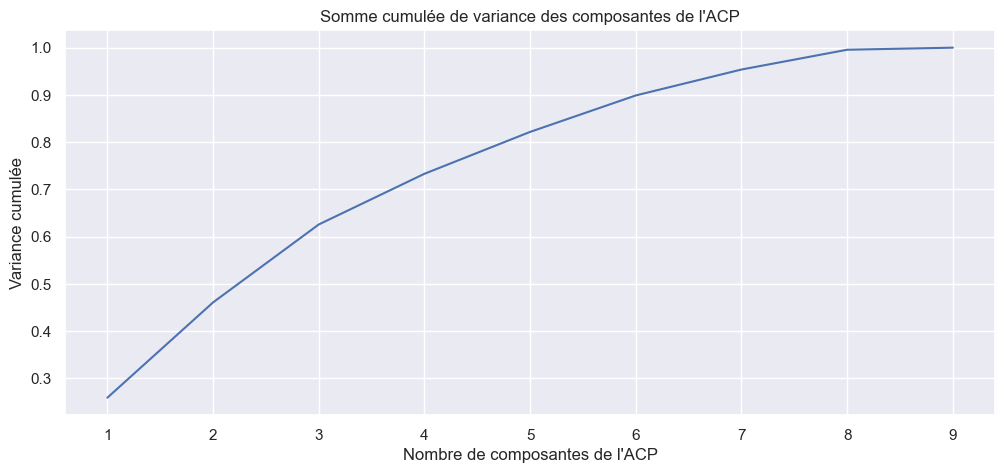

In [239]:
# Création d'une figure avec une taille de 12 pouces en largeur et 5 pouces en hauteur
plt.figure(figsize=(12, 5))

# Ajout d'un titre à la figure
plt.title('Somme cumulée de variance des composantes de l\'ACP')

# Ajout d'un label pour l'axe des abscisses
plt.xlabel('Nombre de composantes de l\'ACP')

# Ajout d'un label pour l'axe des ordonnées
plt.ylabel('Variance cumulée')

# Obtenir le nombre de composantes principales utilisées dans l'ACP
n_components = pca.n_components_

# Traçage d'une courbe en utilisant la fonction np.arange() pour générer un tableau d'abscisses allant de 1 à n_components
# et la fonction np.cumsum() pour calculer la somme cumulée de la variance expliquée par chaque composante de l'ACP
plt.plot(np.arange(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_))


On voit qu'à partir de 7 features on a une variance cumulée de plus de 95 %. On pourrait donc réduire notre jeu de données à 7 dimensions si on souhaitait gagner en temps de calcul / volume de données.


In [240]:
pca.components_

array([[-0.00440167,  0.12825489,  0.2559053 ,  0.26128766, -0.1508342 ,
        -0.19236757,  0.38369405,  0.5688295 ,  0.56500274],
       [-0.07237168, -0.434404  , -0.33138007, -0.38774884, -0.5017031 ,
        -0.4910088 , -0.15913811,  0.10170387,  0.13202   ],
       [ 0.43365198, -0.01911839, -0.43493146, -0.3646853 ,  0.37129155,
         0.34729603, -0.1082785 ,  0.33893266,  0.32303002],
       [ 0.6468529 , -0.4412031 ,  0.32567552,  0.37332377, -0.16474739,
         0.05327263, -0.33372775, -0.00308933, -0.01105889],
       [-0.61491096, -0.37719128,  0.17432103,  0.07725716,  0.12418174,
         0.36688367, -0.44879052,  0.20000163,  0.22763199],
       [-0.05283179, -0.6726193 , -0.10348162,  0.08172128,  0.27990657,
         0.06553963,  0.653744  , -0.08101757, -0.10400379],
       [ 0.06824692, -0.07148395,  0.6482231 , -0.58107626,  0.37448433,
        -0.3008528 , -0.02308951,  0.02584266, -0.02091542],
       [ 0.04577117,  0.00406059,  0.25961047, -0.39773455, -0

In [241]:
pca.components_.shape

(9, 9)

### <a name="C332">3.3.2 - Plan factoriel pour les 2 premières composantes de l'ACP </a>

Dans l'hypothèse où on ne retiendrait que les 2 composantes les plus explicatives, on obtient le plan factoriel ci-dessous

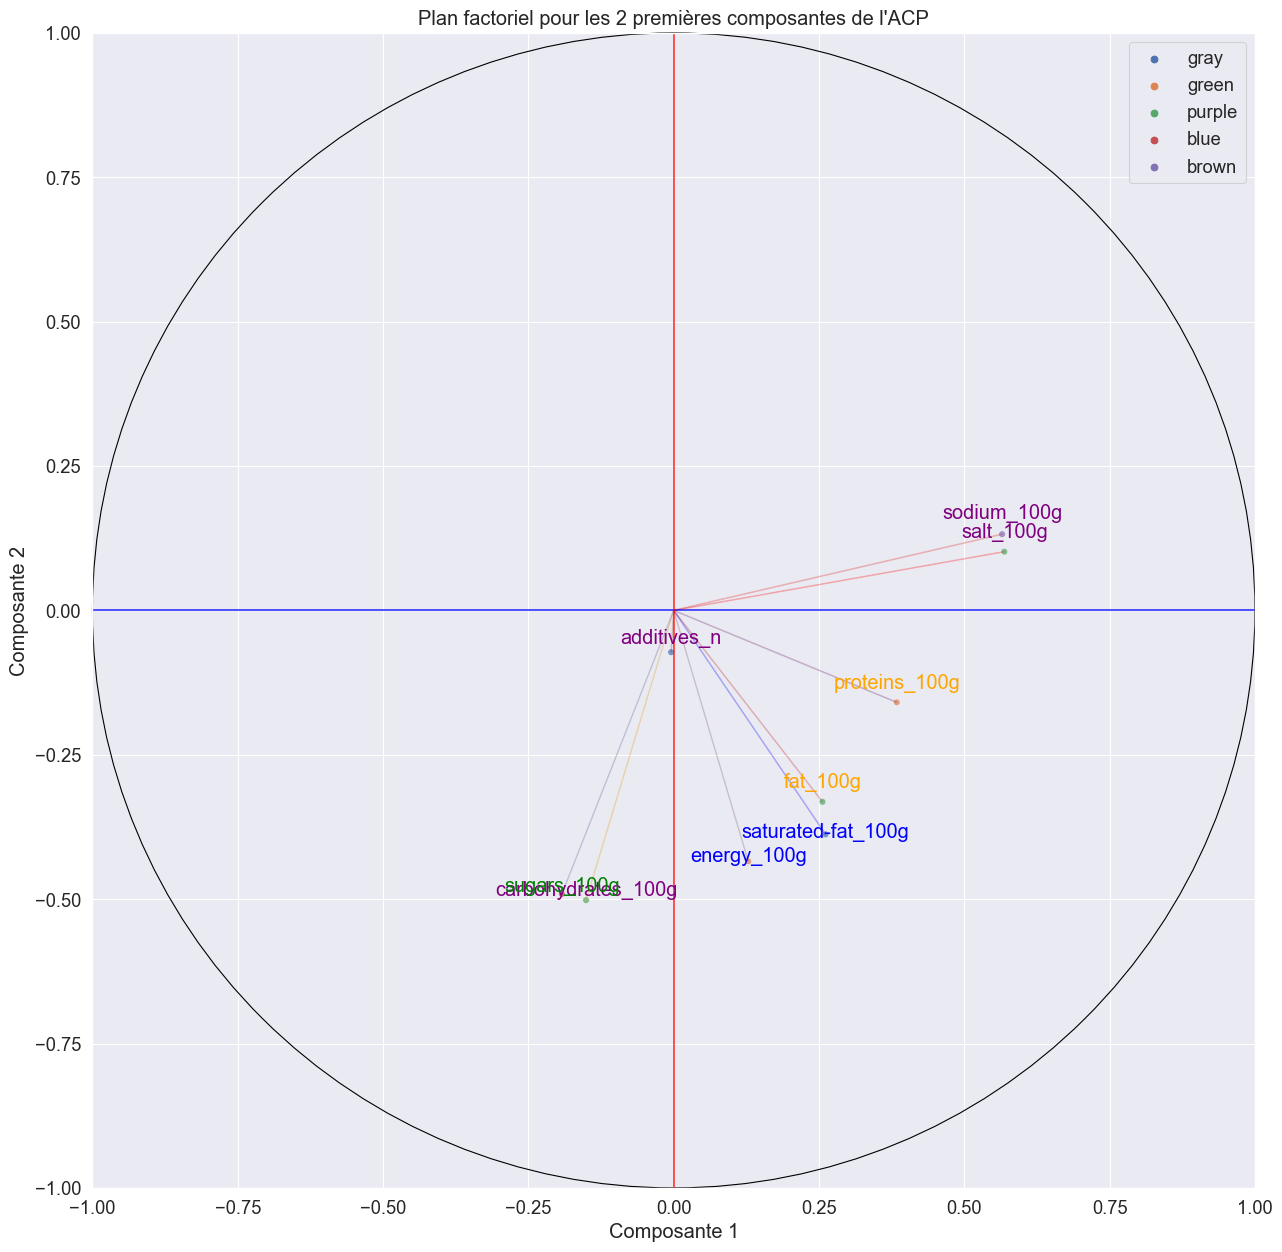

In [242]:
# Importation des bibliothèques nécessaires
from matplotlib.patches import Circle
import seaborn as sns
import random

# Configuration des paramètres d'affichage des graphiques
sns.set_context("paper", font_scale=1.5)

# Création d'une figure et définition du titre
plt.figure(figsize=(15,15))
chaine = "Plan factoriel pour les 2 premières composantes de l'ACP"
plt.title(chaine)

# Définition des labels des axes
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')

# Récupération de l'objet axe courant
ax = plt.gca()

# Ajout d'un cercle unitaire centré en (0,0)
ax.add_patch(Circle([0,0], radius=1, color='black', fill=False, linestyle='-', clip_on=False))

# Définition des limites des axes
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

# Récupération des coordonnées des deux premières composantes principales
x_pca = pca.components_[0,:]
y_pca = pca.components_[1,:]

# Affichage des points des individus dans le plan factoriel avec des couleurs aléatoires
sns.scatterplot(x = x_pca,
                y = y_pca,
                hue = [random.choice(['red', 'blue', 'green', 'orange', 'purple',  'brown', 'gray']) for _ in range(len(x_pca))],
                alpha = 0.7)

# Ajout des axes X et Y
plt.plot([-1,1],[0,0], color=random.choice([ 'blue']), alpha=0.8)
plt.plot([0,0],[-1,1], color=random.choice(['red']), alpha=0.8)

# Parcours des colonnes du jeu de données et ajout d'une annotation pour chaque colonne avec des couleurs aléatoires
for x,y,colonne in zip(x_pca,y_pca, colonnes_pca):
    plt.annotate(colonne, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,5+np.random.randint(-10,10)),
                 ha='center',
                 #color=random.choice(['red', 'blue', 'green']))
                 color=random.choice(['red', 'blue', 'green', 'orange', 'purple',  'brown', 'gray']))

    # Ajout d'une flèche représentant la contribution de la variable au plan factoriel avec une couleur aléatoire
    ax.arrow(0, 0, x, y, head_width=0, head_length=0, fc=random.choice([ 'red', 'blue', 'green', 'orange', 'purple',  'brown', 'gray' ]), ec=random.choice(['red', 'blue', 'green', 'orange', 'purple',  'brown', 'gray']),alpha=0.2)

# Configuration des paramètres d'affichage des graphiques
sns.set_context("paper", font_scale=1)


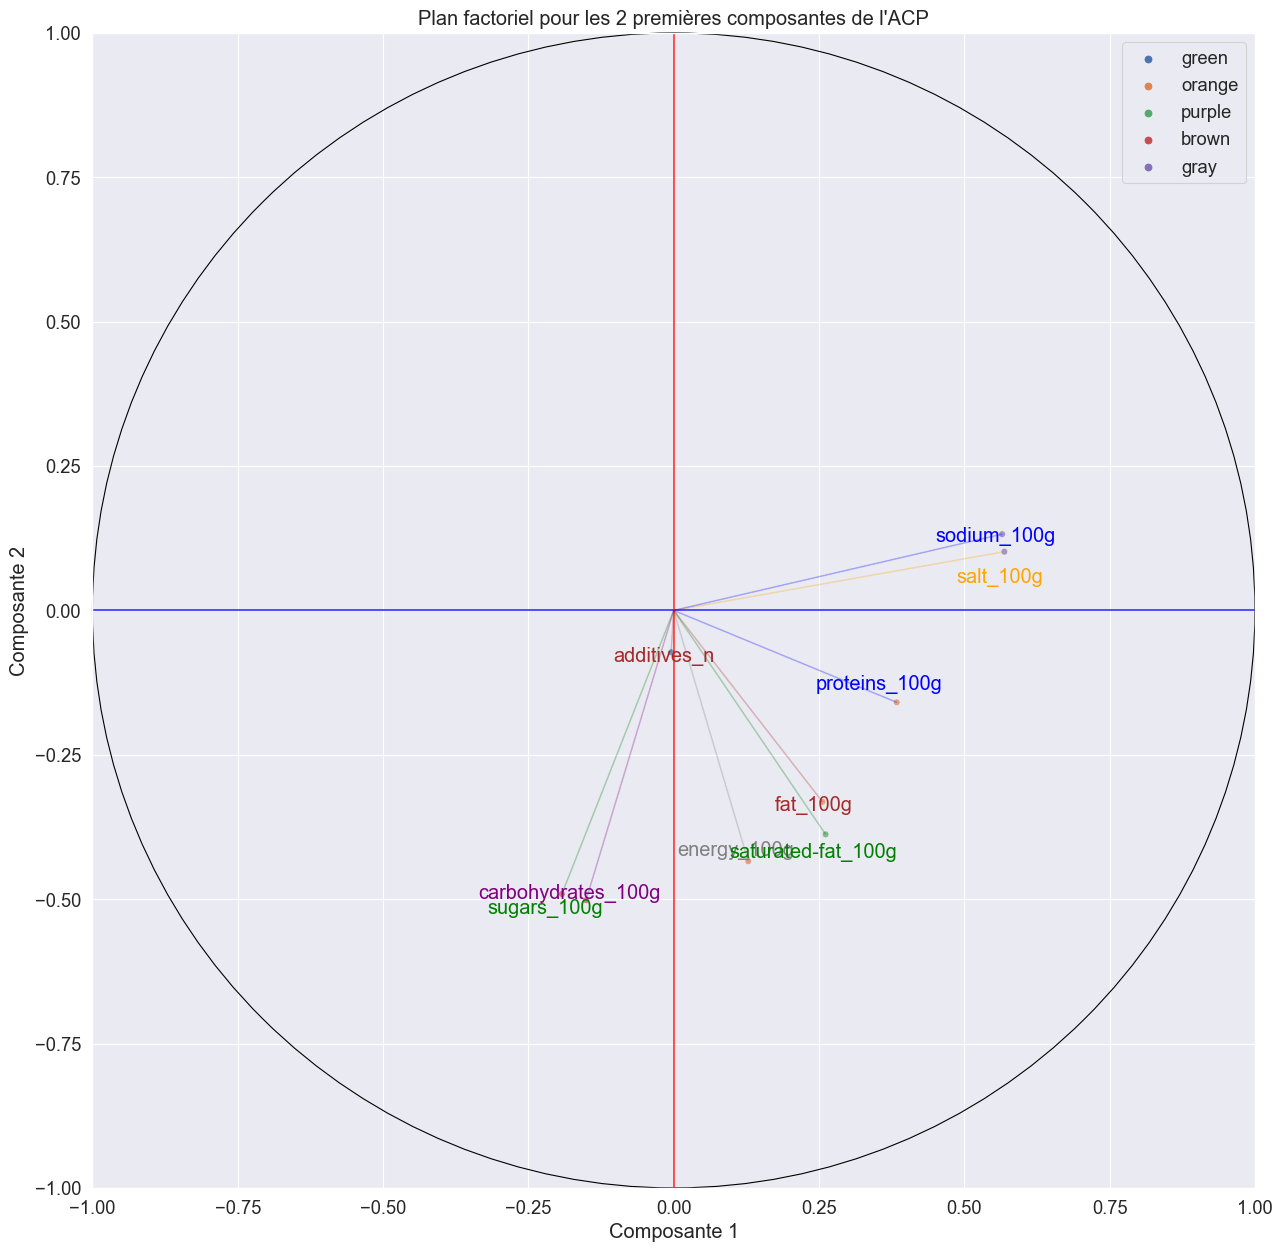

In [243]:
# Importation des bibliothèques nécessaires
from matplotlib.patches import Circle
import seaborn as sns
import random

# Configuration des paramètres d'affichage des graphiques
sns.set_context("paper", font_scale=1.5)

# Création d'une figure et définition du titre
fig, ax = plt.subplots(figsize=(15,15))
chaine = "Plan factoriel pour les 2 premières composantes de l'ACP"
ax.set_title(chaine)

# Définition des labels des axes
ax.set_xlabel('Composante 1')
ax.set_ylabel('Composante 2')

# Ajout d'un cercle unitaire centré en (0,0)
ax.add_patch(Circle([0,0], radius=1, color='black', fill=False, linestyle='-', clip_on=False))

# Définition des limites des axes
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

# Récupération des coordonnées des deux premières composantes principales
x_pca = pca.components_[0,:]
y_pca = pca.components_[1,:]

# Affichage des points des individus dans le plan factoriel avec des couleurs aléatoires
sns.scatterplot(x = x_pca,
                y = y_pca,
                hue = [random.choice(['red', 'blue', 'green', 'orange', 'purple', 'brown', 'gray']) for _ in range(len(x_pca))],
                alpha = 0.7,
                ax=ax)

# Ajout des axes X et Y
ax.plot([-1,1],[0,0], color=random.choice(['blue']), alpha=0.8)
ax.plot([0,0],[-1,1], color=random.choice(['red']), alpha=0.8)

# Parcours des colonnes du jeu de données et ajout d'une annotation pour chaque colonne avec des couleurs aléatoires
for x,y,colonne in zip(x_pca,y_pca, colonnes_pca):
    offset = 5+np.random.randint(-10,10)
    color = random.choice(['red', 'blue', 'green', 'orange', 'purple', 'brown', 'gray'])
    ax.annotate(colonne, 
                 (x,y), 
                 textcoords="offset points", 
 #                xytext=(0, offset), 
                 xytext=(np.random.randint(-15,1), np.random.randint(-25,10)) ,
                 ha='center',
                 color=color)

    # Ajout d'une flèche représentant la contribution de la variable au plan factoriel avec une couleur aléatoire
    ax.arrow(0, 0, x, y, head_width=0, head_length=0, fc=color, ec=color, alpha=0.2)

# Configuration des paramètres d'affichage des graphiques
sns.set_context("paper", font_scale=1)


### <a name="C333">3.3.3 - Observations </a>

 * fat_100g et saturated-fat_100g expliquent bien la variance sur la composante 1 mais pas sur al composante 2
* ingredients_that_may_be_from_palm_oil n'explique la variable sur aucune des 2 composantes
* additives_n n'explique pas la variable sur la composante 2 et quasiment pas sur la composante 1
* sodium_100g et salt_100g sont quasi confondus : les variables sont corrélées positivement
* 
* carbohydrates_100g, sugars_100g, sodium_100g et salt_100g expliquent bien al variance sur la composante 2, moins sur la composante 1.


### <a name="C334">3.3.4 - Plan factoriel pour les 2 premières composantes de l'ACP pour le nutrition-score-fr_100g </a>

Regardons maintenant comment le jeu de donnée est réparti sur les deux premières composantes en fonction des nutri scores

Retraçons le même graphe que précédemment en ajoutant les points du jeu de donnée, après transformation, ainsi que l'information relative au nutriscore

In [244]:
# Sélectionne les colonnes numériques de l'ensemble de données nettoyé
# Exclut la colonne "nutrition-score-fr_100g" et supprime toutes les lignes contenant des valeurs manquantes
nutriscore_index = data_to_clean_cleaned.select_dtypes(['int8', 'float32','float64','int32']).drop(['nutrition-score-fr_100g'], axis=1).dropna().index

# Récupère les valeurs de la colonne "nutrition_grade_fr" correspondant aux lignes sélectionnées
nutriscore_grade = data_to_clean_cleaned['nutrition_grade_fr'].loc[nutriscore_index]

#nutriscore_grade = nutriscore_grade.fillna('Unknown')
#nutriscore_grade = nutriscore_grade.astype('category')

# Ajoute la catégorie "Unknown" aux valeurs manquantes de la colonne "nutrition_grade_fr" et remplace toutes les valeurs manquantes par "Unknown"
nutriscore_grade = nutriscore_grade.cat.add_categories("Unknown").fillna("Unknown")

# Récupère les index des lignes ayant la valeur "Unknown" dans la colonne "nutrition_grade_fr"
unknown_index = nutriscore_grade[nutriscore_grade =='Unknown'].index


In [245]:
data_to_clean_cleaned.select_dtypes(['int8', 'float32','float64','int32'])


additives_n  ingredients_from_palm_oil_n  \
3       0.000000     0.0                           
7       0.000000     0.0                           
12      0.000000     0.0                           
15      0.000000     0.0                           
16      0.000000     0.0                           
...          ...     ...                           
191476  0.000000     0.0                           
191478  0.000000     0.0                           
191479  1.855903     0.0                           
191480  1.855903     0.0                           
191481  1.855903     0.0                           

        ingredients_that_may_be_from_palm_oil_n  energy_100g    fat_100g  \
3       0.0                                      100.000000   18.270000    
7       0.0                                      100.000000   100.000000   
12      0.0                                      100.000000   48.480000    
15      0.0                                      100.000000   26.670000    
16      0.0                                      100.000000   2.220000     
...     ...                                             ...        ...     
191476  0.0                                      21.000000    0.200000     
191478  0.0                                      100.000000   1.352000     
191479  0.0                                      92.659187    12.221967    
191480  0.0                                      92.659187    12.221967    
191481  0.0                                      92.659187    12.221967    

        saturated-fat_100g  carbohydrates_100g  sugars_100g  proteins_100g  \
3       1.920000            63.459999           11.540000    13.460000       
7       7.140000            10.400000           23.740000    0.652000        
12      9.090000            15.150000           29.635998    30.299999       
15      23.330000           66.669998           16.670000    3.330000        
16      5.060000            77.779999           2.220000     8.890000        
...          ...                  ...                ...          ...        
191476  0.200000            0.500000            0.500000     0.500000        
191478  4.280000            10.400000           4.830000     1.200000        
191479  4.854555            29.315306           15.895791    6.071839        
191480  4.854555            29.315306           15.895791    6.071839        
191481  4.854555            29.315306           15.895791    6.071839        

        salt_100g  sodium_100g  nutrition-score-fr_100g  
3       0.001593   0.075404     0.000000                 
7       0.002000   0.130490     17.200001                
12      0.576580   0.227000     5.000000                 
15      0.005230   0.022262     0.000000                 
16      0.010145   0.017404     0.000000                 
...          ...        ...          ...                 
191476  0.025400   0.010000     2.000000                 
191478  0.422672   0.338589     6.600000                 
191479  0.816632   0.321601     9.618816                 
191480  0.816632   0.321601     9.618816                 
191481  0.816632   0.321601     9.618816                 

[36906 rows x 12 columns]

In [248]:
x_show = pca.transform(data_to_clean_cleaned.select_dtypes(['int8', 'float32','float64','int32'])
                       .drop(['nutrition-score-fr_100g','ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n'], axis=1).drop(unknown_index).dropna())[:,0]

y_show = pca.transform(data_to_clean_cleaned.select_dtypes(['int8', 'float32','float64','int32'])
                       .drop(['nutrition-score-fr_100g','ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n'], axis=1).drop(unknown_index).dropna())[:,1]

hue_show = nutriscore_grade[nutriscore_grade != 'Unknown']

In [249]:
x_show

array([11.418722, 34.471165, 31.7029  , ..., 11.768299, 11.768299,
       11.768299], dtype=float32)

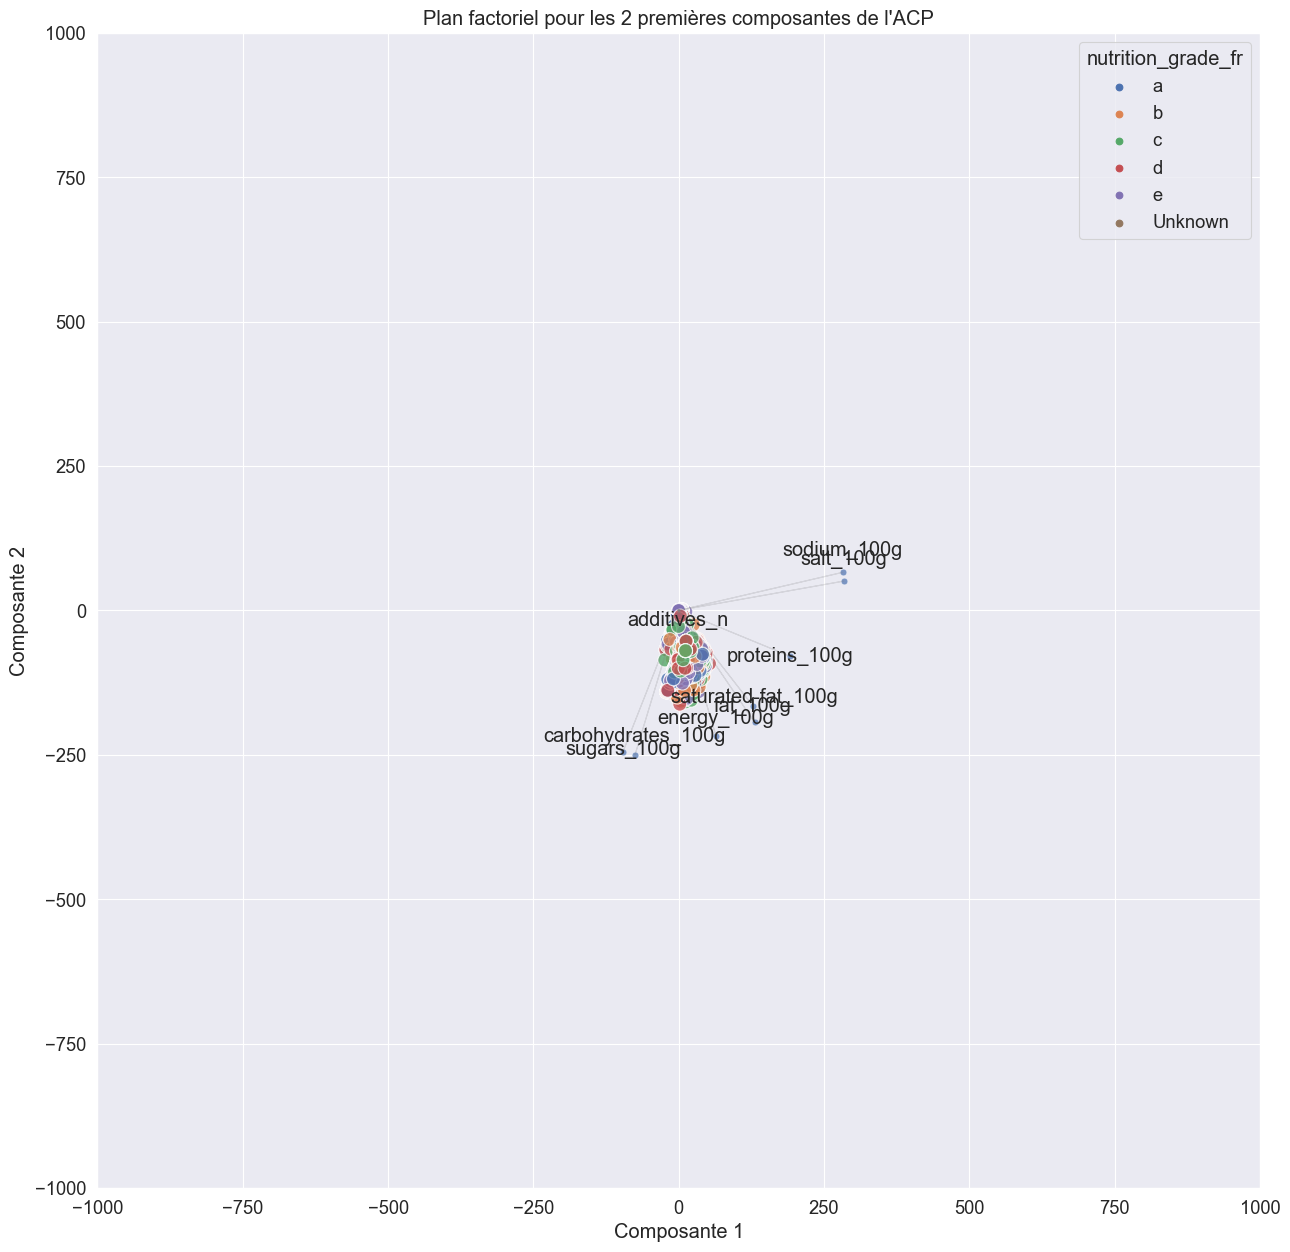

In [250]:
from matplotlib.patches import Circle
sns.set_context("paper", font_scale=1.5) 
plt.figure(figsize=(15,15))
chaine = "Plan factoriel pour les 2 premières composantes de l'ACP"
plt.title(chaine)
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
ax = plt.gca()

ax.set_xlim(-1000,1000)
ax.set_ylim(-1000,1000)
x_pca = pca.components_[0,:]*500
y_pca = pca.components_[1,:]*500

sns.scatterplot(x = x_pca,
                y = y_pca,
               alpha = 0.7)
sns.scatterplot(x = x_show,
                y = y_show,
                hue = hue_show,
                alpha=0.8, s=100)
plt.plot([-1,1],[0,0], color='grey', alpha=0.8)
plt.plot([0,0],[-1,1], color='grey', alpha=0.8)

i = 0
for x,y,colonne in zip(x_pca,y_pca, colonnes_pca):

    plt.annotate(colonne, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5+np.random.randint(-10,10)), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    ax.arrow(0, 0, x, y, head_width=0, head_length=0, fc='grey', ec='grey',alpha=0.2)


sns.set_context("paper", font_scale=1) 


### <a name="C335">3.3.5 - Observations Plan factoriel pour les 2 premières composantes de l'ACP pour nutrition-score-fr_100g</a>

* on observe des alignements de points le long de certains vecteurs (en particulier energy_100g)
* On observe que les nutriscore d ont tendance à avoir des valeurs plus importantes en sucres
* Sur ces deux premières composantes, on observe uen première tendance de sépération des points avec :
    * des nutriscores d'indice a centrés autour de l'origine
    * des nutriscores d'indices d fortement alignés avec les composantes saturated_fat_100g, fat_100g et sugars_100g 
    * des nutriscores d'indices c en position intermédiaire entre a et d

### <a name="C336">3.3.6 - Impact des features sur les composantes de l'ACP </a>

In [251]:
# Création d'un DataFrame contenant les composantes principales obtenues par l'analyse en composantes principales
pca_analysis = pd.DataFrame(pca.components_)

# Renommage des colonnes du DataFrame
pca_analysis.columns = colonnes_pca


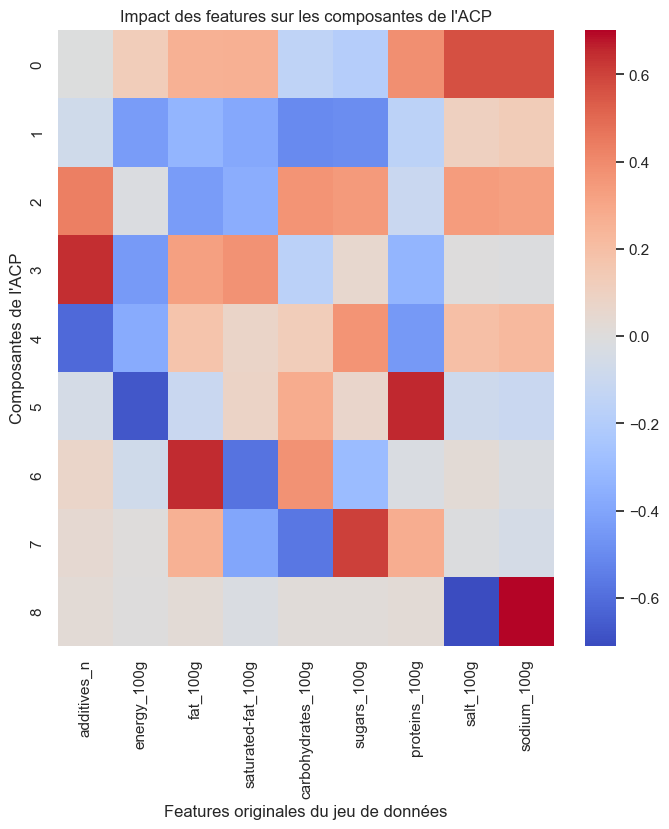

In [252]:

# Définition de la taille et de l'échelle de la police
sns.set(font_scale=1.5)

# Création d'une figure de taille 8x8 pouces
plt.figure(figsize=(8,8))

# Configuration de paramètres d'affichage de seaborn
sns.set()

# Création d'une heatmap de la matrice des composantes principales avec la colormap 'coolwarm'
sns.heatmap(pca_analysis, cmap='coolwarm')

# Définition du titre de la heatmap
plt.title('Impact des features sur les composantes de l\'ACP')

# Définition du label de l'axe X
plt.xlabel('Features originales du jeu de données')

# Définition du label de l'axe Y
plt.ylabel('Composantes de l\'ACP')

# Rétablissement de la taille de la police par défaut
sns.set(font_scale=1)


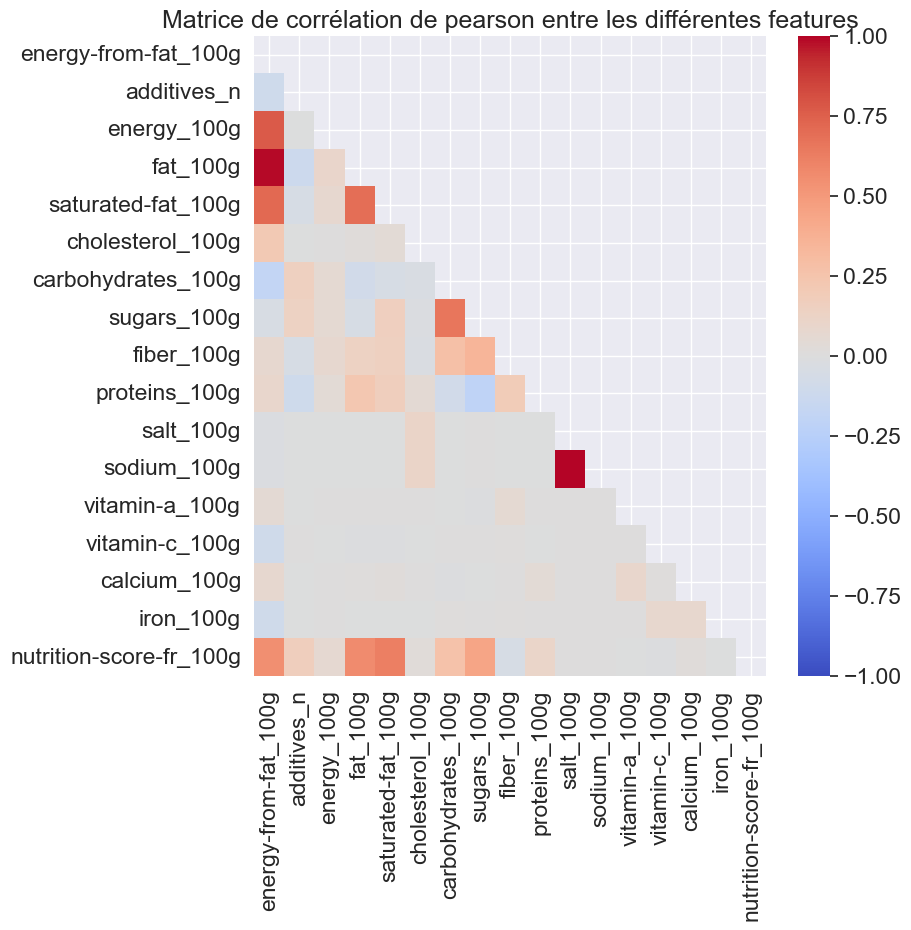

In [253]:
numeric_columns = ['energy-from-fat_100g', 'additives_n','energy_100g', 'fat_100g',
       'saturated-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'calcium_100g', 'iron_100g', 'nutrition-score-fr_100g']
# Crée une nouvelle figure avec une taille de 8 pouces de large et 8 pouces de hauteur
plt.figure(figsize=(8,8))

# Définit la taille de police pour les titres et les labels des graphiques
sns.set(font_scale=1.5)
chaine = 'Matrice de corrélation de pearson entre les différentes features'
# Définit le titre du graphique
plt.title(chaine )

# Calcule la matrice de corrélation de Pearson entre les colonnes numériques du dataframe
corr = data[numeric_columns].corr()

# Crée un masque pour masquer la partie supérieure de la matrice de corrélation
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True 

# Trace le heatmap de la matrice de corrélation avec une couleur allant du bleu foncé (valeurs négatives) au rouge foncé (valeurs positives) et avec le masque défini précédemment
ax = sns.heatmap(corr, mask=mask, vmin=-1, cmap='coolwarm')

# Affiche le graphique
save_figure_opt(chaine, chaine, library='matplotlib')
# plt.show()

# Réinitialise la taille de police pour les titres et les labels des graphiques
sns.set(font_scale=1)


### <a name="C337">3.3.7 - Calcul de la norme des six premiers composants principaux</a>

Ensuite, on calcule la norme des six premiers composants principaux de l'analyse en composantes principales. Pour cela, la fonction np.linalg.norm est utilisée, avec les six premiers composants principaux fournis comme premier argument. La fonction est appliquée selon l'axe 0 (axis=0) pour obtenir un vecteur de normes, une norme pour chaque composant principal. Le résultat est stocké dans la variable norms.

In [254]:
# Calcul de la norme des six premiers composants principaux
norms = np.linalg.norm(pca.components_[0:6], axis=0)

In [255]:
norms

array([0.9963114 , 0.9974326 , 0.7152807 , 0.7096714 , 0.73022246,
       0.7351507 , 0.9614773 , 0.70381814, 0.7097613 ], dtype=float32)

In [256]:
normes = pd.DataFrame(norms).T

In [257]:
normes.columns = colonnes_pca

In [258]:
normes = normes.T.reset_index()

In [259]:
normes.columns = ['feature', 'norme']
normes.sort_values(by='norme', inplace=True, ascending=False)

<Axes: title={'center': "Importance relative des features dans \n les 7 premières composantes de l'ACP"}, xlabel='norme', ylabel='feature'>

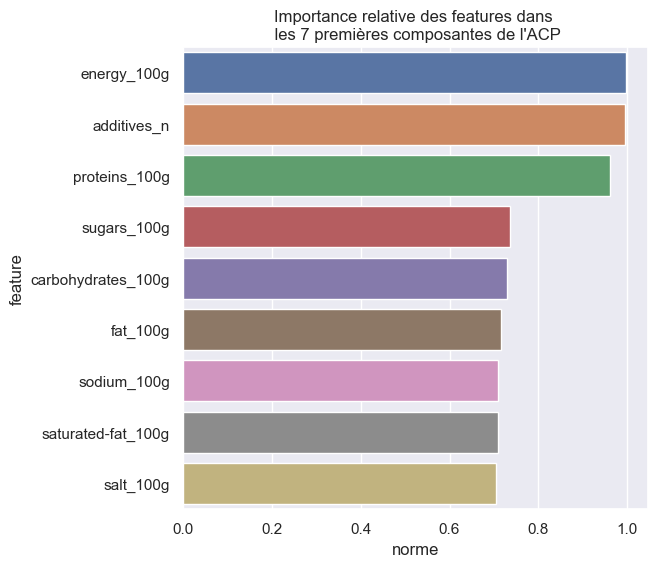

In [260]:
plt.figure(figsize=(6,6))
plt.title('Importance relative des features dans \n les 7 premières composantes de l\'ACP')
sns.barplot(y = normes['feature'],
            x = normes['norme'])

# Parties suivantes : voir notebook analysis